In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = ""


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data(shuffle_training_data=False)
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 375443 images
Dataset type val label type: species


Loaded 48562 images
Dataset type test label type: species


 - Min class count:  976
Loaded 20496 images
Dataset type test label type: species


 - Min class count:  976
Loaded 0 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 hu88k90i


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    rnd_inp = []
    rnd_e_u = []
    rnd_e_v = []
    rnd_rcn = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_e_u.extend(e_u.detach().cpu().numpy())
        rnd_e_v.extend(e_v.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                        | 0/2934 [00:00<?, ?it/s]

  0%|                                                                                                                                              | 1/2934 [00:01<1:35:28,  1.95s/it]

  0%|                                                                                                                                                | 2/2934 [00:02<44:12,  1.11it/s]

  0%|▏                                                                                                                                               | 3/2934 [00:02<27:48,  1.76it/s]

  0%|▏                                                                                                                                               | 4/2934 [00:02<20:07,  2.43it/s]

  0%|▏                                                                                                                                               | 5/2934 [00:02<15:51,  3.08it/s]

  0%|▎                                                                                                                                               | 6/2934 [00:02<13:17,  3.67it/s]

  0%|▎                                                                                                                                               | 7/2934 [00:02<11:39,  4.18it/s]

  0%|▍                                                                                                                                               | 8/2934 [00:03<10:35,  4.60it/s]

  0%|▍                                                                                                                                               | 9/2934 [00:03<09:52,  4.94it/s]

  0%|▍                                                                                                                                              | 10/2934 [00:03<09:23,  5.19it/s]

  0%|▌                                                                                                                                              | 11/2934 [00:03<09:03,  5.38it/s]

  0%|▌                                                                                                                                              | 12/2934 [00:03<08:49,  5.52it/s]

  0%|▋                                                                                                                                              | 13/2934 [00:03<08:39,  5.62it/s]

  0%|▋                                                                                                                                              | 14/2934 [00:04<08:33,  5.69it/s]

  1%|▋                                                                                                                                              | 15/2934 [00:04<08:28,  5.74it/s]

  1%|▊                                                                                                                                              | 16/2934 [00:04<08:25,  5.77it/s]

  1%|▊                                                                                                                                              | 17/2934 [00:04<08:22,  5.80it/s]

  1%|▉                                                                                                                                              | 18/2934 [00:04<08:21,  5.82it/s]

  1%|▉                                                                                                                                              | 19/2934 [00:05<08:19,  5.83it/s]

  1%|▉                                                                                                                                              | 20/2934 [00:05<08:18,  5.84it/s]

  1%|█                                                                                                                                              | 21/2934 [00:05<08:17,  5.85it/s]

  1%|█                                                                                                                                              | 22/2934 [00:05<08:17,  5.85it/s]

  1%|█                                                                                                                                              | 23/2934 [00:05<08:17,  5.85it/s]

  1%|█▏                                                                                                                                             | 24/2934 [00:05<08:16,  5.86it/s]

  1%|█▏                                                                                                                                             | 25/2934 [00:06<08:16,  5.86it/s]

  1%|█▎                                                                                                                                             | 26/2934 [00:06<08:16,  5.86it/s]

  1%|█▎                                                                                                                                             | 27/2934 [00:06<08:15,  5.86it/s]

  1%|█▎                                                                                                                                             | 28/2934 [00:06<08:15,  5.86it/s]

  1%|█▍                                                                                                                                             | 29/2934 [00:06<08:15,  5.86it/s]

  1%|█▍                                                                                                                                             | 30/2934 [00:06<08:15,  5.86it/s]

  1%|█▌                                                                                                                                             | 31/2934 [00:07<08:15,  5.86it/s]

  1%|█▌                                                                                                                                             | 32/2934 [00:07<08:15,  5.86it/s]

  1%|█▌                                                                                                                                             | 33/2934 [00:07<08:14,  5.86it/s]

  1%|█▋                                                                                                                                             | 34/2934 [00:07<08:14,  5.86it/s]

  1%|█▋                                                                                                                                             | 35/2934 [00:07<08:14,  5.86it/s]

  1%|█▊                                                                                                                                             | 36/2934 [00:07<08:14,  5.86it/s]

  1%|█▊                                                                                                                                             | 37/2934 [00:08<08:14,  5.85it/s]

  1%|█▊                                                                                                                                             | 38/2934 [00:08<08:14,  5.86it/s]

  1%|█▉                                                                                                                                             | 39/2934 [00:08<08:14,  5.86it/s]

  1%|█▉                                                                                                                                             | 40/2934 [00:08<08:13,  5.86it/s]

  1%|█▉                                                                                                                                             | 41/2934 [00:08<08:13,  5.86it/s]

  1%|██                                                                                                                                             | 42/2934 [00:08<08:13,  5.86it/s]

  1%|██                                                                                                                                             | 43/2934 [00:09<08:13,  5.86it/s]

  1%|██▏                                                                                                                                            | 44/2934 [00:09<08:13,  5.86it/s]

  2%|██▏                                                                                                                                            | 45/2934 [00:09<08:13,  5.86it/s]

  2%|██▏                                                                                                                                            | 46/2934 [00:09<08:12,  5.86it/s]

  2%|██▎                                                                                                                                            | 47/2934 [00:09<08:12,  5.86it/s]

  2%|██▎                                                                                                                                            | 48/2934 [00:09<08:12,  5.86it/s]

  2%|██▍                                                                                                                                            | 49/2934 [00:10<08:11,  5.87it/s]

  2%|██▍                                                                                                                                            | 50/2934 [00:10<08:11,  5.87it/s]

  2%|██▍                                                                                                                                            | 51/2934 [00:10<08:12,  5.86it/s]

  2%|██▌                                                                                                                                            | 52/2934 [00:10<08:11,  5.86it/s]

  2%|██▌                                                                                                                                            | 53/2934 [00:10<08:11,  5.86it/s]

  2%|██▋                                                                                                                                            | 54/2934 [00:10<08:11,  5.86it/s]

  2%|██▋                                                                                                                                            | 55/2934 [00:11<08:10,  5.86it/s]

  2%|██▋                                                                                                                                            | 56/2934 [00:11<08:10,  5.86it/s]

  2%|██▊                                                                                                                                            | 57/2934 [00:11<08:10,  5.86it/s]

  2%|██▊                                                                                                                                            | 58/2934 [00:11<08:11,  5.86it/s]

  2%|██▉                                                                                                                                            | 59/2934 [00:11<08:10,  5.86it/s]

  2%|██▉                                                                                                                                            | 60/2934 [00:12<08:10,  5.86it/s]

  2%|██▉                                                                                                                                            | 61/2934 [00:12<08:10,  5.86it/s]

  2%|███                                                                                                                                            | 62/2934 [00:12<08:09,  5.86it/s]

  2%|███                                                                                                                                            | 63/2934 [00:12<08:09,  5.86it/s]

  2%|███                                                                                                                                            | 64/2934 [00:12<08:09,  5.86it/s]

  2%|███▏                                                                                                                                           | 65/2934 [00:12<08:09,  5.86it/s]

  2%|███▏                                                                                                                                           | 66/2934 [00:13<08:09,  5.86it/s]

  2%|███▎                                                                                                                                           | 67/2934 [00:13<08:09,  5.86it/s]

  2%|███▎                                                                                                                                           | 68/2934 [00:13<08:09,  5.86it/s]

  2%|███▎                                                                                                                                           | 69/2934 [00:13<08:08,  5.86it/s]

  2%|███▍                                                                                                                                           | 70/2934 [00:13<08:08,  5.86it/s]

  2%|███▍                                                                                                                                           | 71/2934 [00:13<08:08,  5.86it/s]

  2%|███▌                                                                                                                                           | 72/2934 [00:14<08:08,  5.86it/s]

  2%|███▌                                                                                                                                           | 73/2934 [00:14<08:08,  5.86it/s]

  3%|███▌                                                                                                                                           | 74/2934 [00:14<08:07,  5.86it/s]

  3%|███▋                                                                                                                                           | 75/2934 [00:14<08:07,  5.86it/s]

  3%|███▋                                                                                                                                           | 76/2934 [00:14<08:07,  5.86it/s]

  3%|███▊                                                                                                                                           | 77/2934 [00:14<08:07,  5.86it/s]

  3%|███▊                                                                                                                                           | 78/2934 [00:15<08:07,  5.86it/s]

  3%|███▊                                                                                                                                           | 79/2934 [00:15<08:07,  5.85it/s]

  3%|███▉                                                                                                                                           | 80/2934 [00:15<08:07,  5.86it/s]

  3%|███▉                                                                                                                                           | 81/2934 [00:15<08:06,  5.86it/s]

  3%|███▉                                                                                                                                           | 82/2934 [00:15<08:06,  5.86it/s]

  3%|████                                                                                                                                           | 83/2934 [00:15<08:06,  5.86it/s]

  3%|████                                                                                                                                           | 84/2934 [00:16<08:06,  5.86it/s]

  3%|████▏                                                                                                                                          | 85/2934 [00:16<08:05,  5.86it/s]

  3%|████▏                                                                                                                                          | 86/2934 [00:16<08:06,  5.86it/s]

  3%|████▏                                                                                                                                          | 87/2934 [00:16<08:05,  5.86it/s]

  3%|████▎                                                                                                                                          | 88/2934 [00:16<08:05,  5.86it/s]

  3%|████▎                                                                                                                                          | 89/2934 [00:16<08:05,  5.86it/s]

  3%|████▍                                                                                                                                          | 90/2934 [00:17<08:04,  5.86it/s]

  3%|████▍                                                                                                                                          | 91/2934 [00:17<08:04,  5.87it/s]

  3%|████▍                                                                                                                                          | 92/2934 [00:17<08:04,  5.87it/s]

  3%|████▌                                                                                                                                          | 93/2934 [00:17<08:05,  5.86it/s]

  3%|████▌                                                                                                                                          | 94/2934 [00:17<08:04,  5.86it/s]

  3%|████▋                                                                                                                                          | 95/2934 [00:17<08:04,  5.86it/s]

  3%|████▋                                                                                                                                          | 96/2934 [00:18<08:04,  5.86it/s]

  3%|████▋                                                                                                                                          | 97/2934 [00:18<08:03,  5.86it/s]

  3%|████▊                                                                                                                                          | 98/2934 [00:18<08:03,  5.87it/s]

  3%|████▊                                                                                                                                          | 99/2934 [00:18<08:03,  5.87it/s]

  3%|████▊                                                                                                                                         | 100/2934 [00:18<08:03,  5.86it/s]

  3%|████▉                                                                                                                                         | 101/2934 [00:19<08:03,  5.86it/s]

  3%|████▉                                                                                                                                         | 102/2934 [00:19<08:02,  5.87it/s]

  4%|████▉                                                                                                                                         | 103/2934 [00:19<08:02,  5.87it/s]

  4%|█████                                                                                                                                         | 104/2934 [00:19<08:01,  5.87it/s]

  4%|█████                                                                                                                                         | 105/2934 [00:19<08:01,  5.87it/s]

  4%|█████▏                                                                                                                                        | 106/2934 [00:19<08:01,  5.87it/s]

  4%|█████▏                                                                                                                                        | 107/2934 [00:20<08:01,  5.87it/s]

  4%|█████▏                                                                                                                                        | 108/2934 [00:20<08:01,  5.87it/s]

  4%|█████▎                                                                                                                                        | 109/2934 [00:20<08:01,  5.87it/s]

  4%|█████▎                                                                                                                                        | 110/2934 [00:20<08:00,  5.87it/s]

  4%|█████▎                                                                                                                                        | 111/2934 [00:20<08:00,  5.87it/s]

  4%|█████▍                                                                                                                                        | 112/2934 [00:20<08:00,  5.87it/s]

  4%|█████▍                                                                                                                                        | 113/2934 [00:21<08:00,  5.88it/s]

  4%|█████▌                                                                                                                                        | 114/2934 [00:21<08:00,  5.87it/s]

  4%|█████▌                                                                                                                                        | 115/2934 [00:21<08:00,  5.87it/s]

  4%|█████▌                                                                                                                                        | 116/2934 [00:21<08:00,  5.87it/s]

  4%|█████▋                                                                                                                                        | 117/2934 [00:21<07:59,  5.87it/s]

  4%|█████▋                                                                                                                                        | 118/2934 [00:21<07:59,  5.87it/s]

  4%|█████▊                                                                                                                                        | 119/2934 [00:22<07:59,  5.87it/s]

  4%|█████▊                                                                                                                                        | 120/2934 [00:22<07:59,  5.87it/s]

  4%|█████▊                                                                                                                                        | 121/2934 [00:22<07:59,  5.87it/s]

  4%|█████▉                                                                                                                                        | 122/2934 [00:22<07:59,  5.87it/s]

  4%|█████▉                                                                                                                                        | 123/2934 [00:22<07:58,  5.87it/s]

  4%|██████                                                                                                                                        | 124/2934 [00:22<07:58,  5.87it/s]

  4%|██████                                                                                                                                        | 125/2934 [00:23<07:58,  5.87it/s]

  4%|██████                                                                                                                                        | 126/2934 [00:23<07:58,  5.86it/s]

  4%|██████▏                                                                                                                                       | 127/2934 [00:23<07:58,  5.87it/s]

  4%|██████▏                                                                                                                                       | 128/2934 [00:23<07:58,  5.86it/s]

  4%|██████▏                                                                                                                                       | 129/2934 [00:23<07:58,  5.87it/s]

  4%|██████▎                                                                                                                                       | 130/2934 [00:23<07:57,  5.87it/s]

  4%|██████▎                                                                                                                                       | 131/2934 [00:24<07:57,  5.87it/s]

  4%|██████▍                                                                                                                                       | 132/2934 [00:24<07:57,  5.87it/s]

  5%|██████▍                                                                                                                                       | 133/2934 [00:24<07:56,  5.87it/s]

  5%|██████▍                                                                                                                                       | 134/2934 [00:24<07:56,  5.87it/s]

  5%|██████▌                                                                                                                                       | 135/2934 [00:24<07:57,  5.87it/s]

  5%|██████▌                                                                                                                                       | 136/2934 [00:24<07:56,  5.87it/s]

  5%|██████▋                                                                                                                                       | 137/2934 [00:25<07:56,  5.87it/s]

  5%|██████▋                                                                                                                                       | 138/2934 [00:25<07:56,  5.87it/s]

  5%|██████▋                                                                                                                                       | 139/2934 [00:25<07:55,  5.87it/s]

  5%|██████▊                                                                                                                                       | 140/2934 [00:25<07:55,  5.87it/s]

  5%|██████▊                                                                                                                                       | 141/2934 [00:25<07:55,  5.88it/s]

  5%|██████▊                                                                                                                                       | 142/2934 [00:25<07:55,  5.87it/s]

  5%|██████▉                                                                                                                                       | 143/2934 [00:26<07:55,  5.87it/s]

  5%|██████▉                                                                                                                                       | 144/2934 [00:26<07:55,  5.87it/s]

  5%|███████                                                                                                                                       | 145/2934 [00:26<07:54,  5.87it/s]

  5%|███████                                                                                                                                       | 146/2934 [00:26<07:54,  5.87it/s]

  5%|███████                                                                                                                                       | 147/2934 [00:26<07:54,  5.87it/s]

  5%|███████▏                                                                                                                                      | 148/2934 [00:27<07:54,  5.88it/s]

  5%|███████▏                                                                                                                                      | 149/2934 [00:27<07:54,  5.87it/s]

  5%|███████▎                                                                                                                                      | 150/2934 [00:27<07:54,  5.87it/s]

  5%|███████▎                                                                                                                                      | 151/2934 [00:27<07:53,  5.87it/s]

  5%|███████▎                                                                                                                                      | 152/2934 [00:27<07:53,  5.87it/s]

  5%|███████▍                                                                                                                                      | 153/2934 [00:27<07:53,  5.87it/s]

  5%|███████▍                                                                                                                                      | 154/2934 [00:28<07:53,  5.87it/s]

  5%|███████▌                                                                                                                                      | 155/2934 [00:28<07:53,  5.87it/s]

  5%|███████▌                                                                                                                                      | 156/2934 [00:28<07:53,  5.87it/s]

  5%|███████▌                                                                                                                                      | 157/2934 [00:28<07:53,  5.87it/s]

  5%|███████▋                                                                                                                                      | 158/2934 [00:28<07:53,  5.87it/s]

  5%|███████▋                                                                                                                                      | 159/2934 [00:28<07:52,  5.87it/s]

  5%|███████▋                                                                                                                                      | 160/2934 [00:29<07:52,  5.87it/s]

  5%|███████▊                                                                                                                                      | 161/2934 [00:29<07:52,  5.87it/s]

  6%|███████▊                                                                                                                                      | 162/2934 [00:29<07:52,  5.87it/s]

  6%|███████▉                                                                                                                                      | 163/2934 [00:29<07:52,  5.87it/s]

  6%|███████▉                                                                                                                                      | 164/2934 [00:29<07:52,  5.87it/s]

  6%|███████▉                                                                                                                                      | 165/2934 [00:29<07:51,  5.87it/s]

  6%|████████                                                                                                                                      | 166/2934 [00:30<07:51,  5.87it/s]

  6%|████████                                                                                                                                      | 167/2934 [00:30<07:51,  5.87it/s]

  6%|████████▏                                                                                                                                     | 168/2934 [00:30<07:51,  5.87it/s]

  6%|████████▏                                                                                                                                     | 169/2934 [00:30<07:50,  5.87it/s]

  6%|████████▏                                                                                                                                     | 170/2934 [00:30<07:51,  5.86it/s]

  6%|████████▎                                                                                                                                     | 171/2934 [00:30<07:50,  5.87it/s]

  6%|████████▎                                                                                                                                     | 172/2934 [00:31<07:50,  5.87it/s]

  6%|████████▎                                                                                                                                     | 173/2934 [00:31<07:50,  5.87it/s]

  6%|████████▍                                                                                                                                     | 174/2934 [00:31<07:50,  5.87it/s]

  6%|████████▍                                                                                                                                     | 175/2934 [00:31<07:49,  5.87it/s]

  6%|████████▌                                                                                                                                     | 176/2934 [00:31<07:49,  5.88it/s]

  6%|████████▌                                                                                                                                     | 177/2934 [00:31<07:49,  5.87it/s]

  6%|████████▌                                                                                                                                     | 178/2934 [00:32<07:49,  5.87it/s]

  6%|████████▋                                                                                                                                     | 179/2934 [00:32<07:49,  5.87it/s]

  6%|████████▋                                                                                                                                     | 180/2934 [00:32<07:48,  5.87it/s]

  6%|████████▊                                                                                                                                     | 181/2934 [00:32<07:48,  5.87it/s]

  6%|████████▊                                                                                                                                     | 182/2934 [00:32<07:48,  5.87it/s]

  6%|████████▊                                                                                                                                     | 183/2934 [00:32<07:48,  5.88it/s]

  6%|████████▉                                                                                                                                     | 184/2934 [00:33<07:48,  5.87it/s]

  6%|████████▉                                                                                                                                     | 185/2934 [00:33<07:48,  5.87it/s]

  6%|█████████                                                                                                                                     | 186/2934 [00:33<07:47,  5.88it/s]

  6%|█████████                                                                                                                                     | 187/2934 [00:33<07:47,  5.88it/s]

  6%|█████████                                                                                                                                     | 188/2934 [00:33<07:46,  5.88it/s]

  6%|█████████▏                                                                                                                                    | 189/2934 [00:33<07:45,  5.90it/s]

  6%|█████████▏                                                                                                                                    | 190/2934 [00:34<07:44,  5.91it/s]

  7%|█████████▏                                                                                                                                    | 191/2934 [00:34<07:44,  5.90it/s]

  7%|█████████▎                                                                                                                                    | 192/2934 [00:34<07:44,  5.90it/s]

  7%|█████████▎                                                                                                                                    | 193/2934 [00:34<07:44,  5.90it/s]

  7%|█████████▍                                                                                                                                    | 194/2934 [00:34<07:44,  5.89it/s]

  7%|█████████▍                                                                                                                                    | 195/2934 [00:35<07:44,  5.89it/s]

  7%|█████████▍                                                                                                                                    | 196/2934 [00:35<07:45,  5.89it/s]

  7%|█████████▌                                                                                                                                    | 197/2934 [00:35<07:44,  5.89it/s]

  7%|█████████▌                                                                                                                                    | 198/2934 [00:35<07:45,  5.88it/s]

  7%|█████████▋                                                                                                                                    | 199/2934 [00:35<07:44,  5.88it/s]

  7%|█████████▋                                                                                                                                    | 200/2934 [00:35<07:44,  5.89it/s]

  7%|█████████▋                                                                                                                                    | 201/2934 [00:36<07:44,  5.89it/s]

  7%|█████████▊                                                                                                                                    | 202/2934 [00:36<07:44,  5.89it/s]

  7%|█████████▊                                                                                                                                    | 203/2934 [00:36<07:43,  5.89it/s]

  7%|█████████▊                                                                                                                                    | 204/2934 [00:36<07:43,  5.89it/s]

  7%|█████████▉                                                                                                                                    | 205/2934 [00:36<07:44,  5.88it/s]

  7%|█████████▉                                                                                                                                    | 206/2934 [00:36<07:43,  5.88it/s]

  7%|██████████                                                                                                                                    | 207/2934 [00:37<07:43,  5.88it/s]

  7%|██████████                                                                                                                                    | 208/2934 [00:37<07:43,  5.88it/s]

  7%|██████████                                                                                                                                    | 209/2934 [00:37<07:43,  5.88it/s]

  7%|██████████▏                                                                                                                                   | 210/2934 [00:37<07:42,  5.89it/s]

  7%|██████████▏                                                                                                                                   | 211/2934 [00:37<07:42,  5.89it/s]

  7%|██████████▎                                                                                                                                   | 212/2934 [00:37<07:42,  5.88it/s]

  7%|██████████▎                                                                                                                                   | 213/2934 [00:38<07:42,  5.88it/s]

  7%|██████████▎                                                                                                                                   | 214/2934 [00:38<07:42,  5.88it/s]

  7%|██████████▍                                                                                                                                   | 215/2934 [00:38<07:42,  5.88it/s]

  7%|██████████▍                                                                                                                                   | 216/2934 [00:38<07:41,  5.88it/s]

  7%|██████████▌                                                                                                                                   | 217/2934 [00:38<07:41,  5.89it/s]

  7%|██████████▌                                                                                                                                   | 218/2934 [00:38<07:41,  5.88it/s]

  7%|██████████▌                                                                                                                                   | 219/2934 [00:39<07:41,  5.88it/s]

  7%|██████████▋                                                                                                                                   | 220/2934 [00:39<07:41,  5.88it/s]

  8%|██████████▋                                                                                                                                   | 221/2934 [00:39<07:41,  5.88it/s]

  8%|██████████▋                                                                                                                                   | 222/2934 [00:39<07:40,  5.88it/s]

  8%|██████████▊                                                                                                                                   | 223/2934 [00:39<07:40,  5.88it/s]

  8%|██████████▊                                                                                                                                   | 224/2934 [00:39<07:40,  5.89it/s]

  8%|██████████▉                                                                                                                                   | 225/2934 [00:40<07:40,  5.89it/s]

  8%|██████████▉                                                                                                                                   | 226/2934 [00:40<07:40,  5.88it/s]

  8%|██████████▉                                                                                                                                   | 227/2934 [00:40<07:40,  5.88it/s]

  8%|███████████                                                                                                                                   | 228/2934 [00:40<07:39,  5.88it/s]

  8%|███████████                                                                                                                                   | 229/2934 [00:40<07:39,  5.89it/s]

  8%|███████████▏                                                                                                                                  | 230/2934 [00:40<07:39,  5.89it/s]

  8%|███████████▏                                                                                                                                  | 231/2934 [00:41<07:39,  5.89it/s]

  8%|███████████▏                                                                                                                                  | 232/2934 [00:41<07:38,  5.89it/s]

  8%|███████████▎                                                                                                                                  | 233/2934 [00:41<07:39,  5.88it/s]

  8%|███████████▎                                                                                                                                  | 234/2934 [00:41<07:38,  5.88it/s]

  8%|███████████▎                                                                                                                                  | 235/2934 [00:41<07:38,  5.88it/s]

  8%|███████████▍                                                                                                                                  | 236/2934 [00:41<07:38,  5.89it/s]

  8%|███████████▍                                                                                                                                  | 237/2934 [00:42<07:38,  5.89it/s]

  8%|███████████▌                                                                                                                                  | 238/2934 [00:42<07:38,  5.89it/s]

  8%|███████████▌                                                                                                                                  | 239/2934 [00:42<07:37,  5.89it/s]

  8%|███████████▌                                                                                                                                  | 240/2934 [00:42<07:37,  5.89it/s]

  8%|███████████▋                                                                                                                                  | 241/2934 [00:42<07:36,  5.90it/s]

  8%|███████████▋                                                                                                                                  | 242/2934 [00:43<07:35,  5.91it/s]

  8%|███████████▊                                                                                                                                  | 243/2934 [00:43<07:35,  5.91it/s]

  8%|███████████▊                                                                                                                                  | 244/2934 [00:43<07:34,  5.92it/s]

  8%|███████████▊                                                                                                                                  | 245/2934 [00:43<07:34,  5.92it/s]

  8%|███████████▉                                                                                                                                  | 246/2934 [00:43<07:33,  5.92it/s]

  8%|███████████▉                                                                                                                                  | 247/2934 [00:43<07:34,  5.91it/s]

  8%|████████████                                                                                                                                  | 248/2934 [00:44<07:34,  5.91it/s]

  8%|████████████                                                                                                                                  | 249/2934 [00:44<07:35,  5.90it/s]

  9%|████████████                                                                                                                                  | 250/2934 [00:44<07:35,  5.89it/s]

  9%|████████████▏                                                                                                                                 | 251/2934 [00:44<07:35,  5.89it/s]

  9%|████████████▏                                                                                                                                 | 252/2934 [00:44<07:35,  5.89it/s]

  9%|████████████▏                                                                                                                                 | 253/2934 [00:44<07:34,  5.89it/s]

  9%|████████████▎                                                                                                                                 | 254/2934 [00:45<07:34,  5.89it/s]

  9%|████████████▎                                                                                                                                 | 255/2934 [00:45<07:34,  5.89it/s]

  9%|████████████▍                                                                                                                                 | 256/2934 [00:45<07:34,  5.89it/s]

  9%|████████████▍                                                                                                                                 | 257/2934 [00:45<07:34,  5.89it/s]

  9%|████████████▍                                                                                                                                 | 258/2934 [00:45<07:34,  5.89it/s]

  9%|████████████▌                                                                                                                                 | 259/2934 [00:45<07:34,  5.89it/s]

  9%|████████████▌                                                                                                                                 | 260/2934 [00:46<07:33,  5.89it/s]

  9%|████████████▋                                                                                                                                 | 261/2934 [00:46<07:33,  5.89it/s]

  9%|████████████▋                                                                                                                                 | 262/2934 [00:46<07:33,  5.89it/s]

  9%|████████████▋                                                                                                                                 | 263/2934 [00:46<07:33,  5.89it/s]

  9%|████████████▊                                                                                                                                 | 264/2934 [00:46<07:33,  5.89it/s]

  9%|████████████▊                                                                                                                                 | 265/2934 [00:46<07:33,  5.89it/s]

  9%|████████████▊                                                                                                                                 | 266/2934 [00:47<07:32,  5.89it/s]

  9%|████████████▉                                                                                                                                 | 267/2934 [00:47<07:32,  5.89it/s]

  9%|████████████▉                                                                                                                                 | 268/2934 [00:47<07:32,  5.89it/s]

  9%|█████████████                                                                                                                                 | 269/2934 [00:47<07:32,  5.89it/s]

  9%|█████████████                                                                                                                                 | 270/2934 [00:47<07:32,  5.89it/s]

  9%|█████████████                                                                                                                                 | 271/2934 [00:47<07:32,  5.89it/s]

  9%|█████████████▏                                                                                                                                | 272/2934 [00:48<07:31,  5.89it/s]

  9%|█████████████▏                                                                                                                                | 273/2934 [00:48<07:31,  5.89it/s]

  9%|█████████████▎                                                                                                                                | 274/2934 [00:48<07:31,  5.89it/s]

  9%|█████████████▎                                                                                                                                | 275/2934 [00:48<07:31,  5.89it/s]

  9%|█████████████▎                                                                                                                                | 276/2934 [00:48<07:31,  5.89it/s]

  9%|█████████████▍                                                                                                                                | 277/2934 [00:48<07:31,  5.89it/s]

  9%|█████████████▍                                                                                                                                | 278/2934 [00:49<07:31,  5.89it/s]

 10%|█████████████▌                                                                                                                                | 279/2934 [00:49<07:30,  5.89it/s]

 10%|█████████████▌                                                                                                                                | 280/2934 [00:49<07:30,  5.89it/s]

 10%|█████████████▌                                                                                                                                | 281/2934 [00:49<07:30,  5.89it/s]

 10%|█████████████▋                                                                                                                                | 282/2934 [00:49<07:30,  5.89it/s]

 10%|█████████████▋                                                                                                                                | 283/2934 [00:49<07:30,  5.88it/s]

 10%|█████████████▋                                                                                                                                | 284/2934 [00:50<07:30,  5.88it/s]

 10%|█████████████▊                                                                                                                                | 285/2934 [00:50<07:30,  5.88it/s]

 10%|█████████████▊                                                                                                                                | 286/2934 [00:50<07:30,  5.88it/s]

 10%|█████████████▉                                                                                                                                | 287/2934 [00:50<07:29,  5.89it/s]

 10%|█████████████▉                                                                                                                                | 288/2934 [00:50<07:29,  5.89it/s]

 10%|█████████████▉                                                                                                                                | 289/2934 [00:50<07:29,  5.89it/s]

 10%|██████████████                                                                                                                                | 290/2934 [00:51<07:30,  5.87it/s]

 10%|██████████████                                                                                                                                | 291/2934 [00:51<07:30,  5.87it/s]

 10%|██████████████▏                                                                                                                               | 292/2934 [00:51<07:30,  5.86it/s]

 10%|██████████████▏                                                                                                                               | 293/2934 [00:51<07:30,  5.86it/s]

 10%|██████████████▏                                                                                                                               | 294/2934 [00:51<07:30,  5.86it/s]

 10%|██████████████▎                                                                                                                               | 295/2934 [00:52<07:30,  5.85it/s]

 10%|██████████████▎                                                                                                                               | 296/2934 [00:52<07:30,  5.85it/s]

 10%|██████████████▎                                                                                                                               | 297/2934 [00:52<07:31,  5.85it/s]

 10%|██████████████▍                                                                                                                               | 298/2934 [00:52<07:30,  5.85it/s]

 10%|██████████████▍                                                                                                                               | 299/2934 [00:52<07:30,  5.85it/s]

 10%|██████████████▌                                                                                                                               | 300/2934 [00:52<07:30,  5.85it/s]

 10%|██████████████▌                                                                                                                               | 301/2934 [00:53<07:30,  5.85it/s]

 10%|██████████████▌                                                                                                                               | 302/2934 [00:53<07:29,  5.85it/s]

 10%|██████████████▋                                                                                                                               | 303/2934 [00:53<07:29,  5.85it/s]

 10%|██████████████▋                                                                                                                               | 304/2934 [00:53<07:30,  5.84it/s]

 10%|██████████████▊                                                                                                                               | 305/2934 [00:53<07:29,  5.85it/s]

 10%|██████████████▊                                                                                                                               | 306/2934 [00:53<07:29,  5.85it/s]

 10%|██████████████▊                                                                                                                               | 307/2934 [00:54<07:29,  5.85it/s]

 10%|██████████████▉                                                                                                                               | 308/2934 [00:54<07:28,  5.85it/s]

 11%|██████████████▉                                                                                                                               | 309/2934 [00:54<07:28,  5.85it/s]

 11%|███████████████                                                                                                                               | 310/2934 [00:54<07:28,  5.85it/s]

 11%|███████████████                                                                                                                               | 311/2934 [00:54<07:28,  5.84it/s]

 11%|███████████████                                                                                                                               | 312/2934 [00:54<07:28,  5.84it/s]

 11%|███████████████▏                                                                                                                              | 313/2934 [00:55<07:28,  5.85it/s]

 11%|███████████████▏                                                                                                                              | 314/2934 [00:55<07:28,  5.85it/s]

 11%|███████████████▏                                                                                                                              | 315/2934 [00:55<07:27,  5.85it/s]

 11%|███████████████▎                                                                                                                              | 316/2934 [00:55<07:27,  5.85it/s]

 11%|███████████████▎                                                                                                                              | 317/2934 [00:55<07:27,  5.84it/s]

 11%|███████████████▍                                                                                                                              | 318/2934 [00:55<07:27,  5.84it/s]

 11%|███████████████▍                                                                                                                              | 319/2934 [00:56<07:27,  5.85it/s]

 11%|███████████████▍                                                                                                                              | 320/2934 [00:56<07:27,  5.85it/s]

 11%|███████████████▌                                                                                                                              | 321/2934 [00:56<07:26,  5.85it/s]

 11%|███████████████▌                                                                                                                              | 322/2934 [00:56<07:26,  5.85it/s]

 11%|███████████████▋                                                                                                                              | 323/2934 [00:56<07:26,  5.85it/s]

 11%|███████████████▋                                                                                                                              | 324/2934 [00:56<07:26,  5.84it/s]

 11%|███████████████▋                                                                                                                              | 325/2934 [00:57<07:26,  5.85it/s]

 11%|███████████████▊                                                                                                                              | 326/2934 [00:57<07:25,  5.85it/s]

 11%|███████████████▊                                                                                                                              | 327/2934 [00:57<07:25,  5.85it/s]

 11%|███████████████▊                                                                                                                              | 328/2934 [00:57<07:25,  5.85it/s]

 11%|███████████████▉                                                                                                                              | 329/2934 [00:57<07:25,  5.85it/s]

 11%|███████████████▉                                                                                                                              | 330/2934 [00:57<07:25,  5.85it/s]

 11%|████████████████                                                                                                                              | 331/2934 [00:58<07:25,  5.84it/s]

 11%|████████████████                                                                                                                              | 332/2934 [00:58<07:25,  5.85it/s]

 11%|████████████████                                                                                                                              | 333/2934 [00:58<07:24,  5.85it/s]

 11%|████████████████▏                                                                                                                             | 334/2934 [00:58<07:24,  5.85it/s]

 11%|████████████████▏                                                                                                                             | 335/2934 [00:58<07:24,  5.85it/s]

 11%|████████████████▎                                                                                                                             | 336/2934 [00:59<07:24,  5.85it/s]

 11%|████████████████▎                                                                                                                             | 337/2934 [00:59<07:23,  5.85it/s]

 12%|████████████████▎                                                                                                                             | 338/2934 [00:59<07:24,  5.84it/s]

 12%|████████████████▍                                                                                                                             | 339/2934 [00:59<07:23,  5.85it/s]

 12%|████████████████▍                                                                                                                             | 340/2934 [00:59<07:23,  5.85it/s]

 12%|████████████████▌                                                                                                                             | 341/2934 [00:59<07:23,  5.85it/s]

 12%|████████████████▌                                                                                                                             | 342/2934 [01:00<07:23,  5.85it/s]

 12%|████████████████▌                                                                                                                             | 343/2934 [01:00<07:22,  5.85it/s]

 12%|████████████████▋                                                                                                                             | 344/2934 [01:00<07:22,  5.85it/s]

 12%|████████████████▋                                                                                                                             | 345/2934 [01:00<07:23,  5.84it/s]

 12%|████████████████▋                                                                                                                             | 346/2934 [01:00<07:22,  5.84it/s]

 12%|████████████████▊                                                                                                                             | 347/2934 [01:00<07:22,  5.84it/s]

 12%|████████████████▊                                                                                                                             | 348/2934 [01:01<07:22,  5.85it/s]

 12%|████████████████▉                                                                                                                             | 349/2934 [01:01<07:22,  5.85it/s]

 12%|████████████████▉                                                                                                                             | 350/2934 [01:01<07:21,  5.85it/s]

 12%|████████████████▉                                                                                                                             | 351/2934 [01:01<07:21,  5.85it/s]

 12%|█████████████████                                                                                                                             | 352/2934 [01:01<07:21,  5.84it/s]

 12%|█████████████████                                                                                                                             | 353/2934 [01:01<07:21,  5.84it/s]

 12%|█████████████████▏                                                                                                                            | 354/2934 [01:02<07:21,  5.85it/s]

 12%|█████████████████▏                                                                                                                            | 355/2934 [01:02<07:21,  5.85it/s]

 12%|█████████████████▏                                                                                                                            | 356/2934 [01:02<07:20,  5.85it/s]

 12%|█████████████████▎                                                                                                                            | 357/2934 [01:02<07:20,  5.84it/s]

 12%|█████████████████▎                                                                                                                            | 358/2934 [01:02<07:19,  5.86it/s]

 12%|█████████████████▎                                                                                                                            | 359/2934 [01:02<07:18,  5.87it/s]

 12%|█████████████████▍                                                                                                                            | 360/2934 [01:03<07:18,  5.87it/s]

 12%|█████████████████▍                                                                                                                            | 361/2934 [01:03<07:17,  5.88it/s]

 12%|█████████████████▌                                                                                                                            | 362/2934 [01:03<07:17,  5.88it/s]

 12%|█████████████████▌                                                                                                                            | 363/2934 [01:03<07:16,  5.89it/s]

 12%|█████████████████▌                                                                                                                            | 364/2934 [01:03<07:16,  5.89it/s]

 12%|█████████████████▋                                                                                                                            | 365/2934 [01:03<07:17,  5.88it/s]

 12%|█████████████████▋                                                                                                                            | 366/2934 [01:04<07:17,  5.87it/s]

 13%|█████████████████▊                                                                                                                            | 367/2934 [01:04<07:17,  5.87it/s]

 13%|█████████████████▊                                                                                                                            | 368/2934 [01:04<07:17,  5.86it/s]

 13%|█████████████████▊                                                                                                                            | 369/2934 [01:04<07:17,  5.86it/s]

 13%|█████████████████▉                                                                                                                            | 370/2934 [01:04<07:17,  5.86it/s]

 13%|█████████████████▉                                                                                                                            | 371/2934 [01:04<07:17,  5.85it/s]

 13%|██████████████████                                                                                                                            | 372/2934 [01:05<07:18,  5.85it/s]

 13%|██████████████████                                                                                                                            | 373/2934 [01:05<07:18,  5.85it/s]

 13%|██████████████████                                                                                                                            | 374/2934 [01:05<07:17,  5.85it/s]

 13%|██████████████████▏                                                                                                                           | 375/2934 [01:05<07:17,  5.85it/s]

 13%|██████████████████▏                                                                                                                           | 376/2934 [01:05<07:17,  5.85it/s]

 13%|██████████████████▏                                                                                                                           | 377/2934 [01:06<07:17,  5.85it/s]

 13%|██████████████████▎                                                                                                                           | 378/2934 [01:06<07:16,  5.85it/s]

 13%|██████████████████▎                                                                                                                           | 379/2934 [01:06<07:17,  5.84it/s]

 13%|██████████████████▍                                                                                                                           | 380/2934 [01:06<07:16,  5.85it/s]

 13%|██████████████████▍                                                                                                                           | 381/2934 [01:06<07:16,  5.85it/s]

 13%|██████████████████▍                                                                                                                           | 382/2934 [01:06<07:16,  5.85it/s]

 13%|██████████████████▌                                                                                                                           | 383/2934 [01:07<07:16,  5.85it/s]

 13%|██████████████████▌                                                                                                                           | 384/2934 [01:07<07:16,  5.85it/s]

 13%|██████████████████▋                                                                                                                           | 385/2934 [01:07<07:15,  5.85it/s]

 13%|██████████████████▋                                                                                                                           | 386/2934 [01:07<07:16,  5.84it/s]

 13%|██████████████████▋                                                                                                                           | 387/2934 [01:07<07:15,  5.85it/s]

 13%|██████████████████▊                                                                                                                           | 388/2934 [01:07<07:15,  5.85it/s]

 13%|██████████████████▊                                                                                                                           | 389/2934 [01:08<07:15,  5.85it/s]

 13%|██████████████████▉                                                                                                                           | 390/2934 [01:08<07:14,  5.85it/s]

 13%|██████████████████▉                                                                                                                           | 391/2934 [01:08<07:14,  5.85it/s]

 13%|██████████████████▉                                                                                                                           | 392/2934 [01:08<07:14,  5.85it/s]

 13%|███████████████████                                                                                                                           | 393/2934 [01:08<07:14,  5.84it/s]

 13%|███████████████████                                                                                                                           | 394/2934 [01:08<07:14,  5.84it/s]

 13%|███████████████████                                                                                                                           | 395/2934 [01:09<07:14,  5.85it/s]

 13%|███████████████████▏                                                                                                                          | 396/2934 [01:09<07:14,  5.85it/s]

 14%|███████████████████▏                                                                                                                          | 397/2934 [01:09<07:13,  5.85it/s]

 14%|███████████████████▎                                                                                                                          | 398/2934 [01:09<07:13,  5.85it/s]

 14%|███████████████████▎                                                                                                                          | 399/2934 [01:09<07:13,  5.85it/s]

 14%|███████████████████▎                                                                                                                          | 400/2934 [01:09<07:13,  5.84it/s]

 14%|███████████████████▍                                                                                                                          | 401/2934 [01:10<07:13,  5.84it/s]

 14%|███████████████████▍                                                                                                                          | 402/2934 [01:10<07:13,  5.84it/s]

 14%|███████████████████▌                                                                                                                          | 403/2934 [01:10<07:12,  5.85it/s]

 14%|███████████████████▌                                                                                                                          | 404/2934 [01:10<07:12,  5.85it/s]

 14%|███████████████████▌                                                                                                                          | 405/2934 [01:10<07:12,  5.84it/s]

 14%|███████████████████▋                                                                                                                          | 406/2934 [01:10<07:12,  5.84it/s]

 14%|███████████████████▋                                                                                                                          | 407/2934 [01:11<07:12,  5.85it/s]

 14%|███████████████████▋                                                                                                                          | 408/2934 [01:11<07:11,  5.85it/s]

 14%|███████████████████▊                                                                                                                          | 409/2934 [01:11<07:11,  5.85it/s]

 14%|███████████████████▊                                                                                                                          | 410/2934 [01:11<07:11,  5.85it/s]

 14%|███████████████████▉                                                                                                                          | 411/2934 [01:11<07:11,  5.85it/s]

 14%|███████████████████▉                                                                                                                          | 412/2934 [01:12<07:10,  5.85it/s]

 14%|███████████████████▉                                                                                                                          | 413/2934 [01:12<07:09,  5.87it/s]

 14%|████████████████████                                                                                                                          | 414/2934 [01:12<07:08,  5.88it/s]

 14%|████████████████████                                                                                                                          | 415/2934 [01:12<07:07,  5.89it/s]

 14%|████████████████████▏                                                                                                                         | 416/2934 [01:12<07:07,  5.89it/s]

 14%|████████████████████▏                                                                                                                         | 417/2934 [01:12<07:06,  5.90it/s]

 14%|████████████████████▏                                                                                                                         | 418/2934 [01:13<07:06,  5.90it/s]

 14%|████████████████████▎                                                                                                                         | 419/2934 [01:13<07:06,  5.89it/s]

 14%|████████████████████▎                                                                                                                         | 420/2934 [01:13<07:07,  5.88it/s]

 14%|████████████████████▍                                                                                                                         | 421/2934 [01:13<07:07,  5.88it/s]

 14%|████████████████████▍                                                                                                                         | 422/2934 [01:13<07:07,  5.87it/s]

 14%|████████████████████▍                                                                                                                         | 423/2934 [01:13<07:07,  5.87it/s]

 14%|████████████████████▌                                                                                                                         | 424/2934 [01:14<07:07,  5.87it/s]

 14%|████████████████████▌                                                                                                                         | 425/2934 [01:14<07:07,  5.86it/s]

 15%|████████████████████▌                                                                                                                         | 426/2934 [01:14<07:08,  5.86it/s]

 15%|████████████████████▋                                                                                                                         | 427/2934 [01:14<07:07,  5.86it/s]

 15%|████████████████████▋                                                                                                                         | 428/2934 [01:14<07:07,  5.86it/s]

 15%|████████████████████▊                                                                                                                         | 429/2934 [01:14<07:07,  5.86it/s]

 15%|████████████████████▊                                                                                                                         | 430/2934 [01:15<07:07,  5.86it/s]

 15%|████████████████████▊                                                                                                                         | 431/2934 [01:15<07:07,  5.86it/s]

 15%|████████████████████▉                                                                                                                         | 432/2934 [01:15<07:06,  5.86it/s]

 15%|████████████████████▉                                                                                                                         | 433/2934 [01:15<07:07,  5.85it/s]

 15%|█████████████████████                                                                                                                         | 434/2934 [01:15<07:06,  5.86it/s]

 15%|█████████████████████                                                                                                                         | 435/2934 [01:15<07:06,  5.86it/s]

 15%|█████████████████████                                                                                                                         | 436/2934 [01:16<07:06,  5.86it/s]

 15%|█████████████████████▏                                                                                                                        | 437/2934 [01:16<07:06,  5.86it/s]

 15%|█████████████████████▏                                                                                                                        | 438/2934 [01:16<07:05,  5.86it/s]

 15%|█████████████████████▏                                                                                                                        | 439/2934 [01:16<07:05,  5.86it/s]

 15%|█████████████████████▎                                                                                                                        | 440/2934 [01:16<07:05,  5.86it/s]

 15%|█████████████████████▎                                                                                                                        | 441/2934 [01:16<07:05,  5.86it/s]

 15%|█████████████████████▍                                                                                                                        | 442/2934 [01:17<07:05,  5.86it/s]

 15%|█████████████████████▍                                                                                                                        | 443/2934 [01:17<07:04,  5.86it/s]

 15%|█████████████████████▍                                                                                                                        | 444/2934 [01:17<07:04,  5.86it/s]

 15%|█████████████████████▌                                                                                                                        | 445/2934 [01:17<07:04,  5.86it/s]

 15%|█████████████████████▌                                                                                                                        | 446/2934 [01:17<07:04,  5.86it/s]

 15%|█████████████████████▋                                                                                                                        | 447/2934 [01:17<07:04,  5.86it/s]

 15%|█████████████████████▋                                                                                                                        | 448/2934 [01:18<07:04,  5.86it/s]

 15%|█████████████████████▋                                                                                                                        | 449/2934 [01:18<07:04,  5.86it/s]

 15%|█████████████████████▊                                                                                                                        | 450/2934 [01:18<07:03,  5.86it/s]

 15%|█████████████████████▊                                                                                                                        | 451/2934 [01:18<07:03,  5.86it/s]

 15%|█████████████████████▉                                                                                                                        | 452/2934 [01:18<07:03,  5.86it/s]

 15%|█████████████████████▉                                                                                                                        | 453/2934 [01:18<07:03,  5.85it/s]

 15%|█████████████████████▉                                                                                                                        | 454/2934 [01:19<07:03,  5.86it/s]

 16%|██████████████████████                                                                                                                        | 455/2934 [01:19<07:03,  5.85it/s]

 16%|██████████████████████                                                                                                                        | 456/2934 [01:19<07:03,  5.85it/s]

 16%|██████████████████████                                                                                                                        | 457/2934 [01:19<07:03,  5.85it/s]

 16%|██████████████████████▏                                                                                                                       | 458/2934 [01:19<07:02,  5.86it/s]

 16%|██████████████████████▏                                                                                                                       | 459/2934 [01:20<07:02,  5.86it/s]

 16%|██████████████████████▎                                                                                                                       | 460/2934 [01:20<07:02,  5.85it/s]

 16%|██████████████████████▎                                                                                                                       | 461/2934 [01:20<07:02,  5.85it/s]

 16%|██████████████████████▎                                                                                                                       | 462/2934 [01:20<07:02,  5.85it/s]

 16%|██████████████████████▍                                                                                                                       | 463/2934 [01:20<07:01,  5.86it/s]

 16%|██████████████████████▍                                                                                                                       | 464/2934 [01:20<07:01,  5.86it/s]

 16%|██████████████████████▌                                                                                                                       | 465/2934 [01:21<07:01,  5.86it/s]

 16%|██████████████████████▌                                                                                                                       | 466/2934 [01:21<07:01,  5.86it/s]

 16%|██████████████████████▌                                                                                                                       | 467/2934 [01:21<07:00,  5.86it/s]

 16%|██████████████████████▋                                                                                                                       | 468/2934 [01:21<07:00,  5.86it/s]

 16%|██████████████████████▋                                                                                                                       | 469/2934 [01:21<06:59,  5.87it/s]

 16%|██████████████████████▋                                                                                                                       | 470/2934 [01:21<06:58,  5.88it/s]

 16%|██████████████████████▊                                                                                                                       | 471/2934 [01:22<06:58,  5.89it/s]

 16%|██████████████████████▊                                                                                                                       | 472/2934 [01:22<06:57,  5.89it/s]

 16%|██████████████████████▉                                                                                                                       | 473/2934 [01:22<06:57,  5.90it/s]

 16%|██████████████████████▉                                                                                                                       | 474/2934 [01:22<06:56,  5.90it/s]

 16%|██████████████████████▉                                                                                                                       | 475/2934 [01:22<06:57,  5.89it/s]

 16%|███████████████████████                                                                                                                       | 476/2934 [01:22<06:57,  5.88it/s]

 16%|███████████████████████                                                                                                                       | 477/2934 [01:23<06:58,  5.88it/s]

 16%|███████████████████████▏                                                                                                                      | 478/2934 [01:23<06:58,  5.87it/s]

 16%|███████████████████████▏                                                                                                                      | 479/2934 [01:23<06:58,  5.87it/s]

 16%|███████████████████████▏                                                                                                                      | 480/2934 [01:23<06:58,  5.87it/s]

 16%|███████████████████████▎                                                                                                                      | 481/2934 [01:23<06:58,  5.87it/s]

 16%|███████████████████████▎                                                                                                                      | 482/2934 [01:23<06:58,  5.86it/s]

 16%|███████████████████████▍                                                                                                                      | 483/2934 [01:24<06:58,  5.86it/s]

 16%|███████████████████████▍                                                                                                                      | 484/2934 [01:24<06:57,  5.86it/s]

 17%|███████████████████████▍                                                                                                                      | 485/2934 [01:24<06:57,  5.86it/s]

 17%|███████████████████████▌                                                                                                                      | 486/2934 [01:24<06:57,  5.86it/s]

 17%|███████████████████████▌                                                                                                                      | 487/2934 [01:24<06:57,  5.86it/s]

 17%|███████████████████████▌                                                                                                                      | 488/2934 [01:24<06:57,  5.86it/s]

 17%|███████████████████████▋                                                                                                                      | 489/2934 [01:25<06:57,  5.86it/s]

 17%|███████████████████████▋                                                                                                                      | 490/2934 [01:25<06:57,  5.86it/s]

 17%|███████████████████████▊                                                                                                                      | 491/2934 [01:25<06:56,  5.86it/s]

 17%|███████████████████████▊                                                                                                                      | 492/2934 [01:25<06:56,  5.86it/s]

 17%|███████████████████████▊                                                                                                                      | 493/2934 [01:25<06:56,  5.86it/s]

 17%|███████████████████████▉                                                                                                                      | 494/2934 [01:25<06:56,  5.86it/s]

 17%|███████████████████████▉                                                                                                                      | 495/2934 [01:26<06:56,  5.86it/s]

 17%|████████████████████████                                                                                                                      | 496/2934 [01:26<06:56,  5.86it/s]

 17%|████████████████████████                                                                                                                      | 497/2934 [01:26<06:56,  5.86it/s]

 17%|████████████████████████                                                                                                                      | 498/2934 [01:26<06:55,  5.86it/s]

 17%|████████████████████████▏                                                                                                                     | 499/2934 [01:26<06:55,  5.86it/s]

 17%|████████████████████████▏                                                                                                                     | 500/2934 [01:27<06:55,  5.86it/s]

 17%|████████████████████████▏                                                                                                                     | 501/2934 [01:27<06:54,  5.86it/s]

 17%|████████████████████████▎                                                                                                                     | 502/2934 [01:27<06:54,  5.86it/s]

 17%|████████████████████████▎                                                                                                                     | 503/2934 [01:27<06:54,  5.86it/s]

 17%|████████████████████████▍                                                                                                                     | 504/2934 [01:27<06:54,  5.86it/s]

 17%|████████████████████████▍                                                                                                                     | 505/2934 [01:27<06:54,  5.86it/s]

 17%|████████████████████████▍                                                                                                                     | 506/2934 [01:28<06:54,  5.86it/s]

 17%|████████████████████████▌                                                                                                                     | 507/2934 [01:28<06:54,  5.86it/s]

 17%|████████████████████████▌                                                                                                                     | 508/2934 [01:28<06:53,  5.86it/s]

 17%|████████████████████████▋                                                                                                                     | 509/2934 [01:28<06:53,  5.86it/s]

 17%|████████████████████████▋                                                                                                                     | 510/2934 [01:28<06:54,  5.85it/s]

 17%|████████████████████████▋                                                                                                                     | 511/2934 [01:28<06:53,  5.85it/s]

 17%|████████████████████████▊                                                                                                                     | 512/2934 [01:29<06:53,  5.86it/s]

 17%|████████████████████████▊                                                                                                                     | 513/2934 [01:29<06:53,  5.86it/s]

 18%|████████████████████████▉                                                                                                                     | 514/2934 [01:29<06:52,  5.86it/s]

 18%|████████████████████████▉                                                                                                                     | 515/2934 [01:29<06:52,  5.86it/s]

 18%|████████████████████████▉                                                                                                                     | 516/2934 [01:29<06:52,  5.86it/s]

 18%|█████████████████████████                                                                                                                     | 517/2934 [01:29<06:52,  5.86it/s]

 18%|█████████████████████████                                                                                                                     | 518/2934 [01:30<06:52,  5.86it/s]

 18%|█████████████████████████                                                                                                                     | 519/2934 [01:30<06:51,  5.86it/s]

 18%|█████████████████████████▏                                                                                                                    | 520/2934 [01:30<06:51,  5.86it/s]

 18%|█████████████████████████▏                                                                                                                    | 521/2934 [01:30<06:51,  5.86it/s]

 18%|█████████████████████████▎                                                                                                                    | 522/2934 [01:30<06:51,  5.86it/s]

 18%|█████████████████████████▎                                                                                                                    | 523/2934 [01:30<06:51,  5.86it/s]

 18%|█████████████████████████▎                                                                                                                    | 524/2934 [01:31<06:51,  5.86it/s]

 18%|█████████████████████████▍                                                                                                                    | 525/2934 [01:31<06:51,  5.86it/s]

 18%|█████████████████████████▍                                                                                                                    | 526/2934 [01:31<06:50,  5.86it/s]

 18%|█████████████████████████▌                                                                                                                    | 527/2934 [01:31<06:50,  5.86it/s]

 18%|█████████████████████████▌                                                                                                                    | 528/2934 [01:31<06:50,  5.86it/s]

 18%|█████████████████████████▌                                                                                                                    | 529/2934 [01:31<06:50,  5.86it/s]

 18%|█████████████████████████▋                                                                                                                    | 530/2934 [01:32<06:50,  5.86it/s]

 18%|█████████████████████████▋                                                                                                                    | 531/2934 [01:32<06:49,  5.86it/s]

 18%|█████████████████████████▋                                                                                                                    | 532/2934 [01:32<06:49,  5.86it/s]

 18%|█████████████████████████▊                                                                                                                    | 533/2934 [01:32<06:49,  5.86it/s]

 18%|█████████████████████████▊                                                                                                                    | 534/2934 [01:32<06:49,  5.86it/s]

 18%|█████████████████████████▉                                                                                                                    | 535/2934 [01:32<06:49,  5.86it/s]

 18%|█████████████████████████▉                                                                                                                    | 536/2934 [01:33<06:48,  5.86it/s]

 18%|█████████████████████████▉                                                                                                                    | 537/2934 [01:33<06:48,  5.86it/s]

 18%|██████████████████████████                                                                                                                    | 538/2934 [01:33<06:48,  5.86it/s]

 18%|██████████████████████████                                                                                                                    | 539/2934 [01:33<06:48,  5.86it/s]

 18%|██████████████████████████▏                                                                                                                   | 540/2934 [01:33<06:48,  5.86it/s]

 18%|██████████████████████████▏                                                                                                                   | 541/2934 [01:34<06:48,  5.87it/s]

 18%|██████████████████████████▏                                                                                                                   | 542/2934 [01:34<06:47,  5.87it/s]

 19%|██████████████████████████▎                                                                                                                   | 543/2934 [01:34<06:47,  5.87it/s]

 19%|██████████████████████████▎                                                                                                                   | 544/2934 [01:34<06:47,  5.87it/s]

 19%|██████████████████████████▍                                                                                                                   | 545/2934 [01:34<06:47,  5.87it/s]

 19%|██████████████████████████▍                                                                                                                   | 546/2934 [01:34<06:47,  5.87it/s]

 19%|██████████████████████████▍                                                                                                                   | 547/2934 [01:35<06:46,  5.87it/s]

 19%|██████████████████████████▌                                                                                                                   | 548/2934 [01:35<06:46,  5.87it/s]

 19%|██████████████████████████▌                                                                                                                   | 549/2934 [01:35<06:46,  5.87it/s]

 19%|██████████████████████████▌                                                                                                                   | 550/2934 [01:35<06:46,  5.87it/s]

 19%|██████████████████████████▋                                                                                                                   | 551/2934 [01:35<06:46,  5.87it/s]

 19%|██████████████████████████▋                                                                                                                   | 552/2934 [01:35<06:46,  5.86it/s]

 19%|██████████████████████████▊                                                                                                                   | 553/2934 [01:36<06:45,  5.86it/s]

 19%|██████████████████████████▊                                                                                                                   | 554/2934 [01:36<06:45,  5.86it/s]

 19%|██████████████████████████▊                                                                                                                   | 555/2934 [01:36<06:45,  5.86it/s]

 19%|██████████████████████████▉                                                                                                                   | 556/2934 [01:36<06:45,  5.86it/s]

 19%|██████████████████████████▉                                                                                                                   | 557/2934 [01:36<06:45,  5.86it/s]

 19%|███████████████████████████                                                                                                                   | 558/2934 [01:36<06:45,  5.85it/s]

 19%|███████████████████████████                                                                                                                   | 559/2934 [01:37<06:45,  5.86it/s]

 19%|███████████████████████████                                                                                                                   | 560/2934 [01:37<06:45,  5.86it/s]

 19%|███████████████████████████▏                                                                                                                  | 561/2934 [01:37<06:44,  5.86it/s]

 19%|███████████████████████████▏                                                                                                                  | 562/2934 [01:37<06:44,  5.86it/s]

 19%|███████████████████████████▏                                                                                                                  | 563/2934 [01:37<06:44,  5.86it/s]

 19%|███████████████████████████▎                                                                                                                  | 564/2934 [01:37<06:44,  5.86it/s]

 19%|███████████████████████████▎                                                                                                                  | 565/2934 [01:38<06:44,  5.86it/s]

 19%|███████████████████████████▍                                                                                                                  | 566/2934 [01:38<06:43,  5.86it/s]

 19%|███████████████████████████▍                                                                                                                  | 567/2934 [01:38<06:43,  5.86it/s]

 19%|███████████████████████████▍                                                                                                                  | 568/2934 [01:38<06:43,  5.86it/s]

 19%|███████████████████████████▌                                                                                                                  | 569/2934 [01:38<06:43,  5.86it/s]

 19%|███████████████████████████▌                                                                                                                  | 570/2934 [01:38<06:43,  5.86it/s]

 19%|███████████████████████████▋                                                                                                                  | 571/2934 [01:39<06:43,  5.86it/s]

 19%|███████████████████████████▋                                                                                                                  | 572/2934 [01:39<06:42,  5.86it/s]

 20%|███████████████████████████▋                                                                                                                  | 573/2934 [01:39<06:42,  5.86it/s]

 20%|███████████████████████████▊                                                                                                                  | 574/2934 [01:39<06:43,  5.85it/s]

 20%|███████████████████████████▊                                                                                                                  | 575/2934 [01:39<06:43,  5.85it/s]

 20%|███████████████████████████▉                                                                                                                  | 576/2934 [01:39<06:42,  5.86it/s]

 20%|███████████████████████████▉                                                                                                                  | 577/2934 [01:40<06:42,  5.86it/s]

 20%|███████████████████████████▉                                                                                                                  | 578/2934 [01:40<06:42,  5.86it/s]

 20%|████████████████████████████                                                                                                                  | 579/2934 [01:40<06:41,  5.86it/s]

 20%|████████████████████████████                                                                                                                  | 580/2934 [01:40<06:41,  5.86it/s]

 20%|████████████████████████████                                                                                                                  | 581/2934 [01:40<06:41,  5.86it/s]

 20%|████████████████████████████▏                                                                                                                 | 582/2934 [01:40<06:41,  5.86it/s]

 20%|████████████████████████████▏                                                                                                                 | 583/2934 [01:41<06:41,  5.86it/s]

 20%|████████████████████████████▎                                                                                                                 | 584/2934 [01:41<06:40,  5.86it/s]

 20%|████████████████████████████▎                                                                                                                 | 585/2934 [01:41<06:40,  5.86it/s]

 20%|████████████████████████████▎                                                                                                                 | 586/2934 [01:41<06:40,  5.86it/s]

 20%|████████████████████████████▍                                                                                                                 | 587/2934 [01:41<06:40,  5.86it/s]

 20%|████████████████████████████▍                                                                                                                 | 588/2934 [01:42<06:40,  5.86it/s]

 20%|████████████████████████████▌                                                                                                                 | 589/2934 [01:42<06:40,  5.86it/s]

 20%|████████████████████████████▌                                                                                                                 | 590/2934 [01:42<06:39,  5.86it/s]

 20%|████████████████████████████▌                                                                                                                 | 591/2934 [01:42<06:39,  5.86it/s]

 20%|████████████████████████████▋                                                                                                                 | 592/2934 [01:42<06:39,  5.86it/s]

 20%|████████████████████████████▋                                                                                                                 | 593/2934 [01:42<06:39,  5.86it/s]

 20%|████████████████████████████▋                                                                                                                 | 594/2934 [01:43<06:39,  5.86it/s]

 20%|████████████████████████████▊                                                                                                                 | 595/2934 [01:43<06:38,  5.86it/s]

 20%|████████████████████████████▊                                                                                                                 | 596/2934 [01:43<06:38,  5.86it/s]

 20%|████████████████████████████▉                                                                                                                 | 597/2934 [01:43<06:38,  5.86it/s]

 20%|████████████████████████████▉                                                                                                                 | 598/2934 [01:43<06:38,  5.86it/s]

 20%|████████████████████████████▉                                                                                                                 | 599/2934 [01:43<06:38,  5.86it/s]

 20%|█████████████████████████████                                                                                                                 | 600/2934 [01:44<06:38,  5.86it/s]

 20%|█████████████████████████████                                                                                                                 | 601/2934 [01:44<06:37,  5.86it/s]

 21%|█████████████████████████████▏                                                                                                                | 602/2934 [01:44<06:37,  5.86it/s]

 21%|█████████████████████████████▏                                                                                                                | 603/2934 [01:44<06:37,  5.86it/s]

 21%|█████████████████████████████▏                                                                                                                | 604/2934 [01:44<06:37,  5.86it/s]

 21%|█████████████████████████████▎                                                                                                                | 605/2934 [01:44<06:37,  5.86it/s]

 21%|█████████████████████████████▎                                                                                                                | 606/2934 [01:45<06:37,  5.86it/s]

 21%|█████████████████████████████▍                                                                                                                | 607/2934 [01:45<06:37,  5.85it/s]

 21%|█████████████████████████████▍                                                                                                                | 608/2934 [01:45<06:37,  5.85it/s]

 21%|█████████████████████████████▍                                                                                                                | 609/2934 [01:45<06:37,  5.85it/s]

 21%|█████████████████████████████▌                                                                                                                | 610/2934 [01:45<06:37,  5.85it/s]

 21%|█████████████████████████████▌                                                                                                                | 611/2934 [01:45<06:36,  5.85it/s]

 21%|█████████████████████████████▌                                                                                                                | 612/2934 [01:46<06:36,  5.85it/s]

 21%|█████████████████████████████▋                                                                                                                | 613/2934 [01:46<06:36,  5.85it/s]

 21%|█████████████████████████████▋                                                                                                                | 614/2934 [01:46<06:36,  5.85it/s]

 21%|█████████████████████████████▊                                                                                                                | 615/2934 [01:46<06:36,  5.85it/s]

 21%|█████████████████████████████▊                                                                                                                | 616/2934 [01:46<06:35,  5.85it/s]

 21%|█████████████████████████████▊                                                                                                                | 617/2934 [01:46<06:35,  5.86it/s]

 21%|█████████████████████████████▉                                                                                                                | 618/2934 [01:47<06:35,  5.86it/s]

 21%|█████████████████████████████▉                                                                                                                | 619/2934 [01:47<06:35,  5.85it/s]

 21%|██████████████████████████████                                                                                                                | 620/2934 [01:47<06:35,  5.86it/s]

 21%|██████████████████████████████                                                                                                                | 621/2934 [01:47<06:34,  5.86it/s]

 21%|██████████████████████████████                                                                                                                | 622/2934 [01:47<06:34,  5.86it/s]

 21%|██████████████████████████████▏                                                                                                               | 623/2934 [01:47<06:34,  5.86it/s]

 21%|██████████████████████████████▏                                                                                                               | 624/2934 [01:48<06:34,  5.86it/s]

 21%|██████████████████████████████▏                                                                                                               | 625/2934 [01:48<06:34,  5.86it/s]

 21%|██████████████████████████████▎                                                                                                               | 626/2934 [01:48<06:34,  5.86it/s]

 21%|██████████████████████████████▎                                                                                                               | 627/2934 [01:48<06:34,  5.85it/s]

 21%|██████████████████████████████▍                                                                                                               | 628/2934 [01:48<06:33,  5.86it/s]

 21%|██████████████████████████████▍                                                                                                               | 629/2934 [01:49<06:33,  5.85it/s]

 21%|██████████████████████████████▍                                                                                                               | 630/2934 [01:49<06:33,  5.86it/s]

 22%|██████████████████████████████▌                                                                                                               | 631/2934 [01:49<06:33,  5.86it/s]

 22%|██████████████████████████████▌                                                                                                               | 632/2934 [01:49<06:33,  5.86it/s]

 22%|██████████████████████████████▋                                                                                                               | 633/2934 [01:49<06:32,  5.86it/s]

 22%|██████████████████████████████▋                                                                                                               | 634/2934 [01:49<06:32,  5.86it/s]

 22%|██████████████████████████████▋                                                                                                               | 635/2934 [01:50<06:32,  5.85it/s]

 22%|██████████████████████████████▊                                                                                                               | 636/2934 [01:50<06:32,  5.85it/s]

 22%|██████████████████████████████▊                                                                                                               | 637/2934 [01:50<06:32,  5.86it/s]

 22%|██████████████████████████████▉                                                                                                               | 638/2934 [01:50<06:32,  5.85it/s]

 22%|██████████████████████████████▉                                                                                                               | 639/2934 [01:50<06:32,  5.85it/s]

 22%|██████████████████████████████▉                                                                                                               | 640/2934 [01:50<06:31,  5.85it/s]

 22%|███████████████████████████████                                                                                                               | 641/2934 [01:51<06:31,  5.85it/s]

 22%|███████████████████████████████                                                                                                               | 642/2934 [01:51<06:31,  5.85it/s]

 22%|███████████████████████████████                                                                                                               | 643/2934 [01:51<06:31,  5.86it/s]

 22%|███████████████████████████████▏                                                                                                              | 644/2934 [01:51<06:31,  5.86it/s]

 22%|███████████████████████████████▏                                                                                                              | 645/2934 [01:51<06:30,  5.85it/s]

 22%|███████████████████████████████▎                                                                                                              | 646/2934 [01:51<06:31,  5.85it/s]

 22%|███████████████████████████████▎                                                                                                              | 647/2934 [01:52<06:31,  5.85it/s]

 22%|███████████████████████████████▎                                                                                                              | 648/2934 [01:52<06:30,  5.85it/s]

 22%|███████████████████████████████▍                                                                                                              | 649/2934 [01:52<06:30,  5.85it/s]

 22%|███████████████████████████████▍                                                                                                              | 650/2934 [01:52<06:30,  5.86it/s]

 22%|███████████████████████████████▌                                                                                                              | 651/2934 [01:52<06:29,  5.86it/s]

 22%|███████████████████████████████▌                                                                                                              | 652/2934 [01:52<06:29,  5.86it/s]

 22%|███████████████████████████████▌                                                                                                              | 653/2934 [01:53<06:29,  5.86it/s]

 22%|███████████████████████████████▋                                                                                                              | 654/2934 [01:53<06:29,  5.86it/s]

 22%|███████████████████████████████▋                                                                                                              | 655/2934 [01:53<06:29,  5.86it/s]

 22%|███████████████████████████████▋                                                                                                              | 656/2934 [01:53<06:28,  5.86it/s]

 22%|███████████████████████████████▊                                                                                                              | 657/2934 [01:53<06:28,  5.86it/s]

 22%|███████████████████████████████▊                                                                                                              | 658/2934 [01:53<06:28,  5.86it/s]

 22%|███████████████████████████████▉                                                                                                              | 659/2934 [01:54<06:28,  5.86it/s]

 22%|███████████████████████████████▉                                                                                                              | 660/2934 [01:54<06:28,  5.86it/s]

 23%|███████████████████████████████▉                                                                                                              | 661/2934 [01:54<06:28,  5.86it/s]

 23%|████████████████████████████████                                                                                                              | 662/2934 [01:54<06:27,  5.86it/s]

 23%|████████████████████████████████                                                                                                              | 663/2934 [01:54<06:27,  5.86it/s]

 23%|████████████████████████████████▏                                                                                                             | 664/2934 [01:54<06:27,  5.85it/s]

 23%|████████████████████████████████▏                                                                                                             | 665/2934 [01:55<06:27,  5.85it/s]

 23%|████████████████████████████████▏                                                                                                             | 666/2934 [01:55<06:27,  5.85it/s]

 23%|████████████████████████████████▎                                                                                                             | 667/2934 [01:55<06:27,  5.86it/s]

 23%|████████████████████████████████▎                                                                                                             | 668/2934 [01:55<06:26,  5.86it/s]

 23%|████████████████████████████████▍                                                                                                             | 669/2934 [01:55<06:26,  5.85it/s]

 23%|████████████████████████████████▍                                                                                                             | 670/2934 [01:56<06:26,  5.86it/s]

 23%|████████████████████████████████▍                                                                                                             | 671/2934 [01:56<06:26,  5.86it/s]

 23%|████████████████████████████████▌                                                                                                             | 672/2934 [01:56<06:26,  5.85it/s]

 23%|████████████████████████████████▌                                                                                                             | 673/2934 [01:56<06:26,  5.85it/s]

 23%|████████████████████████████████▌                                                                                                             | 674/2934 [01:56<06:26,  5.85it/s]

 23%|████████████████████████████████▋                                                                                                             | 675/2934 [01:56<06:25,  5.85it/s]

 23%|████████████████████████████████▋                                                                                                             | 676/2934 [01:57<06:25,  5.85it/s]

 23%|████████████████████████████████▊                                                                                                             | 677/2934 [01:57<06:25,  5.86it/s]

 23%|████████████████████████████████▊                                                                                                             | 678/2934 [01:57<06:25,  5.86it/s]

 23%|████████████████████████████████▊                                                                                                             | 679/2934 [01:57<06:25,  5.86it/s]

 23%|████████████████████████████████▉                                                                                                             | 680/2934 [01:57<06:24,  5.86it/s]

 23%|████████████████████████████████▉                                                                                                             | 681/2934 [01:57<06:24,  5.86it/s]

 23%|█████████████████████████████████                                                                                                             | 682/2934 [01:58<06:24,  5.86it/s]

 23%|█████████████████████████████████                                                                                                             | 683/2934 [01:58<06:24,  5.86it/s]

 23%|█████████████████████████████████                                                                                                             | 684/2934 [01:58<06:24,  5.86it/s]

 23%|█████████████████████████████████▏                                                                                                            | 685/2934 [01:58<06:24,  5.86it/s]

 23%|█████████████████████████████████▏                                                                                                            | 686/2934 [01:58<06:23,  5.86it/s]

 23%|█████████████████████████████████▏                                                                                                            | 687/2934 [01:58<06:23,  5.86it/s]

 23%|█████████████████████████████████▎                                                                                                            | 688/2934 [01:59<06:23,  5.86it/s]

 23%|█████████████████████████████████▎                                                                                                            | 689/2934 [01:59<06:23,  5.85it/s]

 24%|█████████████████████████████████▍                                                                                                            | 690/2934 [01:59<06:23,  5.85it/s]

 24%|█████████████████████████████████▍                                                                                                            | 691/2934 [01:59<06:23,  5.85it/s]

 24%|█████████████████████████████████▍                                                                                                            | 692/2934 [01:59<06:22,  5.85it/s]

 24%|█████████████████████████████████▌                                                                                                            | 693/2934 [01:59<06:22,  5.85it/s]

 24%|█████████████████████████████████▌                                                                                                            | 694/2934 [02:00<06:22,  5.86it/s]

 24%|█████████████████████████████████▋                                                                                                            | 695/2934 [02:00<06:22,  5.86it/s]

 24%|█████████████████████████████████▋                                                                                                            | 696/2934 [02:00<06:22,  5.86it/s]

 24%|█████████████████████████████████▋                                                                                                            | 697/2934 [02:00<06:21,  5.86it/s]

 24%|█████████████████████████████████▊                                                                                                            | 698/2934 [02:00<06:21,  5.86it/s]

 24%|█████████████████████████████████▊                                                                                                            | 699/2934 [02:00<06:21,  5.86it/s]

 24%|█████████████████████████████████▉                                                                                                            | 700/2934 [02:01<06:21,  5.86it/s]

 24%|█████████████████████████████████▉                                                                                                            | 701/2934 [02:01<06:21,  5.86it/s]

 24%|█████████████████████████████████▉                                                                                                            | 702/2934 [02:01<06:21,  5.85it/s]

 24%|██████████████████████████████████                                                                                                            | 703/2934 [02:01<06:21,  5.85it/s]

 24%|██████████████████████████████████                                                                                                            | 704/2934 [02:01<06:21,  5.85it/s]

 24%|██████████████████████████████████                                                                                                            | 705/2934 [02:01<06:20,  5.86it/s]

 24%|██████████████████████████████████▏                                                                                                           | 706/2934 [02:02<06:19,  5.87it/s]

 24%|██████████████████████████████████▏                                                                                                           | 707/2934 [02:02<06:19,  5.87it/s]

 24%|██████████████████████████████████▎                                                                                                           | 708/2934 [02:02<06:18,  5.88it/s]

 24%|██████████████████████████████████▎                                                                                                           | 709/2934 [02:02<06:18,  5.88it/s]

 24%|██████████████████████████████████▎                                                                                                           | 710/2934 [02:02<06:18,  5.88it/s]

 24%|██████████████████████████████████▍                                                                                                           | 711/2934 [02:03<06:17,  5.88it/s]

 24%|██████████████████████████████████▍                                                                                                           | 712/2934 [02:03<06:17,  5.88it/s]

 24%|██████████████████████████████████▌                                                                                                           | 713/2934 [02:03<06:17,  5.88it/s]

 24%|██████████████████████████████████▌                                                                                                           | 714/2934 [02:03<06:17,  5.88it/s]

 24%|██████████████████████████████████▌                                                                                                           | 715/2934 [02:03<06:17,  5.88it/s]

 24%|██████████████████████████████████▋                                                                                                           | 716/2934 [02:03<06:17,  5.88it/s]

 24%|██████████████████████████████████▋                                                                                                           | 717/2934 [02:04<06:16,  5.88it/s]

 24%|██████████████████████████████████▋                                                                                                           | 718/2934 [02:04<06:16,  5.88it/s]

 25%|██████████████████████████████████▊                                                                                                           | 719/2934 [02:04<06:16,  5.88it/s]

 25%|██████████████████████████████████▊                                                                                                           | 720/2934 [02:04<06:16,  5.88it/s]

 25%|██████████████████████████████████▉                                                                                                           | 721/2934 [02:04<06:16,  5.88it/s]

 25%|██████████████████████████████████▉                                                                                                           | 722/2934 [02:04<06:16,  5.88it/s]

 25%|██████████████████████████████████▉                                                                                                           | 723/2934 [02:05<06:15,  5.88it/s]

 25%|███████████████████████████████████                                                                                                           | 724/2934 [02:05<06:15,  5.88it/s]

 25%|███████████████████████████████████                                                                                                           | 725/2934 [02:05<06:15,  5.88it/s]

 25%|███████████████████████████████████▏                                                                                                          | 726/2934 [02:05<06:15,  5.88it/s]

 25%|███████████████████████████████████▏                                                                                                          | 727/2934 [02:05<06:16,  5.85it/s]

 25%|███████████████████████████████████▏                                                                                                          | 728/2934 [02:05<06:16,  5.86it/s]

 25%|███████████████████████████████████▎                                                                                                          | 729/2934 [02:06<06:16,  5.86it/s]

 25%|███████████████████████████████████▎                                                                                                          | 730/2934 [02:06<06:16,  5.86it/s]

 25%|███████████████████████████████████▍                                                                                                          | 731/2934 [02:06<06:16,  5.86it/s]

 25%|███████████████████████████████████▍                                                                                                          | 732/2934 [02:06<06:15,  5.86it/s]

 25%|███████████████████████████████████▍                                                                                                          | 733/2934 [02:06<06:15,  5.86it/s]

 25%|███████████████████████████████████▌                                                                                                          | 734/2934 [02:06<06:15,  5.86it/s]

 25%|███████████████████████████████████▌                                                                                                          | 735/2934 [02:07<06:15,  5.86it/s]

 25%|███████████████████████████████████▌                                                                                                          | 736/2934 [02:07<06:15,  5.86it/s]

 25%|███████████████████████████████████▋                                                                                                          | 737/2934 [02:07<06:15,  5.86it/s]

 25%|███████████████████████████████████▋                                                                                                          | 738/2934 [02:07<06:14,  5.86it/s]

 25%|███████████████████████████████████▊                                                                                                          | 739/2934 [02:07<06:14,  5.86it/s]

 25%|███████████████████████████████████▊                                                                                                          | 740/2934 [02:07<06:14,  5.86it/s]

 25%|███████████████████████████████████▊                                                                                                          | 741/2934 [02:08<06:14,  5.86it/s]

 25%|███████████████████████████████████▉                                                                                                          | 742/2934 [02:08<06:14,  5.86it/s]

 25%|███████████████████████████████████▉                                                                                                          | 743/2934 [02:08<06:13,  5.86it/s]

 25%|████████████████████████████████████                                                                                                          | 744/2934 [02:08<06:13,  5.86it/s]

 25%|████████████████████████████████████                                                                                                          | 745/2934 [02:08<06:13,  5.86it/s]

 25%|████████████████████████████████████                                                                                                          | 746/2934 [02:08<06:13,  5.86it/s]

 25%|████████████████████████████████████▏                                                                                                         | 747/2934 [02:09<06:13,  5.86it/s]

 25%|████████████████████████████████████▏                                                                                                         | 748/2934 [02:09<06:13,  5.86it/s]

 26%|████████████████████████████████████▎                                                                                                         | 749/2934 [02:09<06:12,  5.86it/s]

 26%|████████████████████████████████████▎                                                                                                         | 750/2934 [02:09<06:12,  5.86it/s]

 26%|████████████████████████████████████▎                                                                                                         | 751/2934 [02:09<06:12,  5.86it/s]

 26%|████████████████████████████████████▍                                                                                                         | 752/2934 [02:10<06:12,  5.86it/s]

 26%|████████████████████████████████████▍                                                                                                         | 753/2934 [02:10<06:12,  5.86it/s]

 26%|████████████████████████████████████▍                                                                                                         | 754/2934 [02:10<06:12,  5.85it/s]

 26%|████████████████████████████████████▌                                                                                                         | 755/2934 [02:10<06:12,  5.85it/s]

 26%|████████████████████████████████████▌                                                                                                         | 756/2934 [02:10<06:12,  5.85it/s]

 26%|████████████████████████████████████▋                                                                                                         | 757/2934 [02:10<06:11,  5.85it/s]

 26%|████████████████████████████████████▋                                                                                                         | 758/2934 [02:11<06:11,  5.85it/s]

 26%|████████████████████████████████████▋                                                                                                         | 759/2934 [02:11<06:11,  5.85it/s]

 26%|████████████████████████████████████▊                                                                                                         | 760/2934 [02:11<06:11,  5.85it/s]

 26%|████████████████████████████████████▊                                                                                                         | 761/2934 [02:11<06:11,  5.86it/s]

 26%|████████████████████████████████████▉                                                                                                         | 762/2934 [02:11<06:10,  5.86it/s]

 26%|████████████████████████████████████▉                                                                                                         | 763/2934 [02:11<06:10,  5.86it/s]

 26%|████████████████████████████████████▉                                                                                                         | 764/2934 [02:12<06:10,  5.86it/s]

 26%|█████████████████████████████████████                                                                                                         | 765/2934 [02:12<06:10,  5.86it/s]

 26%|█████████████████████████████████████                                                                                                         | 766/2934 [02:12<06:10,  5.86it/s]

 26%|█████████████████████████████████████                                                                                                         | 767/2934 [02:12<06:09,  5.86it/s]

 26%|█████████████████████████████████████▏                                                                                                        | 768/2934 [02:12<06:09,  5.86it/s]

 26%|█████████████████████████████████████▏                                                                                                        | 769/2934 [02:12<06:09,  5.86it/s]

 26%|█████████████████████████████████████▎                                                                                                        | 770/2934 [02:13<06:09,  5.86it/s]

 26%|█████████████████████████████████████▎                                                                                                        | 771/2934 [02:13<06:09,  5.86it/s]

 26%|█████████████████████████████████████▎                                                                                                        | 772/2934 [02:13<06:09,  5.86it/s]

 26%|█████████████████████████████████████▍                                                                                                        | 773/2934 [02:13<06:08,  5.86it/s]

 26%|█████████████████████████████████████▍                                                                                                        | 774/2934 [02:13<06:08,  5.86it/s]

 26%|█████████████████████████████████████▌                                                                                                        | 775/2934 [02:13<06:08,  5.86it/s]

 26%|█████████████████████████████████████▌                                                                                                        | 776/2934 [02:14<06:08,  5.86it/s]

 26%|█████████████████████████████████████▌                                                                                                        | 777/2934 [02:14<06:08,  5.86it/s]

 27%|█████████████████████████████████████▋                                                                                                        | 778/2934 [02:14<06:08,  5.86it/s]

 27%|█████████████████████████████████████▋                                                                                                        | 779/2934 [02:14<06:07,  5.86it/s]

 27%|█████████████████████████████████████▊                                                                                                        | 780/2934 [02:14<06:07,  5.86it/s]

 27%|█████████████████████████████████████▊                                                                                                        | 781/2934 [02:14<06:07,  5.86it/s]

 27%|█████████████████████████████████████▊                                                                                                        | 782/2934 [02:15<06:07,  5.86it/s]

 27%|█████████████████████████████████████▉                                                                                                        | 783/2934 [02:15<06:07,  5.86it/s]

 27%|█████████████████████████████████████▉                                                                                                        | 784/2934 [02:15<06:07,  5.86it/s]

 27%|█████████████████████████████████████▉                                                                                                        | 785/2934 [02:15<06:06,  5.86it/s]

 27%|██████████████████████████████████████                                                                                                        | 786/2934 [02:15<06:06,  5.86it/s]

 27%|██████████████████████████████████████                                                                                                        | 787/2934 [02:15<06:06,  5.86it/s]

 27%|██████████████████████████████████████▏                                                                                                       | 788/2934 [02:16<06:06,  5.86it/s]

 27%|██████████████████████████████████████▏                                                                                                       | 789/2934 [02:16<06:06,  5.86it/s]

 27%|██████████████████████████████████████▏                                                                                                       | 790/2934 [02:16<06:06,  5.86it/s]

 27%|██████████████████████████████████████▎                                                                                                       | 791/2934 [02:16<06:05,  5.86it/s]

 27%|██████████████████████████████████████▎                                                                                                       | 792/2934 [02:16<06:05,  5.86it/s]

 27%|██████████████████████████████████████▍                                                                                                       | 793/2934 [02:17<06:05,  5.86it/s]

 27%|██████████████████████████████████████▍                                                                                                       | 794/2934 [02:17<06:05,  5.86it/s]

 27%|██████████████████████████████████████▍                                                                                                       | 795/2934 [02:17<06:05,  5.86it/s]

 27%|██████████████████████████████████████▌                                                                                                       | 796/2934 [02:17<06:04,  5.86it/s]

 27%|██████████████████████████████████████▌                                                                                                       | 797/2934 [02:17<06:04,  5.86it/s]

 27%|██████████████████████████████████████▌                                                                                                       | 798/2934 [02:17<06:04,  5.86it/s]

 27%|██████████████████████████████████████▋                                                                                                       | 799/2934 [02:18<06:04,  5.86it/s]

 27%|██████████████████████████████████████▋                                                                                                       | 800/2934 [02:18<06:04,  5.86it/s]

 27%|██████████████████████████████████████▊                                                                                                       | 801/2934 [02:18<06:04,  5.86it/s]

 27%|██████████████████████████████████████▊                                                                                                       | 802/2934 [02:18<06:03,  5.86it/s]

 27%|██████████████████████████████████████▊                                                                                                       | 803/2934 [02:18<06:03,  5.86it/s]

 27%|██████████████████████████████████████▉                                                                                                       | 804/2934 [02:18<06:03,  5.86it/s]

 27%|██████████████████████████████████████▉                                                                                                       | 805/2934 [02:19<06:03,  5.86it/s]

 27%|███████████████████████████████████████                                                                                                       | 806/2934 [02:19<06:03,  5.86it/s]

 28%|███████████████████████████████████████                                                                                                       | 807/2934 [02:19<06:03,  5.86it/s]

 28%|███████████████████████████████████████                                                                                                       | 808/2934 [02:19<06:02,  5.86it/s]

 28%|███████████████████████████████████████▏                                                                                                      | 809/2934 [02:19<06:02,  5.86it/s]

 28%|███████████████████████████████████████▏                                                                                                      | 810/2934 [02:19<06:02,  5.86it/s]

 28%|███████████████████████████████████████▎                                                                                                      | 811/2934 [02:20<06:02,  5.86it/s]

 28%|███████████████████████████████████████▎                                                                                                      | 812/2934 [02:20<06:02,  5.86it/s]

 28%|███████████████████████████████████████▎                                                                                                      | 813/2934 [02:20<06:02,  5.86it/s]

 28%|███████████████████████████████████████▍                                                                                                      | 814/2934 [02:20<06:01,  5.86it/s]

 28%|███████████████████████████████████████▍                                                                                                      | 815/2934 [02:20<06:01,  5.86it/s]

 28%|███████████████████████████████████████▍                                                                                                      | 816/2934 [02:20<06:01,  5.86it/s]

 28%|███████████████████████████████████████▌                                                                                                      | 817/2934 [02:21<06:01,  5.86it/s]

 28%|███████████████████████████████████████▌                                                                                                      | 818/2934 [02:21<06:01,  5.85it/s]

 28%|███████████████████████████████████████▋                                                                                                      | 819/2934 [02:21<06:01,  5.85it/s]

 28%|███████████████████████████████████████▋                                                                                                      | 820/2934 [02:21<06:00,  5.86it/s]

 28%|███████████████████████████████████████▋                                                                                                      | 821/2934 [02:21<05:59,  5.87it/s]

 28%|███████████████████████████████████████▊                                                                                                      | 822/2934 [02:21<05:59,  5.87it/s]

 28%|███████████████████████████████████████▊                                                                                                      | 823/2934 [02:22<05:59,  5.87it/s]

 28%|███████████████████████████████████████▉                                                                                                      | 824/2934 [02:22<05:59,  5.88it/s]

 28%|███████████████████████████████████████▉                                                                                                      | 825/2934 [02:22<05:58,  5.88it/s]

 28%|███████████████████████████████████████▉                                                                                                      | 826/2934 [02:22<05:58,  5.88it/s]

 28%|████████████████████████████████████████                                                                                                      | 827/2934 [02:22<05:58,  5.88it/s]

 28%|████████████████████████████████████████                                                                                                      | 828/2934 [02:22<05:57,  5.88it/s]

 28%|████████████████████████████████████████                                                                                                      | 829/2934 [02:23<05:57,  5.89it/s]

 28%|████████████████████████████████████████▏                                                                                                     | 830/2934 [02:23<05:57,  5.89it/s]

 28%|████████████████████████████████████████▏                                                                                                     | 831/2934 [02:23<05:56,  5.90it/s]

 28%|████████████████████████████████████████▎                                                                                                     | 832/2934 [02:23<05:56,  5.90it/s]

 28%|████████████████████████████████████████▎                                                                                                     | 833/2934 [02:23<05:56,  5.90it/s]

 28%|████████████████████████████████████████▎                                                                                                     | 834/2934 [02:23<05:56,  5.90it/s]

 28%|████████████████████████████████████████▍                                                                                                     | 835/2934 [02:24<05:55,  5.90it/s]

 28%|████████████████████████████████████████▍                                                                                                     | 836/2934 [02:24<05:55,  5.90it/s]

 29%|████████████████████████████████████████▌                                                                                                     | 837/2934 [02:24<05:55,  5.90it/s]

 29%|████████████████████████████████████████▌                                                                                                     | 838/2934 [02:24<05:55,  5.90it/s]

 29%|████████████████████████████████████████▌                                                                                                     | 839/2934 [02:24<05:55,  5.90it/s]

 29%|████████████████████████████████████████▋                                                                                                     | 840/2934 [02:25<05:54,  5.90it/s]

 29%|████████████████████████████████████████▋                                                                                                     | 841/2934 [02:25<05:54,  5.90it/s]

 29%|████████████████████████████████████████▊                                                                                                     | 842/2934 [02:25<05:54,  5.90it/s]

 29%|████████████████████████████████████████▊                                                                                                     | 843/2934 [02:25<05:54,  5.90it/s]

 29%|████████████████████████████████████████▊                                                                                                     | 844/2934 [02:25<05:54,  5.90it/s]

 29%|████████████████████████████████████████▉                                                                                                     | 845/2934 [02:25<05:54,  5.90it/s]

 29%|████████████████████████████████████████▉                                                                                                     | 846/2934 [02:26<05:53,  5.90it/s]

 29%|████████████████████████████████████████▉                                                                                                     | 847/2934 [02:26<05:53,  5.90it/s]

 29%|█████████████████████████████████████████                                                                                                     | 848/2934 [02:26<05:53,  5.90it/s]

 29%|█████████████████████████████████████████                                                                                                     | 849/2934 [02:26<05:53,  5.90it/s]

 29%|█████████████████████████████████████████▏                                                                                                    | 850/2934 [02:26<05:53,  5.90it/s]

 29%|█████████████████████████████████████████▏                                                                                                    | 851/2934 [02:26<05:53,  5.89it/s]

 29%|█████████████████████████████████████████▏                                                                                                    | 852/2934 [02:27<05:53,  5.90it/s]

 29%|█████████████████████████████████████████▎                                                                                                    | 853/2934 [02:27<05:52,  5.90it/s]

 29%|█████████████████████████████████████████▎                                                                                                    | 854/2934 [02:27<05:52,  5.90it/s]

 29%|█████████████████████████████████████████▍                                                                                                    | 855/2934 [02:27<05:52,  5.90it/s]

 29%|█████████████████████████████████████████▍                                                                                                    | 856/2934 [02:27<05:52,  5.90it/s]

 29%|█████████████████████████████████████████▍                                                                                                    | 857/2934 [02:27<05:52,  5.90it/s]

 29%|█████████████████████████████████████████▌                                                                                                    | 858/2934 [02:28<05:51,  5.90it/s]

 29%|█████████████████████████████████████████▌                                                                                                    | 859/2934 [02:28<05:51,  5.90it/s]

 29%|█████████████████████████████████████████▌                                                                                                    | 860/2934 [02:28<05:51,  5.90it/s]

 29%|█████████████████████████████████████████▋                                                                                                    | 861/2934 [02:28<05:51,  5.90it/s]

 29%|█████████████████████████████████████████▋                                                                                                    | 862/2934 [02:28<05:51,  5.90it/s]

 29%|█████████████████████████████████████████▊                                                                                                    | 863/2934 [02:28<05:51,  5.90it/s]

 29%|█████████████████████████████████████████▊                                                                                                    | 864/2934 [02:29<05:50,  5.90it/s]

 29%|█████████████████████████████████████████▊                                                                                                    | 865/2934 [02:29<05:50,  5.90it/s]

 30%|█████████████████████████████████████████▉                                                                                                    | 866/2934 [02:29<05:50,  5.90it/s]

 30%|█████████████████████████████████████████▉                                                                                                    | 867/2934 [02:29<05:50,  5.90it/s]

 30%|██████████████████████████████████████████                                                                                                    | 868/2934 [02:29<05:50,  5.90it/s]

 30%|██████████████████████████████████████████                                                                                                    | 869/2934 [02:29<05:49,  5.90it/s]

 30%|██████████████████████████████████████████                                                                                                    | 870/2934 [02:30<05:49,  5.90it/s]

 30%|██████████████████████████████████████████▏                                                                                                   | 871/2934 [02:30<05:49,  5.90it/s]

 30%|██████████████████████████████████████████▏                                                                                                   | 872/2934 [02:30<05:49,  5.90it/s]

 30%|██████████████████████████████████████████▎                                                                                                   | 873/2934 [02:30<05:49,  5.90it/s]

 30%|██████████████████████████████████████████▎                                                                                                   | 874/2934 [02:30<05:49,  5.90it/s]

 30%|██████████████████████████████████████████▎                                                                                                   | 875/2934 [02:30<05:49,  5.90it/s]

 30%|██████████████████████████████████████████▍                                                                                                   | 876/2934 [02:31<05:48,  5.90it/s]

 30%|██████████████████████████████████████████▍                                                                                                   | 877/2934 [02:31<05:48,  5.90it/s]

 30%|██████████████████████████████████████████▍                                                                                                   | 878/2934 [02:31<05:48,  5.90it/s]

 30%|██████████████████████████████████████████▌                                                                                                   | 879/2934 [02:31<05:48,  5.90it/s]

 30%|██████████████████████████████████████████▌                                                                                                   | 880/2934 [02:31<05:47,  5.90it/s]

 30%|██████████████████████████████████████████▋                                                                                                   | 881/2934 [02:31<05:47,  5.90it/s]

 30%|██████████████████████████████████████████▋                                                                                                   | 882/2934 [02:32<05:47,  5.90it/s]

 30%|██████████████████████████████████████████▋                                                                                                   | 883/2934 [02:32<05:47,  5.90it/s]

 30%|██████████████████████████████████████████▊                                                                                                   | 884/2934 [02:32<05:47,  5.90it/s]

 30%|██████████████████████████████████████████▊                                                                                                   | 885/2934 [02:32<05:47,  5.90it/s]

 30%|██████████████████████████████████████████▉                                                                                                   | 886/2934 [02:32<05:46,  5.90it/s]

 30%|██████████████████████████████████████████▉                                                                                                   | 887/2934 [02:32<05:46,  5.90it/s]

 30%|██████████████████████████████████████████▉                                                                                                   | 888/2934 [02:33<05:46,  5.90it/s]

 30%|███████████████████████████████████████████                                                                                                   | 889/2934 [02:33<05:46,  5.90it/s]

 30%|███████████████████████████████████████████                                                                                                   | 890/2934 [02:33<05:46,  5.90it/s]

 30%|███████████████████████████████████████████                                                                                                   | 891/2934 [02:33<05:45,  5.90it/s]

 30%|███████████████████████████████████████████▏                                                                                                  | 892/2934 [02:33<05:46,  5.90it/s]

 30%|███████████████████████████████████████████▏                                                                                                  | 893/2934 [02:33<05:46,  5.89it/s]

 30%|███████████████████████████████████████████▎                                                                                                  | 894/2934 [02:34<05:46,  5.89it/s]

 31%|███████████████████████████████████████████▎                                                                                                  | 895/2934 [02:34<05:46,  5.89it/s]

 31%|███████████████████████████████████████████▎                                                                                                  | 896/2934 [02:34<05:46,  5.88it/s]

 31%|███████████████████████████████████████████▍                                                                                                  | 897/2934 [02:34<05:46,  5.88it/s]

 31%|███████████████████████████████████████████▍                                                                                                  | 898/2934 [02:34<05:46,  5.88it/s]

 31%|███████████████████████████████████████████▌                                                                                                  | 899/2934 [02:35<05:46,  5.88it/s]

 31%|███████████████████████████████████████████▌                                                                                                  | 900/2934 [02:35<05:46,  5.87it/s]

 31%|███████████████████████████████████████████▌                                                                                                  | 901/2934 [02:35<05:46,  5.87it/s]

 31%|███████████████████████████████████████████▋                                                                                                  | 902/2934 [02:35<05:46,  5.87it/s]

 31%|███████████████████████████████████████████▋                                                                                                  | 903/2934 [02:35<05:45,  5.87it/s]

 31%|███████████████████████████████████████████▊                                                                                                  | 904/2934 [02:35<05:45,  5.88it/s]

 31%|███████████████████████████████████████████▊                                                                                                  | 905/2934 [02:36<05:50,  5.79it/s]

 31%|███████████████████████████████████████████▊                                                                                                  | 906/2934 [02:36<05:48,  5.81it/s]

 31%|███████████████████████████████████████████▉                                                                                                  | 907/2934 [02:36<05:47,  5.83it/s]

 31%|███████████████████████████████████████████▉                                                                                                  | 908/2934 [02:36<05:46,  5.85it/s]

 31%|███████████████████████████████████████████▉                                                                                                  | 909/2934 [02:36<05:45,  5.85it/s]

 31%|████████████████████████████████████████████                                                                                                  | 910/2934 [02:36<05:45,  5.86it/s]

 31%|████████████████████████████████████████████                                                                                                  | 911/2934 [02:37<05:44,  5.87it/s]

 31%|████████████████████████████████████████████▏                                                                                                 | 912/2934 [02:37<05:44,  5.87it/s]

 31%|████████████████████████████████████████████▏                                                                                                 | 913/2934 [02:37<05:44,  5.87it/s]

 31%|████████████████████████████████████████████▏                                                                                                 | 914/2934 [02:37<05:43,  5.87it/s]

 31%|████████████████████████████████████████████▎                                                                                                 | 915/2934 [02:37<05:43,  5.87it/s]

 31%|████████████████████████████████████████████▎                                                                                                 | 916/2934 [02:37<05:43,  5.87it/s]

 31%|████████████████████████████████████████████▍                                                                                                 | 917/2934 [02:38<05:43,  5.87it/s]

 31%|████████████████████████████████████████████▍                                                                                                 | 918/2934 [02:38<05:43,  5.87it/s]

 31%|████████████████████████████████████████████▍                                                                                                 | 919/2934 [02:38<05:43,  5.87it/s]

 31%|████████████████████████████████████████████▌                                                                                                 | 920/2934 [02:38<05:42,  5.87it/s]

 31%|████████████████████████████████████████████▌                                                                                                 | 921/2934 [02:38<05:43,  5.86it/s]

 31%|████████████████████████████████████████████▌                                                                                                 | 922/2934 [02:38<05:42,  5.87it/s]

 31%|████████████████████████████████████████████▋                                                                                                 | 923/2934 [02:39<05:42,  5.88it/s]

 31%|████████████████████████████████████████████▋                                                                                                 | 924/2934 [02:39<05:42,  5.88it/s]

 32%|████████████████████████████████████████████▊                                                                                                 | 925/2934 [02:39<05:41,  5.88it/s]

 32%|████████████████████████████████████████████▊                                                                                                 | 926/2934 [02:39<05:41,  5.88it/s]

 32%|████████████████████████████████████████████▊                                                                                                 | 927/2934 [02:39<05:41,  5.88it/s]

 32%|████████████████████████████████████████████▉                                                                                                 | 928/2934 [02:39<05:41,  5.88it/s]

 32%|████████████████████████████████████████████▉                                                                                                 | 929/2934 [02:40<05:41,  5.88it/s]

 32%|█████████████████████████████████████████████                                                                                                 | 930/2934 [02:40<05:40,  5.88it/s]

 32%|█████████████████████████████████████████████                                                                                                 | 931/2934 [02:40<05:40,  5.88it/s]

 32%|█████████████████████████████████████████████                                                                                                 | 932/2934 [02:40<05:40,  5.88it/s]

 32%|█████████████████████████████████████████████▏                                                                                                | 933/2934 [02:40<05:40,  5.88it/s]

 32%|█████████████████████████████████████████████▏                                                                                                | 934/2934 [02:40<05:40,  5.88it/s]

 32%|█████████████████████████████████████████████▎                                                                                                | 935/2934 [02:41<05:40,  5.88it/s]

 32%|█████████████████████████████████████████████▎                                                                                                | 936/2934 [02:41<05:40,  5.88it/s]

 32%|█████████████████████████████████████████████▎                                                                                                | 937/2934 [02:41<05:39,  5.88it/s]

 32%|█████████████████████████████████████████████▍                                                                                                | 938/2934 [02:41<05:39,  5.87it/s]

 32%|█████████████████████████████████████████████▍                                                                                                | 939/2934 [02:41<05:39,  5.88it/s]

 32%|█████████████████████████████████████████████▍                                                                                                | 940/2934 [02:42<05:39,  5.88it/s]

 32%|█████████████████████████████████████████████▌                                                                                                | 941/2934 [02:42<05:39,  5.88it/s]

 32%|█████████████████████████████████████████████▌                                                                                                | 942/2934 [02:42<05:39,  5.88it/s]

 32%|█████████████████████████████████████████████▋                                                                                                | 943/2934 [02:42<05:38,  5.88it/s]

 32%|█████████████████████████████████████████████▋                                                                                                | 944/2934 [02:42<05:38,  5.87it/s]

 32%|█████████████████████████████████████████████▋                                                                                                | 945/2934 [02:42<05:38,  5.87it/s]

 32%|█████████████████████████████████████████████▊                                                                                                | 946/2934 [02:43<05:38,  5.88it/s]

 32%|█████████████████████████████████████████████▊                                                                                                | 947/2934 [02:43<05:38,  5.88it/s]

 32%|█████████████████████████████████████████████▉                                                                                                | 948/2934 [02:43<05:37,  5.88it/s]

 32%|█████████████████████████████████████████████▉                                                                                                | 949/2934 [02:43<05:37,  5.88it/s]

 32%|█████████████████████████████████████████████▉                                                                                                | 950/2934 [02:43<05:37,  5.87it/s]

 32%|██████████████████████████████████████████████                                                                                                | 951/2934 [02:43<05:37,  5.88it/s]

 32%|██████████████████████████████████████████████                                                                                                | 952/2934 [02:44<05:37,  5.88it/s]

 32%|██████████████████████████████████████████████                                                                                                | 953/2934 [02:44<05:37,  5.88it/s]

 33%|██████████████████████████████████████████████▏                                                                                               | 954/2934 [02:44<05:36,  5.88it/s]

 33%|██████████████████████████████████████████████▏                                                                                               | 955/2934 [02:44<05:36,  5.88it/s]

 33%|██████████████████████████████████████████████▎                                                                                               | 956/2934 [02:44<05:36,  5.88it/s]

 33%|██████████████████████████████████████████████▎                                                                                               | 957/2934 [02:44<05:36,  5.88it/s]

 33%|██████████████████████████████████████████████▎                                                                                               | 958/2934 [02:45<05:36,  5.88it/s]

 33%|██████████████████████████████████████████████▍                                                                                               | 959/2934 [02:45<05:35,  5.88it/s]

 33%|██████████████████████████████████████████████▍                                                                                               | 960/2934 [02:45<05:35,  5.88it/s]

 33%|██████████████████████████████████████████████▌                                                                                               | 961/2934 [02:45<05:35,  5.88it/s]

 33%|██████████████████████████████████████████████▌                                                                                               | 962/2934 [02:45<05:35,  5.88it/s]

 33%|██████████████████████████████████████████████▌                                                                                               | 963/2934 [02:45<05:35,  5.88it/s]

 33%|██████████████████████████████████████████████▋                                                                                               | 964/2934 [02:46<05:35,  5.88it/s]

 33%|██████████████████████████████████████████████▋                                                                                               | 965/2934 [02:46<05:34,  5.88it/s]

 33%|██████████████████████████████████████████████▊                                                                                               | 966/2934 [02:46<05:34,  5.88it/s]

 33%|██████████████████████████████████████████████▊                                                                                               | 967/2934 [02:46<05:34,  5.88it/s]

 33%|██████████████████████████████████████████████▊                                                                                               | 968/2934 [02:46<05:34,  5.88it/s]

 33%|██████████████████████████████████████████████▉                                                                                               | 969/2934 [02:46<05:34,  5.88it/s]

 33%|██████████████████████████████████████████████▉                                                                                               | 970/2934 [02:47<05:34,  5.88it/s]

 33%|██████████████████████████████████████████████▉                                                                                               | 971/2934 [02:47<05:34,  5.88it/s]

 33%|███████████████████████████████████████████████                                                                                               | 972/2934 [02:47<05:33,  5.88it/s]

 33%|███████████████████████████████████████████████                                                                                               | 973/2934 [02:47<05:33,  5.88it/s]

 33%|███████████████████████████████████████████████▏                                                                                              | 974/2934 [02:47<05:33,  5.88it/s]

 33%|███████████████████████████████████████████████▏                                                                                              | 975/2934 [02:47<05:33,  5.88it/s]

 33%|███████████████████████████████████████████████▏                                                                                              | 976/2934 [02:48<05:33,  5.88it/s]

 33%|███████████████████████████████████████████████▎                                                                                              | 977/2934 [02:48<05:32,  5.88it/s]

 33%|███████████████████████████████████████████████▎                                                                                              | 978/2934 [02:48<05:32,  5.88it/s]

 33%|███████████████████████████████████████████████▍                                                                                              | 979/2934 [02:48<05:32,  5.88it/s]

 33%|███████████████████████████████████████████████▍                                                                                              | 980/2934 [02:48<05:32,  5.88it/s]

 33%|███████████████████████████████████████████████▍                                                                                              | 981/2934 [02:48<05:32,  5.88it/s]

 33%|███████████████████████████████████████████████▌                                                                                              | 982/2934 [02:49<05:32,  5.88it/s]

 34%|███████████████████████████████████████████████▌                                                                                              | 983/2934 [02:49<05:31,  5.88it/s]

 34%|███████████████████████████████████████████████▌                                                                                              | 984/2934 [02:49<05:31,  5.88it/s]

 34%|███████████████████████████████████████████████▋                                                                                              | 985/2934 [02:49<05:31,  5.88it/s]

 34%|███████████████████████████████████████████████▋                                                                                              | 986/2934 [02:49<05:31,  5.88it/s]

 34%|███████████████████████████████████████████████▊                                                                                              | 987/2934 [02:50<05:31,  5.88it/s]

 34%|███████████████████████████████████████████████▊                                                                                              | 988/2934 [02:50<05:31,  5.88it/s]

 34%|███████████████████████████████████████████████▊                                                                                              | 989/2934 [02:50<05:30,  5.88it/s]

 34%|███████████████████████████████████████████████▉                                                                                              | 990/2934 [02:50<05:30,  5.88it/s]

 34%|███████████████████████████████████████████████▉                                                                                              | 991/2934 [02:50<05:30,  5.88it/s]

 34%|████████████████████████████████████████████████                                                                                              | 992/2934 [02:50<05:30,  5.88it/s]

 34%|████████████████████████████████████████████████                                                                                              | 993/2934 [02:51<05:30,  5.88it/s]

 34%|████████████████████████████████████████████████                                                                                              | 994/2934 [02:51<05:30,  5.88it/s]

 34%|████████████████████████████████████████████████▏                                                                                             | 995/2934 [02:51<05:29,  5.88it/s]

 34%|████████████████████████████████████████████████▏                                                                                             | 996/2934 [02:51<05:29,  5.88it/s]

 34%|████████████████████████████████████████████████▎                                                                                             | 997/2934 [02:51<05:29,  5.88it/s]

 34%|████████████████████████████████████████████████▎                                                                                             | 998/2934 [02:51<05:29,  5.88it/s]

 34%|████████████████████████████████████████████████▎                                                                                             | 999/2934 [02:52<05:29,  5.88it/s]

 34%|████████████████████████████████████████████████                                                                                             | 1000/2934 [02:52<05:29,  5.88it/s]

 34%|████████████████████████████████████████████████                                                                                             | 1001/2934 [02:52<05:29,  5.87it/s]

 34%|████████████████████████████████████████████████▏                                                                                            | 1002/2934 [02:52<05:29,  5.86it/s]

 34%|████████████████████████████████████████████████▏                                                                                            | 1003/2934 [02:52<05:29,  5.86it/s]

 34%|████████████████████████████████████████████████▏                                                                                            | 1004/2934 [02:52<05:29,  5.86it/s]

 34%|████████████████████████████████████████████████▎                                                                                            | 1005/2934 [02:53<05:29,  5.85it/s]

 34%|████████████████████████████████████████████████▎                                                                                            | 1006/2934 [02:53<05:29,  5.85it/s]

 34%|████████████████████████████████████████████████▍                                                                                            | 1007/2934 [02:53<05:29,  5.85it/s]

 34%|████████████████████████████████████████████████▍                                                                                            | 1008/2934 [02:53<05:29,  5.85it/s]

 34%|████████████████████████████████████████████████▍                                                                                            | 1009/2934 [02:53<05:29,  5.85it/s]

 34%|████████████████████████████████████████████████▌                                                                                            | 1010/2934 [02:53<05:28,  5.85it/s]

 34%|████████████████████████████████████████████████▌                                                                                            | 1011/2934 [02:54<05:28,  5.85it/s]

 34%|████████████████████████████████████████████████▋                                                                                            | 1012/2934 [02:54<05:28,  5.85it/s]

 35%|████████████████████████████████████████████████▋                                                                                            | 1013/2934 [02:54<05:28,  5.85it/s]

 35%|████████████████████████████████████████████████▋                                                                                            | 1014/2934 [02:54<05:28,  5.85it/s]

 35%|████████████████████████████████████████████████▊                                                                                            | 1015/2934 [02:54<05:28,  5.85it/s]

 35%|████████████████████████████████████████████████▊                                                                                            | 1016/2934 [02:54<05:27,  5.85it/s]

 35%|████████████████████████████████████████████████▊                                                                                            | 1017/2934 [02:55<05:27,  5.85it/s]

 35%|████████████████████████████████████████████████▉                                                                                            | 1018/2934 [02:55<05:28,  5.84it/s]

 35%|████████████████████████████████████████████████▉                                                                                            | 1019/2934 [02:55<05:27,  5.84it/s]

 35%|█████████████████████████████████████████████████                                                                                            | 1020/2934 [02:55<05:27,  5.85it/s]

 35%|█████████████████████████████████████████████████                                                                                            | 1021/2934 [02:55<05:27,  5.85it/s]

 35%|█████████████████████████████████████████████████                                                                                            | 1022/2934 [02:55<05:27,  5.85it/s]

 35%|█████████████████████████████████████████████████▏                                                                                           | 1023/2934 [02:56<05:26,  5.85it/s]

 35%|█████████████████████████████████████████████████▏                                                                                           | 1024/2934 [02:56<05:26,  5.85it/s]

 35%|█████████████████████████████████████████████████▎                                                                                           | 1025/2934 [02:56<05:26,  5.85it/s]

 35%|█████████████████████████████████████████████████▎                                                                                           | 1026/2934 [02:56<05:26,  5.85it/s]

 35%|█████████████████████████████████████████████████▎                                                                                           | 1027/2934 [02:56<05:26,  5.84it/s]

 35%|█████████████████████████████████████████████████▍                                                                                           | 1028/2934 [02:57<05:26,  5.84it/s]

 35%|█████████████████████████████████████████████████▍                                                                                           | 1029/2934 [02:57<05:25,  5.85it/s]

 35%|█████████████████████████████████████████████████▍                                                                                           | 1030/2934 [02:57<05:25,  5.85it/s]

 35%|█████████████████████████████████████████████████▌                                                                                           | 1031/2934 [02:57<05:25,  5.85it/s]

 35%|█████████████████████████████████████████████████▌                                                                                           | 1032/2934 [02:57<05:25,  5.85it/s]

 35%|█████████████████████████████████████████████████▋                                                                                           | 1033/2934 [02:57<05:24,  5.85it/s]

 35%|█████████████████████████████████████████████████▋                                                                                           | 1034/2934 [02:58<05:24,  5.85it/s]

 35%|█████████████████████████████████████████████████▋                                                                                           | 1035/2934 [02:58<05:24,  5.85it/s]

 35%|█████████████████████████████████████████████████▊                                                                                           | 1036/2934 [02:58<05:24,  5.85it/s]

 35%|█████████████████████████████████████████████████▊                                                                                           | 1037/2934 [02:58<05:25,  5.82it/s]

 35%|█████████████████████████████████████████████████▉                                                                                           | 1038/2934 [02:58<05:25,  5.83it/s]

 35%|█████████████████████████████████████████████████▉                                                                                           | 1039/2934 [02:58<05:24,  5.84it/s]

 35%|█████████████████████████████████████████████████▉                                                                                           | 1040/2934 [02:59<05:24,  5.84it/s]

 35%|██████████████████████████████████████████████████                                                                                           | 1041/2934 [02:59<05:23,  5.84it/s]

 36%|██████████████████████████████████████████████████                                                                                           | 1042/2934 [02:59<05:23,  5.85it/s]

 36%|██████████████████████████████████████████████████                                                                                           | 1043/2934 [02:59<05:23,  5.85it/s]

 36%|██████████████████████████████████████████████████▏                                                                                          | 1044/2934 [02:59<05:23,  5.85it/s]

 36%|██████████████████████████████████████████████████▏                                                                                          | 1045/2934 [02:59<05:23,  5.85it/s]

 36%|██████████████████████████████████████████████████▎                                                                                          | 1046/2934 [03:00<05:22,  5.85it/s]

 36%|██████████████████████████████████████████████████▎                                                                                          | 1047/2934 [03:00<05:22,  5.85it/s]

 36%|██████████████████████████████████████████████████▎                                                                                          | 1048/2934 [03:00<05:22,  5.85it/s]

 36%|██████████████████████████████████████████████████▍                                                                                          | 1049/2934 [03:00<05:22,  5.85it/s]

 36%|██████████████████████████████████████████████████▍                                                                                          | 1050/2934 [03:00<05:22,  5.85it/s]

 36%|██████████████████████████████████████████████████▌                                                                                          | 1051/2934 [03:00<05:21,  5.85it/s]

 36%|██████████████████████████████████████████████████▌                                                                                          | 1052/2934 [03:01<05:21,  5.85it/s]

 36%|██████████████████████████████████████████████████▌                                                                                          | 1053/2934 [03:01<05:21,  5.85it/s]

 36%|██████████████████████████████████████████████████▋                                                                                          | 1054/2934 [03:01<05:21,  5.85it/s]

 36%|██████████████████████████████████████████████████▋                                                                                          | 1055/2934 [03:01<05:21,  5.85it/s]

 36%|██████████████████████████████████████████████████▋                                                                                          | 1056/2934 [03:01<05:21,  5.85it/s]

 36%|██████████████████████████████████████████████████▊                                                                                          | 1057/2934 [03:01<05:20,  5.85it/s]

 36%|██████████████████████████████████████████████████▊                                                                                          | 1058/2934 [03:02<05:20,  5.85it/s]

 36%|██████████████████████████████████████████████████▉                                                                                          | 1059/2934 [03:02<05:20,  5.85it/s]

 36%|██████████████████████████████████████████████████▉                                                                                          | 1060/2934 [03:02<05:20,  5.85it/s]

 36%|██████████████████████████████████████████████████▉                                                                                          | 1061/2934 [03:02<05:21,  5.83it/s]

 36%|███████████████████████████████████████████████████                                                                                          | 1062/2934 [03:02<05:21,  5.83it/s]

 36%|███████████████████████████████████████████████████                                                                                          | 1063/2934 [03:02<05:20,  5.84it/s]

 36%|███████████████████████████████████████████████████▏                                                                                         | 1064/2934 [03:03<05:20,  5.84it/s]

 36%|███████████████████████████████████████████████████▏                                                                                         | 1065/2934 [03:03<05:20,  5.83it/s]

 36%|███████████████████████████████████████████████████▏                                                                                         | 1066/2934 [03:03<05:20,  5.84it/s]

 36%|███████████████████████████████████████████████████▎                                                                                         | 1067/2934 [03:03<05:19,  5.84it/s]

 36%|███████████████████████████████████████████████████▎                                                                                         | 1068/2934 [03:03<05:19,  5.84it/s]

 36%|███████████████████████████████████████████████████▎                                                                                         | 1069/2934 [03:04<05:19,  5.84it/s]

 36%|███████████████████████████████████████████████████▍                                                                                         | 1070/2934 [03:04<05:18,  5.85it/s]

 37%|███████████████████████████████████████████████████▍                                                                                         | 1071/2934 [03:04<05:18,  5.85it/s]

 37%|███████████████████████████████████████████████████▌                                                                                         | 1072/2934 [03:04<05:18,  5.85it/s]

 37%|███████████████████████████████████████████████████▌                                                                                         | 1073/2934 [03:04<05:18,  5.85it/s]

 37%|███████████████████████████████████████████████████▌                                                                                         | 1074/2934 [03:04<05:18,  5.85it/s]

 37%|███████████████████████████████████████████████████▋                                                                                         | 1075/2934 [03:05<05:17,  5.85it/s]

 37%|███████████████████████████████████████████████████▋                                                                                         | 1076/2934 [03:05<05:17,  5.85it/s]

 37%|███████████████████████████████████████████████████▊                                                                                         | 1077/2934 [03:05<05:17,  5.85it/s]

 37%|███████████████████████████████████████████████████▊                                                                                         | 1078/2934 [03:05<05:17,  5.85it/s]

 37%|███████████████████████████████████████████████████▊                                                                                         | 1079/2934 [03:05<05:17,  5.85it/s]

 37%|███████████████████████████████████████████████████▉                                                                                         | 1080/2934 [03:05<05:16,  5.85it/s]

 37%|███████████████████████████████████████████████████▉                                                                                         | 1081/2934 [03:06<05:16,  5.85it/s]

 37%|███████████████████████████████████████████████████▉                                                                                         | 1082/2934 [03:06<05:16,  5.85it/s]

 37%|████████████████████████████████████████████████████                                                                                         | 1083/2934 [03:06<05:16,  5.85it/s]

 37%|████████████████████████████████████████████████████                                                                                         | 1084/2934 [03:06<05:16,  5.85it/s]

 37%|████████████████████████████████████████████████████▏                                                                                        | 1085/2934 [03:06<05:16,  5.85it/s]

 37%|████████████████████████████████████████████████████▏                                                                                        | 1086/2934 [03:06<05:15,  5.85it/s]

 37%|████████████████████████████████████████████████████▏                                                                                        | 1087/2934 [03:07<05:15,  5.85it/s]

 37%|████████████████████████████████████████████████████▎                                                                                        | 1088/2934 [03:07<05:15,  5.85it/s]

 37%|████████████████████████████████████████████████████▎                                                                                        | 1089/2934 [03:07<05:15,  5.85it/s]

 37%|████████████████████████████████████████████████████▍                                                                                        | 1090/2934 [03:07<05:15,  5.85it/s]

 37%|████████████████████████████████████████████████████▍                                                                                        | 1091/2934 [03:07<05:15,  5.85it/s]

 37%|████████████████████████████████████████████████████▍                                                                                        | 1092/2934 [03:07<05:14,  5.85it/s]

 37%|████████████████████████████████████████████████████▌                                                                                        | 1093/2934 [03:08<05:14,  5.85it/s]

 37%|████████████████████████████████████████████████████▌                                                                                        | 1094/2934 [03:08<05:14,  5.85it/s]

 37%|████████████████████████████████████████████████████▌                                                                                        | 1095/2934 [03:08<05:14,  5.85it/s]

 37%|████████████████████████████████████████████████████▋                                                                                        | 1096/2934 [03:08<05:14,  5.85it/s]

 37%|████████████████████████████████████████████████████▋                                                                                        | 1097/2934 [03:08<05:13,  5.85it/s]

 37%|████████████████████████████████████████████████████▊                                                                                        | 1098/2934 [03:08<05:13,  5.85it/s]

 37%|████████████████████████████████████████████████████▊                                                                                        | 1099/2934 [03:09<05:13,  5.85it/s]

 37%|████████████████████████████████████████████████████▊                                                                                        | 1100/2934 [03:09<05:13,  5.85it/s]

 38%|████████████████████████████████████████████████████▉                                                                                        | 1101/2934 [03:09<05:13,  5.85it/s]

 38%|████████████████████████████████████████████████████▉                                                                                        | 1102/2934 [03:09<05:13,  5.85it/s]

 38%|█████████████████████████████████████████████████████                                                                                        | 1103/2934 [03:09<05:13,  5.85it/s]

 38%|█████████████████████████████████████████████████████                                                                                        | 1104/2934 [03:09<05:12,  5.85it/s]

 38%|█████████████████████████████████████████████████████                                                                                        | 1105/2934 [03:10<05:12,  5.85it/s]

 38%|█████████████████████████████████████████████████████▏                                                                                       | 1106/2934 [03:10<05:12,  5.85it/s]

 38%|█████████████████████████████████████████████████████▏                                                                                       | 1107/2934 [03:10<05:12,  5.85it/s]

 38%|█████████████████████████████████████████████████████▏                                                                                       | 1108/2934 [03:10<05:12,  5.85it/s]

 38%|█████████████████████████████████████████████████████▎                                                                                       | 1109/2934 [03:10<05:11,  5.85it/s]

 38%|█████████████████████████████████████████████████████▎                                                                                       | 1110/2934 [03:11<05:11,  5.85it/s]

 38%|█████████████████████████████████████████████████████▍                                                                                       | 1111/2934 [03:11<05:11,  5.85it/s]

 38%|█████████████████████████████████████████████████████▍                                                                                       | 1112/2934 [03:11<05:11,  5.85it/s]

 38%|█████████████████████████████████████████████████████▍                                                                                       | 1113/2934 [03:11<05:11,  5.85it/s]

 38%|█████████████████████████████████████████████████████▌                                                                                       | 1114/2934 [03:11<05:11,  5.85it/s]

 38%|█████████████████████████████████████████████████████▌                                                                                       | 1115/2934 [03:11<05:10,  5.85it/s]

 38%|█████████████████████████████████████████████████████▋                                                                                       | 1116/2934 [03:12<05:10,  5.85it/s]

 38%|█████████████████████████████████████████████████████▋                                                                                       | 1117/2934 [03:12<05:10,  5.85it/s]

 38%|█████████████████████████████████████████████████████▋                                                                                       | 1118/2934 [03:12<05:10,  5.85it/s]

 38%|█████████████████████████████████████████████████████▊                                                                                       | 1119/2934 [03:12<05:10,  5.85it/s]

 38%|█████████████████████████████████████████████████████▊                                                                                       | 1120/2934 [03:12<05:10,  5.85it/s]

 38%|█████████████████████████████████████████████████████▊                                                                                       | 1121/2934 [03:12<05:09,  5.85it/s]

 38%|█████████████████████████████████████████████████████▉                                                                                       | 1122/2934 [03:13<05:09,  5.86it/s]

 38%|█████████████████████████████████████████████████████▉                                                                                       | 1123/2934 [03:13<05:09,  5.86it/s]

 38%|██████████████████████████████████████████████████████                                                                                       | 1124/2934 [03:13<05:08,  5.86it/s]

 38%|██████████████████████████████████████████████████████                                                                                       | 1125/2934 [03:13<05:08,  5.86it/s]

 38%|██████████████████████████████████████████████████████                                                                                       | 1126/2934 [03:13<05:08,  5.86it/s]

 38%|██████████████████████████████████████████████████████▏                                                                                      | 1127/2934 [03:13<05:08,  5.86it/s]

 38%|██████████████████████████████████████████████████████▏                                                                                      | 1128/2934 [03:14<05:07,  5.86it/s]

 38%|██████████████████████████████████████████████████████▎                                                                                      | 1129/2934 [03:14<05:07,  5.86it/s]

 39%|██████████████████████████████████████████████████████▎                                                                                      | 1130/2934 [03:14<05:07,  5.87it/s]

 39%|██████████████████████████████████████████████████████▎                                                                                      | 1131/2934 [03:14<05:07,  5.87it/s]

 39%|██████████████████████████████████████████████████████▍                                                                                      | 1132/2934 [03:14<05:07,  5.87it/s]

 39%|██████████████████████████████████████████████████████▍                                                                                      | 1133/2934 [03:14<05:07,  5.87it/s]

 39%|██████████████████████████████████████████████████████▍                                                                                      | 1134/2934 [03:15<05:06,  5.87it/s]

 39%|██████████████████████████████████████████████████████▌                                                                                      | 1135/2934 [03:15<05:06,  5.87it/s]

 39%|██████████████████████████████████████████████████████▌                                                                                      | 1136/2934 [03:15<05:06,  5.87it/s]

 39%|██████████████████████████████████████████████████████▋                                                                                      | 1137/2934 [03:15<05:06,  5.87it/s]

 39%|██████████████████████████████████████████████████████▋                                                                                      | 1138/2934 [03:15<05:06,  5.87it/s]

 39%|██████████████████████████████████████████████████████▋                                                                                      | 1139/2934 [03:15<05:06,  5.87it/s]

 39%|██████████████████████████████████████████████████████▊                                                                                      | 1140/2934 [03:16<05:05,  5.86it/s]

 39%|██████████████████████████████████████████████████████▊                                                                                      | 1141/2934 [03:16<05:05,  5.86it/s]

 39%|██████████████████████████████████████████████████████▉                                                                                      | 1142/2934 [03:16<05:05,  5.87it/s]

 39%|██████████████████████████████████████████████████████▉                                                                                      | 1143/2934 [03:16<05:05,  5.87it/s]

 39%|██████████████████████████████████████████████████████▉                                                                                      | 1144/2934 [03:16<05:05,  5.87it/s]

 39%|███████████████████████████████████████████████████████                                                                                      | 1145/2934 [03:16<05:04,  5.87it/s]

 39%|███████████████████████████████████████████████████████                                                                                      | 1146/2934 [03:17<05:04,  5.87it/s]

 39%|███████████████████████████████████████████████████████                                                                                      | 1147/2934 [03:17<05:04,  5.87it/s]

 39%|███████████████████████████████████████████████████████▏                                                                                     | 1148/2934 [03:17<05:04,  5.87it/s]

 39%|███████████████████████████████████████████████████████▏                                                                                     | 1149/2934 [03:17<05:04,  5.87it/s]

 39%|███████████████████████████████████████████████████████▎                                                                                     | 1150/2934 [03:17<05:04,  5.87it/s]

 39%|███████████████████████████████████████████████████████▎                                                                                     | 1151/2934 [03:18<05:03,  5.87it/s]

 39%|███████████████████████████████████████████████████████▎                                                                                     | 1152/2934 [03:18<05:03,  5.87it/s]

 39%|███████████████████████████████████████████████████████▍                                                                                     | 1153/2934 [03:18<05:03,  5.87it/s]

 39%|███████████████████████████████████████████████████████▍                                                                                     | 1154/2934 [03:18<05:03,  5.87it/s]

 39%|███████████████████████████████████████████████████████▌                                                                                     | 1155/2934 [03:18<05:02,  5.87it/s]

 39%|███████████████████████████████████████████████████████▌                                                                                     | 1156/2934 [03:18<05:02,  5.88it/s]

 39%|███████████████████████████████████████████████████████▌                                                                                     | 1157/2934 [03:19<05:02,  5.88it/s]

 39%|███████████████████████████████████████████████████████▋                                                                                     | 1158/2934 [03:19<05:02,  5.88it/s]

 40%|███████████████████████████████████████████████████████▋                                                                                     | 1159/2934 [03:19<05:01,  5.88it/s]

 40%|███████████████████████████████████████████████████████▋                                                                                     | 1160/2934 [03:19<05:01,  5.89it/s]

 40%|███████████████████████████████████████████████████████▊                                                                                     | 1161/2934 [03:19<05:01,  5.89it/s]

 40%|███████████████████████████████████████████████████████▊                                                                                     | 1162/2934 [03:19<05:00,  5.89it/s]

 40%|███████████████████████████████████████████████████████▉                                                                                     | 1163/2934 [03:20<05:00,  5.89it/s]

 40%|███████████████████████████████████████████████████████▉                                                                                     | 1164/2934 [03:20<05:00,  5.89it/s]

 40%|███████████████████████████████████████████████████████▉                                                                                     | 1165/2934 [03:20<05:00,  5.89it/s]

 40%|████████████████████████████████████████████████████████                                                                                     | 1166/2934 [03:20<05:00,  5.89it/s]

 40%|████████████████████████████████████████████████████████                                                                                     | 1167/2934 [03:20<05:01,  5.86it/s]

 40%|████████████████████████████████████████████████████████▏                                                                                    | 1168/2934 [03:20<05:00,  5.87it/s]

 40%|████████████████████████████████████████████████████████▏                                                                                    | 1169/2934 [03:21<05:01,  5.86it/s]

 40%|████████████████████████████████████████████████████████▏                                                                                    | 1170/2934 [03:21<05:01,  5.86it/s]

 40%|████████████████████████████████████████████████████████▎                                                                                    | 1171/2934 [03:21<05:00,  5.86it/s]

 40%|████████████████████████████████████████████████████████▎                                                                                    | 1172/2934 [03:21<05:00,  5.86it/s]

 40%|████████████████████████████████████████████████████████▎                                                                                    | 1173/2934 [03:21<05:00,  5.86it/s]

 40%|████████████████████████████████████████████████████████▍                                                                                    | 1174/2934 [03:21<05:00,  5.86it/s]

 40%|████████████████████████████████████████████████████████▍                                                                                    | 1175/2934 [03:22<04:59,  5.86it/s]

 40%|████████████████████████████████████████████████████████▌                                                                                    | 1176/2934 [03:22<04:59,  5.87it/s]

 40%|████████████████████████████████████████████████████████▌                                                                                    | 1177/2934 [03:22<04:59,  5.87it/s]

 40%|████████████████████████████████████████████████████████▌                                                                                    | 1178/2934 [03:22<04:59,  5.87it/s]

 40%|████████████████████████████████████████████████████████▋                                                                                    | 1179/2934 [03:22<04:59,  5.87it/s]

 40%|████████████████████████████████████████████████████████▋                                                                                    | 1180/2934 [03:22<04:58,  5.87it/s]

 40%|████████████████████████████████████████████████████████▊                                                                                    | 1181/2934 [03:23<04:58,  5.87it/s]

 40%|████████████████████████████████████████████████████████▊                                                                                    | 1182/2934 [03:23<04:58,  5.87it/s]

 40%|████████████████████████████████████████████████████████▊                                                                                    | 1183/2934 [03:23<04:58,  5.87it/s]

 40%|████████████████████████████████████████████████████████▉                                                                                    | 1184/2934 [03:23<04:58,  5.87it/s]

 40%|████████████████████████████████████████████████████████▉                                                                                    | 1185/2934 [03:23<04:58,  5.87it/s]

 40%|████████████████████████████████████████████████████████▉                                                                                    | 1186/2934 [03:23<04:57,  5.87it/s]

 40%|█████████████████████████████████████████████████████████                                                                                    | 1187/2934 [03:24<04:57,  5.87it/s]

 40%|█████████████████████████████████████████████████████████                                                                                    | 1188/2934 [03:24<04:57,  5.87it/s]

 41%|█████████████████████████████████████████████████████████▏                                                                                   | 1189/2934 [03:24<04:57,  5.87it/s]

 41%|█████████████████████████████████████████████████████████▏                                                                                   | 1190/2934 [03:24<04:57,  5.87it/s]

 41%|█████████████████████████████████████████████████████████▏                                                                                   | 1191/2934 [03:24<04:57,  5.87it/s]

 41%|█████████████████████████████████████████████████████████▎                                                                                   | 1192/2934 [03:25<04:56,  5.87it/s]

 41%|█████████████████████████████████████████████████████████▎                                                                                   | 1193/2934 [03:25<04:57,  5.86it/s]

 41%|█████████████████████████████████████████████████████████▍                                                                                   | 1194/2934 [03:25<04:57,  5.86it/s]

 41%|█████████████████████████████████████████████████████████▍                                                                                   | 1195/2934 [03:25<04:56,  5.86it/s]

 41%|█████████████████████████████████████████████████████████▍                                                                                   | 1196/2934 [03:25<04:56,  5.86it/s]

 41%|█████████████████████████████████████████████████████████▌                                                                                   | 1197/2934 [03:25<04:56,  5.86it/s]

 41%|█████████████████████████████████████████████████████████▌                                                                                   | 1198/2934 [03:26<04:56,  5.86it/s]

 41%|█████████████████████████████████████████████████████████▌                                                                                   | 1199/2934 [03:26<04:56,  5.86it/s]

 41%|█████████████████████████████████████████████████████████▋                                                                                   | 1200/2934 [03:26<04:55,  5.86it/s]

 41%|█████████████████████████████████████████████████████████▋                                                                                   | 1201/2934 [03:26<04:55,  5.86it/s]

 41%|█████████████████████████████████████████████████████████▊                                                                                   | 1202/2934 [03:26<04:55,  5.87it/s]

 41%|█████████████████████████████████████████████████████████▊                                                                                   | 1203/2934 [03:26<04:55,  5.87it/s]

 41%|█████████████████████████████████████████████████████████▊                                                                                   | 1204/2934 [03:27<04:54,  5.87it/s]

 41%|█████████████████████████████████████████████████████████▉                                                                                   | 1205/2934 [03:27<04:54,  5.87it/s]

 41%|█████████████████████████████████████████████████████████▉                                                                                   | 1206/2934 [03:27<04:54,  5.87it/s]

 41%|██████████████████████████████████████████████████████████                                                                                   | 1207/2934 [03:27<04:54,  5.87it/s]

 41%|██████████████████████████████████████████████████████████                                                                                   | 1208/2934 [03:27<04:54,  5.86it/s]

 41%|██████████████████████████████████████████████████████████                                                                                   | 1209/2934 [03:27<04:54,  5.86it/s]

 41%|██████████████████████████████████████████████████████████▏                                                                                  | 1210/2934 [03:28<04:53,  5.87it/s]

 41%|██████████████████████████████████████████████████████████▏                                                                                  | 1211/2934 [03:28<04:53,  5.87it/s]

 41%|██████████████████████████████████████████████████████████▏                                                                                  | 1212/2934 [03:28<04:53,  5.87it/s]

 41%|██████████████████████████████████████████████████████████▎                                                                                  | 1213/2934 [03:28<04:53,  5.87it/s]

 41%|██████████████████████████████████████████████████████████▎                                                                                  | 1214/2934 [03:28<04:53,  5.87it/s]

 41%|██████████████████████████████████████████████████████████▍                                                                                  | 1215/2934 [03:28<04:53,  5.86it/s]

 41%|██████████████████████████████████████████████████████████▍                                                                                  | 1216/2934 [03:29<04:52,  5.87it/s]

 41%|██████████████████████████████████████████████████████████▍                                                                                  | 1217/2934 [03:29<04:52,  5.86it/s]

 42%|██████████████████████████████████████████████████████████▌                                                                                  | 1218/2934 [03:29<04:52,  5.87it/s]

 42%|██████████████████████████████████████████████████████████▌                                                                                  | 1219/2934 [03:29<04:52,  5.87it/s]

 42%|██████████████████████████████████████████████████████████▋                                                                                  | 1220/2934 [03:29<04:52,  5.87it/s]

 42%|██████████████████████████████████████████████████████████▋                                                                                  | 1221/2934 [03:29<04:52,  5.86it/s]

 42%|██████████████████████████████████████████████████████████▋                                                                                  | 1222/2934 [03:30<04:51,  5.86it/s]

 42%|██████████████████████████████████████████████████████████▊                                                                                  | 1223/2934 [03:30<04:51,  5.86it/s]

 42%|██████████████████████████████████████████████████████████▊                                                                                  | 1224/2934 [03:30<04:51,  5.87it/s]

 42%|██████████████████████████████████████████████████████████▊                                                                                  | 1225/2934 [03:30<04:51,  5.87it/s]

 42%|██████████████████████████████████████████████████████████▉                                                                                  | 1226/2934 [03:30<04:51,  5.87it/s]

 42%|██████████████████████████████████████████████████████████▉                                                                                  | 1227/2934 [03:30<04:50,  5.87it/s]

 42%|███████████████████████████████████████████████████████████                                                                                  | 1228/2934 [03:31<04:50,  5.87it/s]

 42%|███████████████████████████████████████████████████████████                                                                                  | 1229/2934 [03:31<04:50,  5.87it/s]

 42%|███████████████████████████████████████████████████████████                                                                                  | 1230/2934 [03:31<04:50,  5.87it/s]

 42%|███████████████████████████████████████████████████████████▏                                                                                 | 1231/2934 [03:31<04:50,  5.86it/s]

 42%|███████████████████████████████████████████████████████████▏                                                                                 | 1232/2934 [03:31<04:50,  5.86it/s]

 42%|███████████████████████████████████████████████████████████▎                                                                                 | 1233/2934 [03:31<04:50,  5.86it/s]

 42%|███████████████████████████████████████████████████████████▎                                                                                 | 1234/2934 [03:32<04:49,  5.87it/s]

 42%|███████████████████████████████████████████████████████████▎                                                                                 | 1235/2934 [03:32<04:49,  5.87it/s]

 42%|███████████████████████████████████████████████████████████▍                                                                                 | 1236/2934 [03:32<04:49,  5.87it/s]

 42%|███████████████████████████████████████████████████████████▍                                                                                 | 1237/2934 [03:32<04:49,  5.87it/s]

 42%|███████████████████████████████████████████████████████████▍                                                                                 | 1238/2934 [03:32<04:49,  5.87it/s]

 42%|███████████████████████████████████████████████████████████▌                                                                                 | 1239/2934 [03:33<04:48,  5.87it/s]

 42%|███████████████████████████████████████████████████████████▌                                                                                 | 1240/2934 [03:33<04:48,  5.87it/s]

 42%|███████████████████████████████████████████████████████████▋                                                                                 | 1241/2934 [03:33<04:48,  5.87it/s]

 42%|███████████████████████████████████████████████████████████▋                                                                                 | 1242/2934 [03:33<04:48,  5.87it/s]

 42%|███████████████████████████████████████████████████████████▋                                                                                 | 1243/2934 [03:33<04:48,  5.87it/s]

 42%|███████████████████████████████████████████████████████████▊                                                                                 | 1244/2934 [03:33<04:48,  5.87it/s]

 42%|███████████████████████████████████████████████████████████▊                                                                                 | 1245/2934 [03:34<04:47,  5.87it/s]

 42%|███████████████████████████████████████████████████████████▉                                                                                 | 1246/2934 [03:34<04:47,  5.87it/s]

 43%|███████████████████████████████████████████████████████████▉                                                                                 | 1247/2934 [03:34<04:47,  5.87it/s]

 43%|███████████████████████████████████████████████████████████▉                                                                                 | 1248/2934 [03:34<04:47,  5.87it/s]

 43%|████████████████████████████████████████████████████████████                                                                                 | 1249/2934 [03:34<04:47,  5.87it/s]

 43%|████████████████████████████████████████████████████████████                                                                                 | 1250/2934 [03:34<04:47,  5.87it/s]

 43%|████████████████████████████████████████████████████████████                                                                                 | 1251/2934 [03:35<04:46,  5.86it/s]

 43%|████████████████████████████████████████████████████████████▏                                                                                | 1252/2934 [03:35<04:46,  5.87it/s]

 43%|████████████████████████████████████████████████████████████▏                                                                                | 1253/2934 [03:35<04:46,  5.87it/s]

 43%|████████████████████████████████████████████████████████████▎                                                                                | 1254/2934 [03:35<04:46,  5.87it/s]

 43%|████████████████████████████████████████████████████████████▎                                                                                | 1255/2934 [03:35<04:46,  5.87it/s]

 43%|████████████████████████████████████████████████████████████▎                                                                                | 1256/2934 [03:35<04:45,  5.87it/s]

 43%|████████████████████████████████████████████████████████████▍                                                                                | 1257/2934 [03:36<04:45,  5.87it/s]

 43%|████████████████████████████████████████████████████████████▍                                                                                | 1258/2934 [03:36<04:45,  5.87it/s]

 43%|████████████████████████████████████████████████████████████▌                                                                                | 1259/2934 [03:36<04:45,  5.87it/s]

 43%|████████████████████████████████████████████████████████████▌                                                                                | 1260/2934 [03:36<04:45,  5.87it/s]

 43%|████████████████████████████████████████████████████████████▌                                                                                | 1261/2934 [03:36<04:44,  5.87it/s]

 43%|████████████████████████████████████████████████████████████▋                                                                                | 1262/2934 [03:36<04:44,  5.87it/s]

 43%|████████████████████████████████████████████████████████████▋                                                                                | 1263/2934 [03:37<04:44,  5.87it/s]

 43%|████████████████████████████████████████████████████████████▋                                                                                | 1264/2934 [03:37<04:44,  5.88it/s]

 43%|████████████████████████████████████████████████████████████▊                                                                                | 1265/2934 [03:37<04:43,  5.88it/s]

 43%|████████████████████████████████████████████████████████████▊                                                                                | 1266/2934 [03:37<04:43,  5.88it/s]

 43%|████████████████████████████████████████████████████████████▉                                                                                | 1267/2934 [03:37<04:43,  5.88it/s]

 43%|████████████████████████████████████████████████████████████▉                                                                                | 1268/2934 [03:37<04:43,  5.87it/s]

 43%|████████████████████████████████████████████████████████████▉                                                                                | 1269/2934 [03:38<04:43,  5.88it/s]

 43%|█████████████████████████████████████████████████████████████                                                                                | 1270/2934 [03:38<04:43,  5.88it/s]

 43%|█████████████████████████████████████████████████████████████                                                                                | 1271/2934 [03:38<04:43,  5.88it/s]

 43%|█████████████████████████████████████████████████████████████▏                                                                               | 1272/2934 [03:38<04:42,  5.88it/s]

 43%|█████████████████████████████████████████████████████████████▏                                                                               | 1273/2934 [03:38<04:42,  5.88it/s]

 43%|█████████████████████████████████████████████████████████████▏                                                                               | 1274/2934 [03:38<04:42,  5.88it/s]

 43%|█████████████████████████████████████████████████████████████▎                                                                               | 1275/2934 [03:39<04:42,  5.87it/s]

 43%|█████████████████████████████████████████████████████████████▎                                                                               | 1276/2934 [03:39<04:42,  5.87it/s]

 44%|█████████████████████████████████████████████████████████████▎                                                                               | 1277/2934 [03:39<04:42,  5.87it/s]

 44%|█████████████████████████████████████████████████████████████▍                                                                               | 1278/2934 [03:39<04:41,  5.87it/s]

 44%|█████████████████████████████████████████████████████████████▍                                                                               | 1279/2934 [03:39<04:41,  5.87it/s]

 44%|█████████████████████████████████████████████████████████████▌                                                                               | 1280/2934 [03:40<04:41,  5.87it/s]

 44%|█████████████████████████████████████████████████████████████▌                                                                               | 1281/2934 [03:40<04:41,  5.87it/s]

 44%|█████████████████████████████████████████████████████████████▌                                                                               | 1282/2934 [03:40<04:41,  5.87it/s]

 44%|█████████████████████████████████████████████████████████████▋                                                                               | 1283/2934 [03:40<04:41,  5.87it/s]

 44%|█████████████████████████████████████████████████████████████▋                                                                               | 1284/2934 [03:40<04:40,  5.87it/s]

 44%|█████████████████████████████████████████████████████████████▊                                                                               | 1285/2934 [03:40<04:40,  5.87it/s]

 44%|█████████████████████████████████████████████████████████████▊                                                                               | 1286/2934 [03:41<04:40,  5.87it/s]

 44%|█████████████████████████████████████████████████████████████▊                                                                               | 1287/2934 [03:41<04:40,  5.87it/s]

 44%|█████████████████████████████████████████████████████████████▉                                                                               | 1288/2934 [03:41<04:40,  5.88it/s]

 44%|█████████████████████████████████████████████████████████████▉                                                                               | 1289/2934 [03:41<04:39,  5.88it/s]

 44%|█████████████████████████████████████████████████████████████▉                                                                               | 1290/2934 [03:41<04:39,  5.88it/s]

 44%|██████████████████████████████████████████████████████████████                                                                               | 1291/2934 [03:41<04:39,  5.88it/s]

 44%|██████████████████████████████████████████████████████████████                                                                               | 1292/2934 [03:42<04:39,  5.88it/s]

 44%|██████████████████████████████████████████████████████████████▏                                                                              | 1293/2934 [03:42<04:39,  5.88it/s]

 44%|██████████████████████████████████████████████████████████████▏                                                                              | 1294/2934 [03:42<04:39,  5.87it/s]

 44%|██████████████████████████████████████████████████████████████▏                                                                              | 1295/2934 [03:42<04:39,  5.87it/s]

 44%|██████████████████████████████████████████████████████████████▎                                                                              | 1296/2934 [03:42<04:38,  5.87it/s]

 44%|██████████████████████████████████████████████████████████████▎                                                                              | 1297/2934 [03:42<04:38,  5.87it/s]

 44%|██████████████████████████████████████████████████████████████▍                                                                              | 1298/2934 [03:43<04:38,  5.87it/s]

 44%|██████████████████████████████████████████████████████████████▍                                                                              | 1299/2934 [03:43<04:38,  5.87it/s]

 44%|██████████████████████████████████████████████████████████████▍                                                                              | 1300/2934 [03:43<04:38,  5.87it/s]

 44%|██████████████████████████████████████████████████████████████▌                                                                              | 1301/2934 [03:43<04:38,  5.87it/s]

 44%|██████████████████████████████████████████████████████████████▌                                                                              | 1302/2934 [03:43<04:37,  5.87it/s]

 44%|██████████████████████████████████████████████████████████████▌                                                                              | 1303/2934 [03:43<04:37,  5.87it/s]

 44%|██████████████████████████████████████████████████████████████▋                                                                              | 1304/2934 [03:44<04:37,  5.87it/s]

 44%|██████████████████████████████████████████████████████████████▋                                                                              | 1305/2934 [03:44<04:37,  5.88it/s]

 45%|██████████████████████████████████████████████████████████████▊                                                                              | 1306/2934 [03:44<04:37,  5.87it/s]

 45%|██████████████████████████████████████████████████████████████▊                                                                              | 1307/2934 [03:44<04:37,  5.87it/s]

 45%|██████████████████████████████████████████████████████████████▊                                                                              | 1308/2934 [03:44<04:36,  5.87it/s]

 45%|██████████████████████████████████████████████████████████████▉                                                                              | 1309/2934 [03:44<04:36,  5.87it/s]

 45%|██████████████████████████████████████████████████████████████▉                                                                              | 1310/2934 [03:45<04:36,  5.87it/s]

 45%|███████████████████████████████████████████████████████████████                                                                              | 1311/2934 [03:45<04:36,  5.87it/s]

 45%|███████████████████████████████████████████████████████████████                                                                              | 1312/2934 [03:45<04:36,  5.87it/s]

 45%|███████████████████████████████████████████████████████████████                                                                              | 1313/2934 [03:45<04:37,  5.84it/s]

 45%|███████████████████████████████████████████████████████████████▏                                                                             | 1314/2934 [03:45<04:36,  5.85it/s]

 45%|███████████████████████████████████████████████████████████████▏                                                                             | 1315/2934 [03:45<04:36,  5.86it/s]

 45%|███████████████████████████████████████████████████████████████▏                                                                             | 1316/2934 [03:46<04:35,  5.87it/s]

 45%|███████████████████████████████████████████████████████████████▎                                                                             | 1317/2934 [03:46<04:35,  5.87it/s]

 45%|███████████████████████████████████████████████████████████████▎                                                                             | 1318/2934 [03:46<04:35,  5.87it/s]

 45%|███████████████████████████████████████████████████████████████▍                                                                             | 1319/2934 [03:46<04:34,  5.87it/s]

 45%|███████████████████████████████████████████████████████████████▍                                                                             | 1320/2934 [03:46<04:34,  5.88it/s]

 45%|███████████████████████████████████████████████████████████████▍                                                                             | 1321/2934 [03:46<04:34,  5.88it/s]

 45%|███████████████████████████████████████████████████████████████▌                                                                             | 1322/2934 [03:47<04:34,  5.88it/s]

 45%|███████████████████████████████████████████████████████████████▌                                                                             | 1323/2934 [03:47<04:34,  5.88it/s]

 45%|███████████████████████████████████████████████████████████████▋                                                                             | 1324/2934 [03:47<04:33,  5.88it/s]

 45%|███████████████████████████████████████████████████████████████▋                                                                             | 1325/2934 [03:47<04:33,  5.88it/s]

 45%|███████████████████████████████████████████████████████████████▋                                                                             | 1326/2934 [03:47<04:33,  5.88it/s]

 45%|███████████████████████████████████████████████████████████████▊                                                                             | 1327/2934 [03:48<04:33,  5.87it/s]

 45%|███████████████████████████████████████████████████████████████▊                                                                             | 1328/2934 [03:48<04:33,  5.88it/s]

 45%|███████████████████████████████████████████████████████████████▊                                                                             | 1329/2934 [03:48<04:33,  5.87it/s]

 45%|███████████████████████████████████████████████████████████████▉                                                                             | 1330/2934 [03:48<04:33,  5.86it/s]

 45%|███████████████████████████████████████████████████████████████▉                                                                             | 1331/2934 [03:48<04:33,  5.87it/s]

 45%|████████████████████████████████████████████████████████████████                                                                             | 1332/2934 [03:48<04:33,  5.87it/s]

 45%|████████████████████████████████████████████████████████████████                                                                             | 1333/2934 [03:49<04:32,  5.87it/s]

 45%|████████████████████████████████████████████████████████████████                                                                             | 1334/2934 [03:49<04:32,  5.87it/s]

 46%|████████████████████████████████████████████████████████████████▏                                                                            | 1335/2934 [03:49<04:32,  5.87it/s]

 46%|████████████████████████████████████████████████████████████████▏                                                                            | 1336/2934 [03:49<04:32,  5.87it/s]

 46%|████████████████████████████████████████████████████████████████▎                                                                            | 1337/2934 [03:49<04:31,  5.87it/s]

 46%|████████████████████████████████████████████████████████████████▎                                                                            | 1338/2934 [03:49<04:31,  5.87it/s]

 46%|████████████████████████████████████████████████████████████████▎                                                                            | 1339/2934 [03:50<04:31,  5.88it/s]

 46%|████████████████████████████████████████████████████████████████▍                                                                            | 1340/2934 [03:50<04:30,  5.88it/s]

 46%|████████████████████████████████████████████████████████████████▍                                                                            | 1341/2934 [03:50<04:30,  5.88it/s]

 46%|████████████████████████████████████████████████████████████████▍                                                                            | 1342/2934 [03:50<04:30,  5.89it/s]

 46%|████████████████████████████████████████████████████████████████▌                                                                            | 1343/2934 [03:50<04:30,  5.89it/s]

 46%|████████████████████████████████████████████████████████████████▌                                                                            | 1344/2934 [03:50<04:29,  5.89it/s]

 46%|████████████████████████████████████████████████████████████████▋                                                                            | 1345/2934 [03:51<04:29,  5.89it/s]

 46%|████████████████████████████████████████████████████████████████▋                                                                            | 1346/2934 [03:51<04:29,  5.89it/s]

 46%|████████████████████████████████████████████████████████████████▋                                                                            | 1347/2934 [03:51<04:29,  5.89it/s]

 46%|████████████████████████████████████████████████████████████████▊                                                                            | 1348/2934 [03:51<04:29,  5.89it/s]

 46%|████████████████████████████████████████████████████████████████▊                                                                            | 1349/2934 [03:51<04:29,  5.89it/s]

 46%|████████████████████████████████████████████████████████████████▉                                                                            | 1350/2934 [03:51<04:28,  5.89it/s]

 46%|████████████████████████████████████████████████████████████████▉                                                                            | 1351/2934 [03:52<04:28,  5.89it/s]

 46%|████████████████████████████████████████████████████████████████▉                                                                            | 1352/2934 [03:52<04:28,  5.89it/s]

 46%|█████████████████████████████████████████████████████████████████                                                                            | 1353/2934 [03:52<04:28,  5.89it/s]

 46%|█████████████████████████████████████████████████████████████████                                                                            | 1354/2934 [03:52<04:28,  5.89it/s]

 46%|█████████████████████████████████████████████████████████████████                                                                            | 1355/2934 [03:52<04:27,  5.89it/s]

 46%|█████████████████████████████████████████████████████████████████▏                                                                           | 1356/2934 [03:52<04:27,  5.90it/s]

 46%|█████████████████████████████████████████████████████████████████▏                                                                           | 1357/2934 [03:53<04:27,  5.89it/s]

 46%|█████████████████████████████████████████████████████████████████▎                                                                           | 1358/2934 [03:53<04:27,  5.89it/s]

 46%|█████████████████████████████████████████████████████████████████▎                                                                           | 1359/2934 [03:53<04:27,  5.89it/s]

 46%|█████████████████████████████████████████████████████████████████▎                                                                           | 1360/2934 [03:53<04:27,  5.89it/s]

 46%|█████████████████████████████████████████████████████████████████▍                                                                           | 1361/2934 [03:53<04:27,  5.89it/s]

 46%|█████████████████████████████████████████████████████████████████▍                                                                           | 1362/2934 [03:53<04:26,  5.89it/s]

 46%|█████████████████████████████████████████████████████████████████▌                                                                           | 1363/2934 [03:54<04:26,  5.89it/s]

 46%|█████████████████████████████████████████████████████████████████▌                                                                           | 1364/2934 [03:54<04:26,  5.89it/s]

 47%|█████████████████████████████████████████████████████████████████▌                                                                           | 1365/2934 [03:54<04:26,  5.89it/s]

 47%|█████████████████████████████████████████████████████████████████▋                                                                           | 1366/2934 [03:54<04:26,  5.89it/s]

 47%|█████████████████████████████████████████████████████████████████▋                                                                           | 1367/2934 [03:54<04:26,  5.89it/s]

 47%|█████████████████████████████████████████████████████████████████▋                                                                           | 1368/2934 [03:54<04:25,  5.89it/s]

 47%|█████████████████████████████████████████████████████████████████▊                                                                           | 1369/2934 [03:55<04:25,  5.89it/s]

 47%|█████████████████████████████████████████████████████████████████▊                                                                           | 1370/2934 [03:55<04:25,  5.89it/s]

 47%|█████████████████████████████████████████████████████████████████▉                                                                           | 1371/2934 [03:55<04:25,  5.89it/s]

 47%|█████████████████████████████████████████████████████████████████▉                                                                           | 1372/2934 [03:55<04:25,  5.89it/s]

 47%|█████████████████████████████████████████████████████████████████▉                                                                           | 1373/2934 [03:55<04:24,  5.89it/s]

 47%|██████████████████████████████████████████████████████████████████                                                                           | 1374/2934 [03:55<04:24,  5.89it/s]

 47%|██████████████████████████████████████████████████████████████████                                                                           | 1375/2934 [03:56<04:24,  5.89it/s]

 47%|██████████████████████████████████████████████████████████████████▏                                                                          | 1376/2934 [03:56<04:24,  5.89it/s]

 47%|██████████████████████████████████████████████████████████████████▏                                                                          | 1377/2934 [03:56<04:24,  5.89it/s]

 47%|██████████████████████████████████████████████████████████████████▏                                                                          | 1378/2934 [03:56<04:24,  5.89it/s]

 47%|██████████████████████████████████████████████████████████████████▎                                                                          | 1379/2934 [03:56<04:23,  5.89it/s]

 47%|██████████████████████████████████████████████████████████████████▎                                                                          | 1380/2934 [03:57<04:23,  5.89it/s]

 47%|██████████████████████████████████████████████████████████████████▎                                                                          | 1381/2934 [03:57<04:23,  5.89it/s]

 47%|██████████████████████████████████████████████████████████████████▍                                                                          | 1382/2934 [03:57<04:23,  5.89it/s]

 47%|██████████████████████████████████████████████████████████████████▍                                                                          | 1383/2934 [03:57<04:23,  5.89it/s]

 47%|██████████████████████████████████████████████████████████████████▌                                                                          | 1384/2934 [03:57<04:23,  5.89it/s]

 47%|██████████████████████████████████████████████████████████████████▌                                                                          | 1385/2934 [03:57<04:22,  5.89it/s]

 47%|██████████████████████████████████████████████████████████████████▌                                                                          | 1386/2934 [03:58<04:22,  5.89it/s]

 47%|██████████████████████████████████████████████████████████████████▋                                                                          | 1387/2934 [03:58<04:22,  5.89it/s]

 47%|██████████████████████████████████████████████████████████████████▋                                                                          | 1388/2934 [03:58<04:22,  5.89it/s]

 47%|██████████████████████████████████████████████████████████████████▊                                                                          | 1389/2934 [03:58<04:22,  5.89it/s]

 47%|██████████████████████████████████████████████████████████████████▊                                                                          | 1390/2934 [03:58<04:22,  5.89it/s]

 47%|██████████████████████████████████████████████████████████████████▊                                                                          | 1391/2934 [03:58<04:21,  5.89it/s]

 47%|██████████████████████████████████████████████████████████████████▉                                                                          | 1392/2934 [03:59<04:21,  5.89it/s]

 47%|██████████████████████████████████████████████████████████████████▉                                                                          | 1393/2934 [03:59<04:21,  5.89it/s]

 48%|██████████████████████████████████████████████████████████████████▉                                                                          | 1394/2934 [03:59<04:21,  5.89it/s]

 48%|███████████████████████████████████████████████████████████████████                                                                          | 1395/2934 [03:59<04:21,  5.89it/s]

 48%|███████████████████████████████████████████████████████████████████                                                                          | 1396/2934 [03:59<04:21,  5.89it/s]

 48%|███████████████████████████████████████████████████████████████████▏                                                                         | 1397/2934 [03:59<04:20,  5.89it/s]

 48%|███████████████████████████████████████████████████████████████████▏                                                                         | 1398/2934 [04:00<04:20,  5.89it/s]

 48%|███████████████████████████████████████████████████████████████████▏                                                                         | 1399/2934 [04:00<04:20,  5.89it/s]

 48%|███████████████████████████████████████████████████████████████████▎                                                                         | 1400/2934 [04:00<04:20,  5.88it/s]

 48%|███████████████████████████████████████████████████████████████████▎                                                                         | 1401/2934 [04:00<04:20,  5.88it/s]

 48%|███████████████████████████████████████████████████████████████████▍                                                                         | 1402/2934 [04:00<04:20,  5.87it/s]

 48%|███████████████████████████████████████████████████████████████████▍                                                                         | 1403/2934 [04:00<04:20,  5.87it/s]

 48%|███████████████████████████████████████████████████████████████████▍                                                                         | 1404/2934 [04:01<04:20,  5.86it/s]

 48%|███████████████████████████████████████████████████████████████████▌                                                                         | 1405/2934 [04:01<04:20,  5.86it/s]

 48%|███████████████████████████████████████████████████████████████████▌                                                                         | 1406/2934 [04:01<04:20,  5.86it/s]

 48%|███████████████████████████████████████████████████████████████████▌                                                                         | 1407/2934 [04:01<04:20,  5.86it/s]

 48%|███████████████████████████████████████████████████████████████████▋                                                                         | 1408/2934 [04:01<04:20,  5.85it/s]

 48%|███████████████████████████████████████████████████████████████████▋                                                                         | 1409/2934 [04:01<04:20,  5.85it/s]

 48%|███████████████████████████████████████████████████████████████████▊                                                                         | 1410/2934 [04:02<04:20,  5.85it/s]

 48%|███████████████████████████████████████████████████████████████████▊                                                                         | 1411/2934 [04:02<04:20,  5.86it/s]

 48%|███████████████████████████████████████████████████████████████████▊                                                                         | 1412/2934 [04:02<04:19,  5.86it/s]

 48%|███████████████████████████████████████████████████████████████████▉                                                                         | 1413/2934 [04:02<04:19,  5.86it/s]

 48%|███████████████████████████████████████████████████████████████████▉                                                                         | 1414/2934 [04:02<04:19,  5.86it/s]

 48%|████████████████████████████████████████████████████████████████████                                                                         | 1415/2934 [04:02<04:19,  5.86it/s]

 48%|████████████████████████████████████████████████████████████████████                                                                         | 1416/2934 [04:03<04:19,  5.86it/s]

 48%|████████████████████████████████████████████████████████████████████                                                                         | 1417/2934 [04:03<04:18,  5.86it/s]

 48%|████████████████████████████████████████████████████████████████████▏                                                                        | 1418/2934 [04:03<04:18,  5.86it/s]

 48%|████████████████████████████████████████████████████████████████████▏                                                                        | 1419/2934 [04:03<04:18,  5.86it/s]

 48%|████████████████████████████████████████████████████████████████████▏                                                                        | 1420/2934 [04:03<04:18,  5.86it/s]

 48%|████████████████████████████████████████████████████████████████████▎                                                                        | 1421/2934 [04:03<04:18,  5.86it/s]

 48%|████████████████████████████████████████████████████████████████████▎                                                                        | 1422/2934 [04:04<04:17,  5.86it/s]

 49%|████████████████████████████████████████████████████████████████████▍                                                                        | 1423/2934 [04:04<04:17,  5.86it/s]

 49%|████████████████████████████████████████████████████████████████████▍                                                                        | 1424/2934 [04:04<04:17,  5.86it/s]

 49%|████████████████████████████████████████████████████████████████████▍                                                                        | 1425/2934 [04:04<04:17,  5.86it/s]

 49%|████████████████████████████████████████████████████████████████████▌                                                                        | 1426/2934 [04:04<04:17,  5.86it/s]

 49%|████████████████████████████████████████████████████████████████████▌                                                                        | 1427/2934 [04:05<04:17,  5.86it/s]

 49%|████████████████████████████████████████████████████████████████████▋                                                                        | 1428/2934 [04:05<04:16,  5.86it/s]

 49%|████████████████████████████████████████████████████████████████████▋                                                                        | 1429/2934 [04:05<04:16,  5.86it/s]

 49%|████████████████████████████████████████████████████████████████████▋                                                                        | 1430/2934 [04:05<04:16,  5.86it/s]

 49%|████████████████████████████████████████████████████████████████████▊                                                                        | 1431/2934 [04:05<04:16,  5.86it/s]

 49%|████████████████████████████████████████████████████████████████████▊                                                                        | 1432/2934 [04:05<04:16,  5.86it/s]

 49%|████████████████████████████████████████████████████████████████████▊                                                                        | 1433/2934 [04:06<04:16,  5.86it/s]

 49%|████████████████████████████████████████████████████████████████████▉                                                                        | 1434/2934 [04:06<04:15,  5.86it/s]

 49%|████████████████████████████████████████████████████████████████████▉                                                                        | 1435/2934 [04:06<04:15,  5.86it/s]

 49%|█████████████████████████████████████████████████████████████████████                                                                        | 1436/2934 [04:06<04:15,  5.86it/s]

 49%|█████████████████████████████████████████████████████████████████████                                                                        | 1437/2934 [04:06<04:15,  5.86it/s]

 49%|█████████████████████████████████████████████████████████████████████                                                                        | 1438/2934 [04:06<04:15,  5.86it/s]

 49%|█████████████████████████████████████████████████████████████████████▏                                                                       | 1439/2934 [04:07<04:15,  5.86it/s]

 49%|█████████████████████████████████████████████████████████████████████▏                                                                       | 1440/2934 [04:07<04:14,  5.86it/s]

 49%|█████████████████████████████████████████████████████████████████████▎                                                                       | 1441/2934 [04:07<04:14,  5.86it/s]

 49%|█████████████████████████████████████████████████████████████████████▎                                                                       | 1442/2934 [04:07<04:14,  5.86it/s]

 49%|█████████████████████████████████████████████████████████████████████▎                                                                       | 1443/2934 [04:07<04:14,  5.86it/s]

 49%|█████████████████████████████████████████████████████████████████████▍                                                                       | 1444/2934 [04:07<04:14,  5.86it/s]

 49%|█████████████████████████████████████████████████████████████████████▍                                                                       | 1445/2934 [04:08<04:14,  5.86it/s]

 49%|█████████████████████████████████████████████████████████████████████▍                                                                       | 1446/2934 [04:08<04:13,  5.86it/s]

 49%|█████████████████████████████████████████████████████████████████████▌                                                                       | 1447/2934 [04:08<04:13,  5.86it/s]

 49%|█████████████████████████████████████████████████████████████████████▌                                                                       | 1448/2934 [04:08<04:13,  5.86it/s]

 49%|█████████████████████████████████████████████████████████████████████▋                                                                       | 1449/2934 [04:08<04:13,  5.86it/s]

 49%|█████████████████████████████████████████████████████████████████████▋                                                                       | 1450/2934 [04:08<04:13,  5.86it/s]

 49%|█████████████████████████████████████████████████████████████████████▋                                                                       | 1451/2934 [04:09<04:13,  5.86it/s]

 49%|█████████████████████████████████████████████████████████████████████▊                                                                       | 1452/2934 [04:09<04:12,  5.86it/s]

 50%|█████████████████████████████████████████████████████████████████████▊                                                                       | 1453/2934 [04:09<04:12,  5.86it/s]

 50%|█████████████████████████████████████████████████████████████████████▉                                                                       | 1454/2934 [04:09<04:12,  5.86it/s]

 50%|█████████████████████████████████████████████████████████████████████▉                                                                       | 1455/2934 [04:09<04:12,  5.86it/s]

 50%|█████████████████████████████████████████████████████████████████████▉                                                                       | 1456/2934 [04:09<04:12,  5.86it/s]

 50%|██████████████████████████████████████████████████████████████████████                                                                       | 1457/2934 [04:10<04:12,  5.86it/s]

 50%|██████████████████████████████████████████████████████████████████████                                                                       | 1458/2934 [04:10<04:12,  5.84it/s]

 50%|██████████████████████████████████████████████████████████████████████                                                                       | 1459/2934 [04:10<04:12,  5.84it/s]

 50%|██████████████████████████████████████████████████████████████████████▏                                                                      | 1460/2934 [04:10<04:12,  5.85it/s]

 50%|██████████████████████████████████████████████████████████████████████▏                                                                      | 1461/2934 [04:10<04:11,  5.85it/s]

 50%|██████████████████████████████████████████████████████████████████████▎                                                                      | 1462/2934 [04:10<04:11,  5.85it/s]

 50%|██████████████████████████████████████████████████████████████████████▎                                                                      | 1463/2934 [04:11<04:11,  5.85it/s]

 50%|██████████████████████████████████████████████████████████████████████▎                                                                      | 1464/2934 [04:11<04:11,  5.85it/s]

 50%|██████████████████████████████████████████████████████████████████████▍                                                                      | 1465/2934 [04:11<04:10,  5.86it/s]

 50%|██████████████████████████████████████████████████████████████████████▍                                                                      | 1466/2934 [04:11<04:10,  5.86it/s]

 50%|██████████████████████████████████████████████████████████████████████▌                                                                      | 1467/2934 [04:11<04:10,  5.86it/s]

 50%|██████████████████████████████████████████████████████████████████████▌                                                                      | 1468/2934 [04:12<04:10,  5.86it/s]

 50%|██████████████████████████████████████████████████████████████████████▌                                                                      | 1469/2934 [04:12<04:09,  5.86it/s]

 50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 1470/2934 [04:12<04:09,  5.86it/s]

 50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 1471/2934 [04:12<04:09,  5.86it/s]

 50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 1472/2934 [04:12<04:09,  5.86it/s]

 50%|██████████████████████████████████████████████████████████████████████▊                                                                      | 1473/2934 [04:12<04:09,  5.86it/s]

 50%|██████████████████████████████████████████████████████████████████████▊                                                                      | 1474/2934 [04:13<04:09,  5.86it/s]

 50%|██████████████████████████████████████████████████████████████████████▉                                                                      | 1475/2934 [04:13<04:08,  5.86it/s]

 50%|██████████████████████████████████████████████████████████████████████▉                                                                      | 1476/2934 [04:13<04:08,  5.86it/s]

 50%|██████████████████████████████████████████████████████████████████████▉                                                                      | 1477/2934 [04:13<04:08,  5.86it/s]

 50%|███████████████████████████████████████████████████████████████████████                                                                      | 1478/2934 [04:13<04:09,  5.83it/s]

 50%|███████████████████████████████████████████████████████████████████████                                                                      | 1479/2934 [04:13<04:09,  5.84it/s]

 50%|███████████████████████████████████████████████████████████████████████                                                                      | 1480/2934 [04:14<04:08,  5.85it/s]

 50%|███████████████████████████████████████████████████████████████████████▏                                                                     | 1481/2934 [04:14<04:08,  5.85it/s]

 51%|███████████████████████████████████████████████████████████████████████▏                                                                     | 1482/2934 [04:14<04:07,  5.86it/s]

 51%|███████████████████████████████████████████████████████████████████████▎                                                                     | 1483/2934 [04:14<04:07,  5.86it/s]

 51%|███████████████████████████████████████████████████████████████████████▎                                                                     | 1484/2934 [04:14<04:07,  5.86it/s]

 51%|███████████████████████████████████████████████████████████████████████▎                                                                     | 1485/2934 [04:14<04:07,  5.86it/s]

 51%|███████████████████████████████████████████████████████████████████████▍                                                                     | 1486/2934 [04:15<04:06,  5.86it/s]

 51%|███████████████████████████████████████████████████████████████████████▍                                                                     | 1487/2934 [04:15<04:06,  5.86it/s]

 51%|███████████████████████████████████████████████████████████████████████▌                                                                     | 1488/2934 [04:15<04:06,  5.86it/s]

 51%|███████████████████████████████████████████████████████████████████████▌                                                                     | 1489/2934 [04:15<04:06,  5.86it/s]

 51%|███████████████████████████████████████████████████████████████████████▌                                                                     | 1490/2934 [04:15<04:06,  5.86it/s]

 51%|███████████████████████████████████████████████████████████████████████▋                                                                     | 1491/2934 [04:15<04:06,  5.86it/s]

 51%|███████████████████████████████████████████████████████████████████████▋                                                                     | 1492/2934 [04:16<04:05,  5.86it/s]

 51%|███████████████████████████████████████████████████████████████████████▋                                                                     | 1493/2934 [04:16<04:05,  5.86it/s]

 51%|███████████████████████████████████████████████████████████████████████▊                                                                     | 1494/2934 [04:16<04:05,  5.86it/s]

 51%|███████████████████████████████████████████████████████████████████████▊                                                                     | 1495/2934 [04:16<04:05,  5.86it/s]

 51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 1496/2934 [04:16<04:05,  5.86it/s]

 51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 1497/2934 [04:16<04:05,  5.86it/s]

 51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 1498/2934 [04:17<04:05,  5.86it/s]

 51%|████████████████████████████████████████████████████████████████████████                                                                     | 1499/2934 [04:17<04:04,  5.86it/s]

 51%|████████████████████████████████████████████████████████████████████████                                                                     | 1500/2934 [04:17<04:04,  5.86it/s]

 51%|████████████████████████████████████████████████████████████████████████▏                                                                    | 1501/2934 [04:17<04:04,  5.86it/s]

 51%|████████████████████████████████████████████████████████████████████████▏                                                                    | 1502/2934 [04:17<04:04,  5.86it/s]

 51%|████████████████████████████████████████████████████████████████████████▏                                                                    | 1503/2934 [04:17<04:04,  5.86it/s]

 51%|████████████████████████████████████████████████████████████████████████▎                                                                    | 1504/2934 [04:18<04:04,  5.86it/s]

 51%|████████████████████████████████████████████████████████████████████████▎                                                                    | 1505/2934 [04:18<04:03,  5.86it/s]

 51%|████████████████████████████████████████████████████████████████████████▎                                                                    | 1506/2934 [04:18<04:03,  5.86it/s]

 51%|████████████████████████████████████████████████████████████████████████▍                                                                    | 1507/2934 [04:18<04:03,  5.86it/s]

 51%|████████████████████████████████████████████████████████████████████████▍                                                                    | 1508/2934 [04:18<04:03,  5.86it/s]

 51%|████████████████████████████████████████████████████████████████████████▌                                                                    | 1509/2934 [04:19<04:03,  5.86it/s]

 51%|████████████████████████████████████████████████████████████████████████▌                                                                    | 1510/2934 [04:19<04:02,  5.86it/s]

 51%|████████████████████████████████████████████████████████████████████████▌                                                                    | 1511/2934 [04:19<04:02,  5.86it/s]

 52%|████████████████████████████████████████████████████████████████████████▋                                                                    | 1512/2934 [04:19<04:02,  5.86it/s]

 52%|████████████████████████████████████████████████████████████████████████▋                                                                    | 1513/2934 [04:19<04:02,  5.86it/s]

 52%|████████████████████████████████████████████████████████████████████████▊                                                                    | 1514/2934 [04:19<04:02,  5.86it/s]

 52%|████████████████████████████████████████████████████████████████████████▊                                                                    | 1515/2934 [04:20<04:02,  5.86it/s]

 52%|████████████████████████████████████████████████████████████████████████▊                                                                    | 1516/2934 [04:20<04:01,  5.86it/s]

 52%|████████████████████████████████████████████████████████████████████████▉                                                                    | 1517/2934 [04:20<04:01,  5.86it/s]

 52%|████████████████████████████████████████████████████████████████████████▉                                                                    | 1518/2934 [04:20<04:01,  5.86it/s]

 52%|████████████████████████████████████████████████████████████████████████▉                                                                    | 1519/2934 [04:20<04:01,  5.86it/s]

 52%|█████████████████████████████████████████████████████████████████████████                                                                    | 1520/2934 [04:20<04:01,  5.86it/s]

 52%|█████████████████████████████████████████████████████████████████████████                                                                    | 1521/2934 [04:21<04:01,  5.86it/s]

 52%|█████████████████████████████████████████████████████████████████████████▏                                                                   | 1522/2934 [04:21<04:00,  5.86it/s]

 52%|█████████████████████████████████████████████████████████████████████████▏                                                                   | 1523/2934 [04:21<04:00,  5.86it/s]

 52%|█████████████████████████████████████████████████████████████████████████▏                                                                   | 1524/2934 [04:21<04:00,  5.86it/s]

 52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 1525/2934 [04:21<04:00,  5.86it/s]

 52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 1526/2934 [04:21<04:00,  5.86it/s]

 52%|█████████████████████████████████████████████████████████████████████████▍                                                                   | 1527/2934 [04:22<04:00,  5.86it/s]

 52%|█████████████████████████████████████████████████████████████████████████▍                                                                   | 1528/2934 [04:22<03:59,  5.86it/s]

 52%|█████████████████████████████████████████████████████████████████████████▍                                                                   | 1529/2934 [04:22<03:59,  5.86it/s]

 52%|█████████████████████████████████████████████████████████████████████████▌                                                                   | 1530/2934 [04:22<03:59,  5.86it/s]

 52%|█████████████████████████████████████████████████████████████████████████▌                                                                   | 1531/2934 [04:22<03:59,  5.86it/s]

 52%|█████████████████████████████████████████████████████████████████████████▌                                                                   | 1532/2934 [04:22<03:59,  5.86it/s]

 52%|█████████████████████████████████████████████████████████████████████████▋                                                                   | 1533/2934 [04:23<03:58,  5.86it/s]

 52%|█████████████████████████████████████████████████████████████████████████▋                                                                   | 1534/2934 [04:23<03:58,  5.86it/s]

 52%|█████████████████████████████████████████████████████████████████████████▊                                                                   | 1535/2934 [04:23<03:58,  5.86it/s]

 52%|█████████████████████████████████████████████████████████████████████████▊                                                                   | 1536/2934 [04:23<03:58,  5.86it/s]

 52%|█████████████████████████████████████████████████████████████████████████▊                                                                   | 1537/2934 [04:23<03:58,  5.86it/s]

 52%|█████████████████████████████████████████████████████████████████████████▉                                                                   | 1538/2934 [04:23<03:58,  5.86it/s]

 52%|█████████████████████████████████████████████████████████████████████████▉                                                                   | 1539/2934 [04:24<03:58,  5.86it/s]

 52%|██████████████████████████████████████████████████████████████████████████                                                                   | 1540/2934 [04:24<03:57,  5.86it/s]

 53%|██████████████████████████████████████████████████████████████████████████                                                                   | 1541/2934 [04:24<03:58,  5.85it/s]

 53%|██████████████████████████████████████████████████████████████████████████                                                                   | 1542/2934 [04:24<03:57,  5.85it/s]

 53%|██████████████████████████████████████████████████████████████████████████▏                                                                  | 1543/2934 [04:24<03:57,  5.85it/s]

 53%|██████████████████████████████████████████████████████████████████████████▏                                                                  | 1544/2934 [04:24<03:57,  5.85it/s]

 53%|██████████████████████████████████████████████████████████████████████████▏                                                                  | 1545/2934 [04:25<03:57,  5.86it/s]

 53%|██████████████████████████████████████████████████████████████████████████▎                                                                  | 1546/2934 [04:25<03:56,  5.86it/s]

 53%|██████████████████████████████████████████████████████████████████████████▎                                                                  | 1547/2934 [04:25<03:56,  5.86it/s]

 53%|██████████████████████████████████████████████████████████████████████████▍                                                                  | 1548/2934 [04:25<03:56,  5.86it/s]

 53%|██████████████████████████████████████████████████████████████████████████▍                                                                  | 1549/2934 [04:25<03:56,  5.86it/s]

 53%|██████████████████████████████████████████████████████████████████████████▍                                                                  | 1550/2934 [04:26<03:56,  5.86it/s]

 53%|██████████████████████████████████████████████████████████████████████████▌                                                                  | 1551/2934 [04:26<03:55,  5.86it/s]

 53%|██████████████████████████████████████████████████████████████████████████▌                                                                  | 1552/2934 [04:26<03:55,  5.86it/s]

 53%|██████████████████████████████████████████████████████████████████████████▋                                                                  | 1553/2934 [04:26<03:55,  5.86it/s]

 53%|██████████████████████████████████████████████████████████████████████████▋                                                                  | 1554/2934 [04:26<03:55,  5.86it/s]

 53%|██████████████████████████████████████████████████████████████████████████▋                                                                  | 1555/2934 [04:26<03:55,  5.86it/s]

 53%|██████████████████████████████████████████████████████████████████████████▊                                                                  | 1556/2934 [04:27<03:55,  5.86it/s]

 53%|██████████████████████████████████████████████████████████████████████████▊                                                                  | 1557/2934 [04:27<03:55,  5.86it/s]

 53%|██████████████████████████████████████████████████████████████████████████▊                                                                  | 1558/2934 [04:27<03:54,  5.86it/s]

 53%|██████████████████████████████████████████████████████████████████████████▉                                                                  | 1559/2934 [04:27<03:54,  5.86it/s]

 53%|██████████████████████████████████████████████████████████████████████████▉                                                                  | 1560/2934 [04:27<03:54,  5.86it/s]

 53%|███████████████████████████████████████████████████████████████████████████                                                                  | 1561/2934 [04:27<03:54,  5.86it/s]

 53%|███████████████████████████████████████████████████████████████████████████                                                                  | 1562/2934 [04:28<03:54,  5.86it/s]

 53%|███████████████████████████████████████████████████████████████████████████                                                                  | 1563/2934 [04:28<03:53,  5.86it/s]

 53%|███████████████████████████████████████████████████████████████████████████▏                                                                 | 1564/2934 [04:28<03:53,  5.86it/s]

 53%|███████████████████████████████████████████████████████████████████████████▏                                                                 | 1565/2934 [04:28<03:53,  5.86it/s]

 53%|███████████████████████████████████████████████████████████████████████████▎                                                                 | 1566/2934 [04:28<03:53,  5.86it/s]

 53%|███████████████████████████████████████████████████████████████████████████▎                                                                 | 1567/2934 [04:28<03:53,  5.86it/s]

 53%|███████████████████████████████████████████████████████████████████████████▎                                                                 | 1568/2934 [04:29<03:53,  5.86it/s]

 53%|███████████████████████████████████████████████████████████████████████████▍                                                                 | 1569/2934 [04:29<03:52,  5.86it/s]

 54%|███████████████████████████████████████████████████████████████████████████▍                                                                 | 1570/2934 [04:29<03:52,  5.86it/s]

 54%|███████████████████████████████████████████████████████████████████████████▍                                                                 | 1571/2934 [04:29<03:52,  5.86it/s]

 54%|███████████████████████████████████████████████████████████████████████████▌                                                                 | 1572/2934 [04:29<03:52,  5.86it/s]

 54%|███████████████████████████████████████████████████████████████████████████▌                                                                 | 1573/2934 [04:29<03:52,  5.86it/s]

 54%|███████████████████████████████████████████████████████████████████████████▋                                                                 | 1574/2934 [04:30<03:52,  5.86it/s]

 54%|███████████████████████████████████████████████████████████████████████████▋                                                                 | 1575/2934 [04:30<03:51,  5.86it/s]

 54%|███████████████████████████████████████████████████████████████████████████▋                                                                 | 1576/2934 [04:30<03:51,  5.86it/s]

 54%|███████████████████████████████████████████████████████████████████████████▊                                                                 | 1577/2934 [04:30<03:51,  5.86it/s]

 54%|███████████████████████████████████████████████████████████████████████████▊                                                                 | 1578/2934 [04:30<03:51,  5.86it/s]

 54%|███████████████████████████████████████████████████████████████████████████▉                                                                 | 1579/2934 [04:30<03:51,  5.85it/s]

 54%|███████████████████████████████████████████████████████████████████████████▉                                                                 | 1580/2934 [04:31<03:51,  5.85it/s]

 54%|███████████████████████████████████████████████████████████████████████████▉                                                                 | 1581/2934 [04:31<03:51,  5.86it/s]

 54%|████████████████████████████████████████████████████████████████████████████                                                                 | 1582/2934 [04:31<03:50,  5.86it/s]

 54%|████████████████████████████████████████████████████████████████████████████                                                                 | 1583/2934 [04:31<03:50,  5.86it/s]

 54%|████████████████████████████████████████████████████████████████████████████                                                                 | 1584/2934 [04:31<03:50,  5.86it/s]

 54%|████████████████████████████████████████████████████████████████████████████▏                                                                | 1585/2934 [04:31<03:50,  5.86it/s]

 54%|████████████████████████████████████████████████████████████████████████████▏                                                                | 1586/2934 [04:32<03:50,  5.86it/s]

 54%|████████████████████████████████████████████████████████████████████████████▎                                                                | 1587/2934 [04:32<03:49,  5.86it/s]

 54%|████████████████████████████████████████████████████████████████████████████▎                                                                | 1588/2934 [04:32<03:49,  5.86it/s]

 54%|████████████████████████████████████████████████████████████████████████████▎                                                                | 1589/2934 [04:32<03:49,  5.86it/s]

 54%|████████████████████████████████████████████████████████████████████████████▍                                                                | 1590/2934 [04:32<03:49,  5.85it/s]

 54%|████████████████████████████████████████████████████████████████████████████▍                                                                | 1591/2934 [04:33<03:49,  5.85it/s]

 54%|████████████████████████████████████████████████████████████████████████████▌                                                                | 1592/2934 [04:33<03:49,  5.84it/s]

 54%|████████████████████████████████████████████████████████████████████████████▌                                                                | 1593/2934 [04:33<03:49,  5.84it/s]

 54%|████████████████████████████████████████████████████████████████████████████▌                                                                | 1594/2934 [04:33<03:49,  5.84it/s]

 54%|████████████████████████████████████████████████████████████████████████████▋                                                                | 1595/2934 [04:33<03:49,  5.84it/s]

 54%|████████████████████████████████████████████████████████████████████████████▋                                                                | 1596/2934 [04:33<03:49,  5.84it/s]

 54%|████████████████████████████████████████████████████████████████████████████▋                                                                | 1597/2934 [04:34<03:48,  5.85it/s]

 54%|████████████████████████████████████████████████████████████████████████████▊                                                                | 1598/2934 [04:34<03:48,  5.85it/s]

 54%|████████████████████████████████████████████████████████████████████████████▊                                                                | 1599/2934 [04:34<03:48,  5.85it/s]

 55%|████████████████████████████████████████████████████████████████████████████▉                                                                | 1600/2934 [04:34<03:47,  5.86it/s]

 55%|████████████████████████████████████████████████████████████████████████████▉                                                                | 1601/2934 [04:34<03:47,  5.86it/s]

 55%|████████████████████████████████████████████████████████████████████████████▉                                                                | 1602/2934 [04:34<03:47,  5.86it/s]

 55%|█████████████████████████████████████████████████████████████████████████████                                                                | 1603/2934 [04:35<03:47,  5.86it/s]

 55%|█████████████████████████████████████████████████████████████████████████████                                                                | 1604/2934 [04:35<03:46,  5.86it/s]

 55%|█████████████████████████████████████████████████████████████████████████████▏                                                               | 1605/2934 [04:35<03:46,  5.86it/s]

 55%|█████████████████████████████████████████████████████████████████████████████▏                                                               | 1606/2934 [04:35<03:46,  5.86it/s]

 55%|█████████████████████████████████████████████████████████████████████████████▏                                                               | 1607/2934 [04:35<03:46,  5.86it/s]

 55%|█████████████████████████████████████████████████████████████████████████████▎                                                               | 1608/2934 [04:35<03:46,  5.86it/s]

 55%|█████████████████████████████████████████████████████████████████████████████▎                                                               | 1609/2934 [04:36<03:46,  5.86it/s]

 55%|█████████████████████████████████████████████████████████████████████████████▎                                                               | 1610/2934 [04:36<03:45,  5.86it/s]

 55%|█████████████████████████████████████████████████████████████████████████████▍                                                               | 1611/2934 [04:36<03:45,  5.86it/s]

 55%|█████████████████████████████████████████████████████████████████████████████▍                                                               | 1612/2934 [04:36<03:45,  5.86it/s]

 55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 1613/2934 [04:36<03:45,  5.86it/s]

 55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 1614/2934 [04:36<03:45,  5.86it/s]

 55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 1615/2934 [04:37<03:45,  5.86it/s]

 55%|█████████████████████████████████████████████████████████████████████████████▋                                                               | 1616/2934 [04:37<03:45,  5.86it/s]

 55%|█████████████████████████████████████████████████████████████████████████████▋                                                               | 1617/2934 [04:37<03:44,  5.86it/s]

 55%|█████████████████████████████████████████████████████████████████████████████▊                                                               | 1618/2934 [04:37<03:44,  5.86it/s]

 55%|█████████████████████████████████████████████████████████████████████████████▊                                                               | 1619/2934 [04:37<03:44,  5.87it/s]

 55%|█████████████████████████████████████████████████████████████████████████████▊                                                               | 1620/2934 [04:37<03:43,  5.87it/s]

 55%|█████████████████████████████████████████████████████████████████████████████▉                                                               | 1621/2934 [04:38<03:43,  5.87it/s]

 55%|█████████████████████████████████████████████████████████████████████████████▉                                                               | 1622/2934 [04:38<03:43,  5.86it/s]

 55%|█████████████████████████████████████████████████████████████████████████████▉                                                               | 1623/2934 [04:38<03:43,  5.87it/s]

 55%|██████████████████████████████████████████████████████████████████████████████                                                               | 1624/2934 [04:38<03:43,  5.87it/s]

 55%|██████████████████████████████████████████████████████████████████████████████                                                               | 1625/2934 [04:38<03:42,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▏                                                              | 1626/2934 [04:38<03:42,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▏                                                              | 1627/2934 [04:39<03:42,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▏                                                              | 1628/2934 [04:39<03:41,  5.88it/s]

 56%|██████████████████████████████████████████████████████████████████████████████▎                                                              | 1629/2934 [04:39<03:41,  5.88it/s]

 56%|██████████████████████████████████████████████████████████████████████████████▎                                                              | 1630/2934 [04:39<03:41,  5.89it/s]

 56%|██████████████████████████████████████████████████████████████████████████████▍                                                              | 1631/2934 [04:39<03:41,  5.89it/s]

 56%|██████████████████████████████████████████████████████████████████████████████▍                                                              | 1632/2934 [04:39<03:41,  5.89it/s]

 56%|██████████████████████████████████████████████████████████████████████████████▍                                                              | 1633/2934 [04:40<03:41,  5.89it/s]

 56%|██████████████████████████████████████████████████████████████████████████████▌                                                              | 1634/2934 [04:40<03:40,  5.89it/s]

 56%|██████████████████████████████████████████████████████████████████████████████▌                                                              | 1635/2934 [04:40<03:40,  5.89it/s]

 56%|██████████████████████████████████████████████████████████████████████████████▌                                                              | 1636/2934 [04:40<03:40,  5.89it/s]

 56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 1637/2934 [04:40<03:40,  5.89it/s]

 56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 1638/2934 [04:41<03:39,  5.89it/s]

 56%|██████████████████████████████████████████████████████████████████████████████▊                                                              | 1639/2934 [04:41<03:39,  5.90it/s]

 56%|██████████████████████████████████████████████████████████████████████████████▊                                                              | 1640/2934 [04:41<03:39,  5.91it/s]

 56%|██████████████████████████████████████████████████████████████████████████████▊                                                              | 1641/2934 [04:41<03:38,  5.91it/s]

 56%|██████████████████████████████████████████████████████████████████████████████▉                                                              | 1642/2934 [04:41<03:38,  5.92it/s]

 56%|██████████████████████████████████████████████████████████████████████████████▉                                                              | 1643/2934 [04:41<03:38,  5.92it/s]

 56%|███████████████████████████████████████████████████████████████████████████████                                                              | 1644/2934 [04:42<03:37,  5.92it/s]

 56%|███████████████████████████████████████████████████████████████████████████████                                                              | 1645/2934 [04:42<03:37,  5.92it/s]

 56%|███████████████████████████████████████████████████████████████████████████████                                                              | 1646/2934 [04:42<03:37,  5.91it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▏                                                             | 1647/2934 [04:42<03:37,  5.91it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▏                                                             | 1648/2934 [04:42<03:37,  5.92it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▏                                                             | 1649/2934 [04:42<03:37,  5.92it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▎                                                             | 1650/2934 [04:43<03:37,  5.92it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▎                                                             | 1651/2934 [04:43<03:36,  5.91it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▍                                                             | 1652/2934 [04:43<03:36,  5.91it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▍                                                             | 1653/2934 [04:43<03:36,  5.91it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▍                                                             | 1654/2934 [04:43<03:36,  5.91it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▌                                                             | 1655/2934 [04:43<03:36,  5.91it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▌                                                             | 1656/2934 [04:44<03:36,  5.91it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▋                                                             | 1657/2934 [04:44<03:35,  5.92it/s]

 57%|███████████████████████████████████████████████████████████████████████████████▋                                                             | 1658/2934 [04:44<03:35,  5.92it/s]

 57%|███████████████████████████████████████████████████████████████████████████████▋                                                             | 1659/2934 [04:44<03:35,  5.91it/s]

 57%|███████████████████████████████████████████████████████████████████████████████▊                                                             | 1660/2934 [04:44<03:35,  5.90it/s]

 57%|███████████████████████████████████████████████████████████████████████████████▊                                                             | 1661/2934 [04:44<03:35,  5.90it/s]

 57%|███████████████████████████████████████████████████████████████████████████████▊                                                             | 1662/2934 [04:45<03:35,  5.90it/s]

 57%|███████████████████████████████████████████████████████████████████████████████▉                                                             | 1663/2934 [04:45<03:37,  5.85it/s]

 57%|███████████████████████████████████████████████████████████████████████████████▉                                                             | 1664/2934 [04:45<03:36,  5.86it/s]

 57%|████████████████████████████████████████████████████████████████████████████████                                                             | 1665/2934 [04:45<03:36,  5.85it/s]

 57%|████████████████████████████████████████████████████████████████████████████████                                                             | 1666/2934 [04:45<03:36,  5.85it/s]

 57%|████████████████████████████████████████████████████████████████████████████████                                                             | 1667/2934 [04:45<03:36,  5.86it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▏                                                            | 1668/2934 [04:46<03:36,  5.86it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▏                                                            | 1669/2934 [04:46<03:36,  5.86it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▎                                                            | 1670/2934 [04:46<03:36,  5.85it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▎                                                            | 1671/2934 [04:46<03:35,  5.85it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▎                                                            | 1672/2934 [04:46<03:35,  5.85it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▍                                                            | 1673/2934 [04:46<03:35,  5.85it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▍                                                            | 1674/2934 [04:47<03:35,  5.85it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▍                                                            | 1675/2934 [04:47<03:35,  5.85it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▌                                                            | 1676/2934 [04:47<03:34,  5.85it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▌                                                            | 1677/2934 [04:47<03:34,  5.85it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▋                                                            | 1678/2934 [04:47<03:34,  5.85it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▋                                                            | 1679/2934 [04:47<03:34,  5.85it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▋                                                            | 1680/2934 [04:48<03:34,  5.85it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▊                                                            | 1681/2934 [04:48<03:33,  5.86it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▊                                                            | 1682/2934 [04:48<03:33,  5.85it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▉                                                            | 1683/2934 [04:48<03:33,  5.86it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▉                                                            | 1684/2934 [04:48<03:33,  5.85it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▉                                                            | 1685/2934 [04:49<03:33,  5.85it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████                                                            | 1686/2934 [04:49<03:33,  5.85it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████                                                            | 1687/2934 [04:49<03:33,  5.85it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████                                                            | 1688/2934 [04:49<03:32,  5.85it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▏                                                           | 1689/2934 [04:49<03:32,  5.85it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▏                                                           | 1690/2934 [04:49<03:32,  5.85it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▎                                                           | 1691/2934 [04:50<03:32,  5.85it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▎                                                           | 1692/2934 [04:50<03:32,  5.84it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▎                                                           | 1693/2934 [04:50<03:32,  5.84it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▍                                                           | 1694/2934 [04:50<03:32,  5.85it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▍                                                           | 1695/2934 [04:50<03:31,  5.85it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▌                                                           | 1696/2934 [04:50<03:31,  5.86it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▌                                                           | 1697/2934 [04:51<03:31,  5.85it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▌                                                           | 1698/2934 [04:51<03:31,  5.85it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▋                                                           | 1699/2934 [04:51<03:30,  5.86it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▋                                                           | 1700/2934 [04:51<03:30,  5.86it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▋                                                           | 1701/2934 [04:51<03:30,  5.86it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▊                                                           | 1702/2934 [04:51<03:30,  5.86it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▊                                                           | 1703/2934 [04:52<03:29,  5.87it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▉                                                           | 1704/2934 [04:52<03:29,  5.87it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▉                                                           | 1705/2934 [04:52<03:29,  5.87it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▉                                                           | 1706/2934 [04:52<03:28,  5.88it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████                                                           | 1707/2934 [04:52<03:28,  5.88it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████                                                           | 1708/2934 [04:52<03:28,  5.89it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▏                                                          | 1709/2934 [04:53<03:28,  5.89it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▏                                                          | 1710/2934 [04:53<03:27,  5.89it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▏                                                          | 1711/2934 [04:53<03:27,  5.88it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▎                                                          | 1712/2934 [04:53<03:27,  5.88it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▎                                                          | 1713/2934 [04:53<03:27,  5.88it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▎                                                          | 1714/2934 [04:53<03:27,  5.88it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▍                                                          | 1715/2934 [04:54<03:27,  5.87it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▍                                                          | 1716/2934 [04:54<03:27,  5.87it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████▌                                                          | 1717/2934 [04:54<03:27,  5.87it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████▌                                                          | 1718/2934 [04:54<03:26,  5.88it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████▌                                                          | 1719/2934 [04:54<03:26,  5.88it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████▋                                                          | 1720/2934 [04:54<03:26,  5.88it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████▋                                                          | 1721/2934 [04:55<03:26,  5.89it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████▊                                                          | 1722/2934 [04:55<03:25,  5.89it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████▊                                                          | 1723/2934 [04:55<03:25,  5.89it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████▊                                                          | 1724/2934 [04:55<03:25,  5.89it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████▉                                                          | 1725/2934 [04:55<03:25,  5.89it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████▉                                                          | 1726/2934 [04:55<03:25,  5.89it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████▉                                                          | 1727/2934 [04:56<03:24,  5.89it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████                                                          | 1728/2934 [04:56<03:24,  5.89it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████                                                          | 1729/2934 [04:56<03:24,  5.89it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▏                                                         | 1730/2934 [04:56<03:24,  5.89it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▏                                                         | 1731/2934 [04:56<03:24,  5.89it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▏                                                         | 1732/2934 [04:57<03:24,  5.89it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▎                                                         | 1733/2934 [04:57<03:23,  5.89it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▎                                                         | 1734/2934 [04:57<03:23,  5.89it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▍                                                         | 1735/2934 [04:57<03:23,  5.89it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▍                                                         | 1736/2934 [04:57<03:23,  5.89it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▍                                                         | 1737/2934 [04:57<03:23,  5.89it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▌                                                         | 1738/2934 [04:58<03:22,  5.89it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▌                                                         | 1739/2934 [04:58<03:22,  5.89it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▌                                                         | 1740/2934 [04:58<03:22,  5.89it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▋                                                         | 1741/2934 [04:58<03:22,  5.89it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▋                                                         | 1742/2934 [04:58<03:22,  5.89it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▊                                                         | 1743/2934 [04:58<03:22,  5.89it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▊                                                         | 1744/2934 [04:59<03:22,  5.89it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▊                                                         | 1745/2934 [04:59<03:21,  5.89it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████▉                                                         | 1746/2934 [04:59<03:21,  5.89it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████▉                                                         | 1747/2934 [04:59<03:21,  5.89it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████                                                         | 1748/2934 [04:59<03:21,  5.89it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████                                                         | 1749/2934 [04:59<03:21,  5.89it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████                                                         | 1750/2934 [05:00<03:20,  5.89it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1751/2934 [05:00<03:20,  5.89it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1752/2934 [05:00<03:20,  5.89it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1753/2934 [05:00<03:20,  5.89it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▎                                                        | 1754/2934 [05:00<03:20,  5.89it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▎                                                        | 1755/2934 [05:00<03:20,  5.89it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1756/2934 [05:01<03:20,  5.89it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1757/2934 [05:01<03:19,  5.89it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1758/2934 [05:01<03:19,  5.89it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 1759/2934 [05:01<03:19,  5.89it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 1760/2934 [05:01<03:19,  5.89it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1761/2934 [05:01<03:19,  5.89it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1762/2934 [05:02<03:18,  5.89it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1763/2934 [05:02<03:18,  5.89it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1764/2934 [05:02<03:18,  5.89it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1765/2934 [05:02<03:18,  5.89it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1766/2934 [05:02<03:18,  5.89it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▉                                                        | 1767/2934 [05:02<03:18,  5.89it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▉                                                        | 1768/2934 [05:03<03:17,  5.89it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████                                                        | 1769/2934 [05:03<03:17,  5.89it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████                                                        | 1770/2934 [05:03<03:17,  5.89it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████                                                        | 1771/2934 [05:03<03:17,  5.89it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                       | 1772/2934 [05:03<03:17,  5.89it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                       | 1773/2934 [05:03<03:17,  5.89it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                       | 1774/2934 [05:04<03:16,  5.90it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                       | 1775/2934 [05:04<03:16,  5.90it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████▎                                                       | 1776/2934 [05:04<03:16,  5.89it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1777/2934 [05:04<03:16,  5.89it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1778/2934 [05:04<03:16,  5.90it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1779/2934 [05:04<03:15,  5.89it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 1780/2934 [05:05<03:15,  5.90it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 1781/2934 [05:05<03:15,  5.89it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1782/2934 [05:05<03:15,  5.89it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1783/2934 [05:05<03:15,  5.89it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1784/2934 [05:05<03:15,  5.89it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1785/2934 [05:06<03:15,  5.89it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1786/2934 [05:06<03:14,  5.89it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████▉                                                       | 1787/2934 [05:06<03:14,  5.89it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████▉                                                       | 1788/2934 [05:06<03:14,  5.89it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████▉                                                       | 1789/2934 [05:06<03:14,  5.89it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████                                                       | 1790/2934 [05:06<03:14,  5.89it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████                                                       | 1791/2934 [05:07<03:14,  5.89it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████                                                       | 1792/2934 [05:07<03:13,  5.89it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1793/2934 [05:07<03:13,  5.89it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1794/2934 [05:07<03:13,  5.89it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1795/2934 [05:07<03:13,  5.89it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1796/2934 [05:07<03:13,  5.88it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1797/2934 [05:08<03:13,  5.88it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1798/2934 [05:08<03:13,  5.89it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1799/2934 [05:08<03:12,  5.89it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▌                                                      | 1800/2934 [05:08<03:12,  5.88it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▌                                                      | 1801/2934 [05:08<03:12,  5.88it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▌                                                      | 1802/2934 [05:08<03:12,  5.89it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1803/2934 [05:09<03:12,  5.89it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1804/2934 [05:09<03:12,  5.89it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1805/2934 [05:09<03:11,  5.88it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1806/2934 [05:09<03:11,  5.88it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1807/2934 [05:09<03:11,  5.88it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████▉                                                      | 1808/2934 [05:09<03:11,  5.88it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████▉                                                      | 1809/2934 [05:10<03:11,  5.88it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████▉                                                      | 1810/2934 [05:10<03:10,  5.89it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████                                                      | 1811/2934 [05:10<03:10,  5.89it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████                                                      | 1812/2934 [05:10<03:10,  5.89it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1813/2934 [05:10<03:10,  5.89it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1814/2934 [05:10<03:10,  5.89it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1815/2934 [05:11<03:10,  5.88it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▎                                                     | 1816/2934 [05:11<03:10,  5.87it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▎                                                     | 1817/2934 [05:11<03:10,  5.88it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▎                                                     | 1818/2934 [05:11<03:09,  5.88it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1819/2934 [05:11<03:09,  5.88it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1820/2934 [05:11<03:09,  5.88it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1821/2934 [05:12<03:09,  5.88it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1822/2934 [05:12<03:09,  5.88it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1823/2934 [05:12<03:08,  5.88it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▋                                                     | 1824/2934 [05:12<03:08,  5.88it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▋                                                     | 1825/2934 [05:12<03:08,  5.88it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1826/2934 [05:12<03:08,  5.88it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1827/2934 [05:13<03:08,  5.88it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1828/2934 [05:13<03:07,  5.89it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▉                                                     | 1829/2934 [05:13<03:07,  5.88it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▉                                                     | 1830/2934 [05:13<03:07,  5.88it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▉                                                     | 1831/2934 [05:13<03:07,  5.88it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████                                                     | 1832/2934 [05:13<03:07,  5.88it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████                                                     | 1833/2934 [05:14<03:07,  5.88it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1834/2934 [05:14<03:06,  5.88it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1835/2934 [05:14<03:06,  5.88it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1836/2934 [05:14<03:06,  5.88it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 1837/2934 [05:14<03:06,  5.88it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 1838/2934 [05:15<03:06,  5.88it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1839/2934 [05:15<03:06,  5.88it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1840/2934 [05:15<03:05,  5.88it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1841/2934 [05:15<03:05,  5.88it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 1842/2934 [05:15<03:05,  5.88it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 1843/2934 [05:15<03:05,  5.88it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 1844/2934 [05:16<03:05,  5.88it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1845/2934 [05:16<03:05,  5.88it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1846/2934 [05:16<03:04,  5.88it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1847/2934 [05:16<03:04,  5.88it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1848/2934 [05:16<03:04,  5.88it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1849/2934 [05:16<03:04,  5.88it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 1850/2934 [05:17<03:04,  5.88it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 1851/2934 [05:17<03:04,  5.88it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████                                                    | 1852/2934 [05:17<03:03,  5.88it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████                                                    | 1853/2934 [05:17<03:03,  5.88it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████                                                    | 1854/2934 [05:17<03:03,  5.88it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1855/2934 [05:17<03:03,  5.88it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1856/2934 [05:18<03:03,  5.89it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1857/2934 [05:18<03:02,  5.89it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 1858/2934 [05:18<03:02,  5.89it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 1859/2934 [05:18<03:02,  5.89it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1860/2934 [05:18<03:02,  5.89it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1861/2934 [05:18<03:02,  5.89it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1862/2934 [05:19<03:02,  5.89it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1863/2934 [05:19<03:01,  5.89it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1864/2934 [05:19<03:01,  5.89it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 1865/2934 [05:19<03:01,  5.89it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 1866/2934 [05:19<03:01,  5.88it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 1867/2934 [05:19<03:01,  5.89it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1868/2934 [05:20<03:01,  5.89it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1869/2934 [05:20<03:00,  5.89it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1870/2934 [05:20<03:00,  5.89it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1871/2934 [05:20<03:01,  5.85it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1872/2934 [05:20<03:01,  5.86it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████                                                   | 1873/2934 [05:20<03:00,  5.87it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████                                                   | 1874/2934 [05:21<03:00,  5.88it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████                                                   | 1875/2934 [05:21<03:00,  5.88it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1876/2934 [05:21<02:59,  5.88it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1877/2934 [05:21<02:59,  5.88it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 1878/2934 [05:21<02:59,  5.88it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 1879/2934 [05:21<02:59,  5.88it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 1880/2934 [05:22<02:59,  5.88it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1881/2934 [05:22<02:58,  5.88it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1882/2934 [05:22<02:58,  5.88it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1883/2934 [05:22<02:58,  5.88it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1884/2934 [05:22<02:58,  5.88it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1885/2934 [05:22<02:58,  5.88it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 1886/2934 [05:23<02:58,  5.88it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 1887/2934 [05:23<02:58,  5.88it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 1888/2934 [05:23<02:57,  5.88it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1889/2934 [05:23<02:57,  5.88it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1890/2934 [05:23<02:57,  5.88it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1891/2934 [05:24<02:57,  5.87it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1892/2934 [05:24<02:57,  5.88it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1893/2934 [05:24<02:57,  5.88it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████                                                  | 1894/2934 [05:24<02:56,  5.88it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████                                                  | 1895/2934 [05:24<02:56,  5.88it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████                                                  | 1896/2934 [05:24<02:56,  5.88it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1897/2934 [05:25<02:56,  5.88it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1898/2934 [05:25<02:56,  5.88it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1899/2934 [05:25<02:56,  5.88it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1900/2934 [05:25<02:55,  5.88it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1901/2934 [05:25<02:55,  5.88it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 1902/2934 [05:25<02:55,  5.88it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 1903/2934 [05:26<02:55,  5.88it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1904/2934 [05:26<02:55,  5.88it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1905/2934 [05:26<02:55,  5.88it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1906/2934 [05:26<02:54,  5.88it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1907/2934 [05:26<02:54,  5.88it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1908/2934 [05:26<02:54,  5.88it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1909/2934 [05:27<02:54,  5.88it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 1910/2934 [05:27<02:54,  5.88it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 1911/2934 [05:27<02:53,  5.88it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1912/2934 [05:27<02:53,  5.88it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1913/2934 [05:27<02:53,  5.88it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1914/2934 [05:27<02:53,  5.88it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1915/2934 [05:28<02:53,  5.88it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1916/2934 [05:28<02:53,  5.88it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1917/2934 [05:28<02:52,  5.88it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1918/2934 [05:28<02:52,  5.88it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1919/2934 [05:28<02:52,  5.88it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1920/2934 [05:28<02:52,  5.88it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1921/2934 [05:29<02:52,  5.88it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1922/2934 [05:29<02:52,  5.88it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 1923/2934 [05:29<02:51,  5.88it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 1924/2934 [05:29<02:51,  5.89it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1925/2934 [05:29<02:51,  5.88it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1926/2934 [05:29<02:51,  5.87it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1927/2934 [05:30<02:51,  5.86it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 1928/2934 [05:30<02:51,  5.86it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 1929/2934 [05:30<02:51,  5.86it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1930/2934 [05:30<02:51,  5.86it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1931/2934 [05:30<02:51,  5.86it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1932/2934 [05:30<02:50,  5.86it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1933/2934 [05:31<02:50,  5.86it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1934/2934 [05:31<02:50,  5.86it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1935/2934 [05:31<02:50,  5.86it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████                                                | 1936/2934 [05:31<02:50,  5.85it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████                                                | 1937/2934 [05:31<02:50,  5.85it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1938/2934 [05:32<02:50,  5.85it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1939/2934 [05:32<02:50,  5.85it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1940/2934 [05:32<02:50,  5.85it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1941/2934 [05:32<02:49,  5.85it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1942/2934 [05:32<02:49,  5.85it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 1943/2934 [05:32<02:49,  5.86it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 1944/2934 [05:33<02:49,  5.86it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 1945/2934 [05:33<02:48,  5.86it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1946/2934 [05:33<02:48,  5.86it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1947/2934 [05:33<02:48,  5.85it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1948/2934 [05:33<02:48,  5.85it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1949/2934 [05:33<02:48,  5.85it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1950/2934 [05:34<02:48,  5.86it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1951/2934 [05:34<02:47,  5.86it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1952/2934 [05:34<02:47,  5.86it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1953/2934 [05:34<02:47,  5.86it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1954/2934 [05:34<02:47,  5.85it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1955/2934 [05:34<02:47,  5.86it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████                                               | 1956/2934 [05:35<02:47,  5.85it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████                                               | 1957/2934 [05:35<02:46,  5.86it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████                                               | 1958/2934 [05:35<02:46,  5.86it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1959/2934 [05:35<02:46,  5.86it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1960/2934 [05:35<02:46,  5.86it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1961/2934 [05:35<02:46,  5.85it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1962/2934 [05:36<02:46,  5.85it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1963/2934 [05:36<02:45,  5.86it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1964/2934 [05:36<02:45,  5.86it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1965/2934 [05:36<02:45,  5.86it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1966/2934 [05:36<02:45,  5.86it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1967/2934 [05:36<02:45,  5.86it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1968/2934 [05:37<02:45,  5.85it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1969/2934 [05:37<02:44,  5.85it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1970/2934 [05:37<02:44,  5.86it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1971/2934 [05:37<02:44,  5.86it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 1972/2934 [05:37<02:44,  5.86it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 1973/2934 [05:37<02:43,  5.86it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 1974/2934 [05:38<02:43,  5.86it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1975/2934 [05:38<02:43,  5.85it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1976/2934 [05:38<02:43,  5.86it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████                                              | 1977/2934 [05:38<02:43,  5.86it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████                                              | 1978/2934 [05:38<02:43,  5.86it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████                                              | 1979/2934 [05:39<02:43,  5.86it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 1980/2934 [05:39<02:42,  5.86it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 1981/2934 [05:39<02:42,  5.86it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 1982/2934 [05:39<02:42,  5.85it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1983/2934 [05:39<02:42,  5.85it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1984/2934 [05:39<02:42,  5.86it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 1985/2934 [05:40<02:42,  5.86it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 1986/2934 [05:40<02:41,  5.86it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 1987/2934 [05:40<02:41,  5.86it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 1988/2934 [05:40<02:41,  5.86it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 1989/2934 [05:40<02:41,  5.85it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1990/2934 [05:40<02:41,  5.85it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1991/2934 [05:41<02:41,  5.86it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1992/2934 [05:41<02:40,  5.86it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 1993/2934 [05:41<02:40,  5.86it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 1994/2934 [05:41<02:40,  5.86it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 1995/2934 [05:41<02:40,  5.86it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1996/2934 [05:41<02:40,  5.84it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1997/2934 [05:42<02:40,  5.85it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████                                             | 1998/2934 [05:42<02:39,  5.85it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████                                             | 1999/2934 [05:42<02:39,  5.85it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████                                             | 2000/2934 [05:42<02:39,  5.85it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 2001/2934 [05:42<02:39,  5.86it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 2002/2934 [05:42<02:39,  5.86it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 2003/2934 [05:43<02:39,  5.85it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 2004/2934 [05:43<02:38,  5.85it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 2005/2934 [05:43<02:38,  5.86it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 2006/2934 [05:43<02:38,  5.86it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 2007/2934 [05:43<02:38,  5.85it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 2008/2934 [05:43<02:38,  5.85it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 2009/2934 [05:44<02:37,  5.85it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 2010/2934 [05:44<02:37,  5.85it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 2011/2934 [05:44<02:37,  5.85it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 2012/2934 [05:44<02:37,  5.85it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 2013/2934 [05:44<02:37,  5.85it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 2014/2934 [05:45<02:37,  5.86it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 2015/2934 [05:45<02:36,  5.86it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 2016/2934 [05:45<02:36,  5.86it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 2017/2934 [05:45<02:36,  5.85it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 2018/2934 [05:45<02:36,  5.86it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████                                            | 2019/2934 [05:45<02:36,  5.86it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████                                            | 2020/2934 [05:46<02:36,  5.85it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████                                            | 2021/2934 [05:46<02:35,  5.86it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 2022/2934 [05:46<02:35,  5.86it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 2023/2934 [05:46<02:35,  5.86it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 2024/2934 [05:46<02:35,  5.85it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 2025/2934 [05:46<02:35,  5.85it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 2026/2934 [05:47<02:35,  5.85it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 2027/2934 [05:47<02:34,  5.85it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 2028/2934 [05:47<02:34,  5.86it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 2029/2934 [05:47<02:34,  5.86it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 2030/2934 [05:47<02:34,  5.86it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 2031/2934 [05:47<02:34,  5.85it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 2032/2934 [05:48<02:34,  5.85it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 2033/2934 [05:48<02:33,  5.86it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 2034/2934 [05:48<02:33,  5.86it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 2035/2934 [05:48<02:33,  5.86it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 2036/2934 [05:48<02:33,  5.86it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 2037/2934 [05:48<02:33,  5.86it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 2038/2934 [05:49<02:33,  5.85it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 2039/2934 [05:49<02:32,  5.85it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                           | 2040/2934 [05:49<02:32,  5.86it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                           | 2041/2934 [05:49<02:32,  5.86it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 2042/2934 [05:49<02:32,  5.86it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 2043/2934 [05:49<02:32,  5.85it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 2044/2934 [05:50<02:32,  5.85it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 2045/2934 [05:50<02:32,  5.84it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 2046/2934 [05:50<02:31,  5.85it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 2047/2934 [05:50<02:31,  5.85it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 2048/2934 [05:50<02:31,  5.85it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 2049/2934 [05:50<02:31,  5.85it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 2050/2934 [05:51<02:30,  5.86it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 2051/2934 [05:51<02:30,  5.86it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 2052/2934 [05:51<02:30,  5.85it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 2053/2934 [05:51<02:30,  5.85it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 2054/2934 [05:51<02:30,  5.86it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 2055/2934 [05:52<02:30,  5.86it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 2056/2934 [05:52<02:29,  5.86it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 2057/2934 [05:52<02:29,  5.86it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 2058/2934 [05:52<02:29,  5.86it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 2059/2934 [05:52<02:29,  5.85it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 2060/2934 [05:52<02:29,  5.85it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 2061/2934 [05:53<02:29,  5.86it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 2062/2934 [05:53<02:28,  5.86it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 2063/2934 [05:53<02:28,  5.86it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 2064/2934 [05:53<02:28,  5.86it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 2065/2934 [05:53<02:28,  5.86it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 2066/2934 [05:53<02:28,  5.85it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 2067/2934 [05:54<02:28,  5.85it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 2068/2934 [05:54<02:27,  5.85it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 2069/2934 [05:54<02:27,  5.85it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 2070/2934 [05:54<02:27,  5.85it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 2071/2934 [05:54<02:27,  5.86it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 2072/2934 [05:54<02:27,  5.86it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 2073/2934 [05:55<02:27,  5.85it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 2074/2934 [05:55<02:26,  5.85it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 2075/2934 [05:55<02:26,  5.86it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 2076/2934 [05:55<02:26,  5.86it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 2077/2934 [05:55<02:26,  5.86it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 2078/2934 [05:55<02:26,  5.86it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 2079/2934 [05:56<02:25,  5.86it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 2080/2934 [05:56<02:25,  5.86it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 2081/2934 [05:56<02:25,  5.86it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 2082/2934 [05:56<02:25,  5.86it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 2083/2934 [05:56<02:25,  5.86it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 2084/2934 [05:56<02:25,  5.86it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 2085/2934 [05:57<02:24,  5.86it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 2086/2934 [05:57<02:24,  5.86it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 2087/2934 [05:57<02:24,  5.85it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 2088/2934 [05:57<02:24,  5.85it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 2089/2934 [05:57<02:24,  5.85it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 2090/2934 [05:57<02:24,  5.86it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 2091/2934 [05:58<02:23,  5.86it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 2092/2934 [05:58<02:23,  5.86it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 2093/2934 [05:58<02:23,  5.86it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 2094/2934 [05:58<02:23,  5.85it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 2095/2934 [05:58<02:23,  5.85it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 2096/2934 [05:59<02:23,  5.86it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 2097/2934 [05:59<02:22,  5.86it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 2098/2934 [05:59<02:22,  5.86it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 2099/2934 [05:59<02:22,  5.86it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 2100/2934 [05:59<02:22,  5.86it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 2101/2934 [05:59<02:22,  5.85it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 2102/2934 [06:00<02:22,  5.85it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 2103/2934 [06:00<02:21,  5.86it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 2104/2934 [06:00<02:21,  5.86it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 2105/2934 [06:00<02:22,  5.82it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 2106/2934 [06:00<02:22,  5.83it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 2107/2934 [06:00<02:21,  5.84it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 2108/2934 [06:01<02:21,  5.84it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 2109/2934 [06:01<02:21,  5.84it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2110/2934 [06:01<02:20,  5.84it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2111/2934 [06:01<02:20,  5.85it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2112/2934 [06:01<02:20,  5.85it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 2113/2934 [06:01<02:20,  5.85it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 2114/2934 [06:02<02:20,  5.85it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 2115/2934 [06:02<02:19,  5.85it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 2116/2934 [06:02<02:19,  5.85it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 2117/2934 [06:02<02:19,  5.85it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 2118/2934 [06:02<02:19,  5.86it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 2119/2934 [06:02<02:19,  5.86it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 2120/2934 [06:03<02:18,  5.86it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 2121/2934 [06:03<02:18,  5.85it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 2122/2934 [06:03<02:18,  5.85it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 2123/2934 [06:03<02:18,  5.85it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 2124/2934 [06:03<02:18,  5.86it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 2125/2934 [06:03<02:18,  5.86it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 2126/2934 [06:04<02:17,  5.86it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 2127/2934 [06:04<02:17,  5.86it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 2128/2934 [06:04<02:17,  5.85it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 2129/2934 [06:04<02:17,  5.85it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 2130/2934 [06:04<02:17,  5.85it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 2131/2934 [06:04<02:17,  5.85it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 2132/2934 [06:05<02:17,  5.85it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 2133/2934 [06:05<02:16,  5.86it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 2134/2934 [06:05<02:16,  5.86it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 2135/2934 [06:05<02:16,  5.85it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 2136/2934 [06:05<02:16,  5.85it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 2137/2934 [06:06<02:16,  5.85it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 2138/2934 [06:06<02:15,  5.85it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 2139/2934 [06:06<02:15,  5.86it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 2140/2934 [06:06<02:15,  5.86it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 2141/2934 [06:06<02:15,  5.86it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 2142/2934 [06:06<02:15,  5.85it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 2143/2934 [06:07<02:15,  5.85it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 2144/2934 [06:07<02:14,  5.86it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 2145/2934 [06:07<02:14,  5.86it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 2146/2934 [06:07<02:14,  5.86it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 2147/2934 [06:07<02:14,  5.86it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 2148/2934 [06:07<02:14,  5.86it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 2149/2934 [06:08<02:14,  5.85it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 2150/2934 [06:08<02:13,  5.85it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 2151/2934 [06:08<02:13,  5.86it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 2152/2934 [06:08<02:13,  5.86it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 2153/2934 [06:08<02:13,  5.86it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 2154/2934 [06:08<02:13,  5.86it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 2155/2934 [06:09<02:13,  5.85it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 2156/2934 [06:09<02:13,  5.84it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 2157/2934 [06:09<02:12,  5.85it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 2158/2934 [06:09<02:12,  5.85it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 2159/2934 [06:09<02:12,  5.85it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 2160/2934 [06:09<02:12,  5.86it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 2161/2934 [06:10<02:11,  5.86it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 2162/2934 [06:10<02:11,  5.86it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 2163/2934 [06:10<02:11,  5.86it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 2164/2934 [06:10<02:11,  5.86it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 2165/2934 [06:10<02:11,  5.87it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 2166/2934 [06:10<02:10,  5.87it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 2167/2934 [06:11<02:10,  5.87it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 2168/2934 [06:11<02:10,  5.87it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 2169/2934 [06:11<02:10,  5.87it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 2170/2934 [06:11<02:10,  5.86it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 2171/2934 [06:11<02:10,  5.87it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 2172/2934 [06:11<02:09,  5.87it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 2173/2934 [06:12<02:09,  5.87it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 2174/2934 [06:12<02:09,  5.87it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 2175/2934 [06:12<02:09,  5.87it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 2176/2934 [06:12<02:09,  5.87it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 2177/2934 [06:12<02:09,  5.86it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 2178/2934 [06:13<02:08,  5.86it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 2179/2934 [06:13<02:08,  5.87it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 2180/2934 [06:13<02:08,  5.87it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 2181/2934 [06:13<02:08,  5.87it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 2182/2934 [06:13<02:08,  5.87it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 2183/2934 [06:13<02:07,  5.87it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 2184/2934 [06:14<02:07,  5.86it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 2185/2934 [06:14<02:07,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 2186/2934 [06:14<02:07,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 2187/2934 [06:14<02:07,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 2188/2934 [06:14<02:07,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 2189/2934 [06:14<02:06,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 2190/2934 [06:15<02:06,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 2191/2934 [06:15<02:06,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 2192/2934 [06:15<02:06,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 2193/2934 [06:15<02:06,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 2194/2934 [06:15<02:06,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 2195/2934 [06:15<02:05,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 2196/2934 [06:16<02:05,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 2197/2934 [06:16<02:05,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 2198/2934 [06:16<02:05,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 2199/2934 [06:16<02:05,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 2200/2934 [06:16<02:05,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 2201/2934 [06:16<02:04,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 2202/2934 [06:17<02:04,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 2203/2934 [06:17<02:04,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 2204/2934 [06:17<02:04,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 2205/2934 [06:17<02:04,  5.87it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 2206/2934 [06:17<02:04,  5.87it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 2207/2934 [06:17<02:03,  5.87it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 2208/2934 [06:18<02:03,  5.87it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 2209/2934 [06:18<02:03,  5.87it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 2210/2934 [06:18<02:03,  5.87it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 2211/2934 [06:18<02:03,  5.87it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 2212/2934 [06:18<02:03,  5.86it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 2213/2934 [06:18<02:02,  5.87it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 2214/2934 [06:19<02:02,  5.87it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 2215/2934 [06:19<02:02,  5.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 2216/2934 [06:19<02:02,  5.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 2217/2934 [06:19<02:02,  5.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 2218/2934 [06:19<02:01,  5.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 2219/2934 [06:19<02:01,  5.86it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 2220/2934 [06:20<02:01,  5.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 2221/2934 [06:20<02:01,  5.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 2222/2934 [06:20<02:01,  5.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 2223/2934 [06:20<02:01,  5.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 2224/2934 [06:20<02:00,  5.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 2225/2934 [06:21<02:00,  5.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 2226/2934 [06:21<02:00,  5.86it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2227/2934 [06:21<02:00,  5.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2228/2934 [06:21<02:00,  5.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2229/2934 [06:21<02:00,  5.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 2230/2934 [06:21<01:59,  5.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 2231/2934 [06:22<01:59,  5.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 2232/2934 [06:22<01:59,  5.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 2233/2934 [06:22<01:59,  5.86it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 2234/2934 [06:22<01:59,  5.86it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 2235/2934 [06:22<01:59,  5.86it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 2236/2934 [06:22<01:58,  5.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 2237/2934 [06:23<01:58,  5.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 2238/2934 [06:23<01:58,  5.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 2239/2934 [06:23<01:58,  5.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2240/2934 [06:23<01:58,  5.86it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2241/2934 [06:23<01:58,  5.86it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2242/2934 [06:23<01:57,  5.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2243/2934 [06:24<01:57,  5.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2244/2934 [06:24<01:57,  5.87it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2245/2934 [06:24<01:57,  5.87it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2246/2934 [06:24<01:57,  5.87it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2247/2934 [06:24<01:57,  5.86it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 2248/2934 [06:24<01:57,  5.86it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 2249/2934 [06:25<01:56,  5.86it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2250/2934 [06:25<01:56,  5.86it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2251/2934 [06:25<01:56,  5.87it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2252/2934 [06:25<01:56,  5.87it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 2253/2934 [06:25<01:56,  5.87it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 2254/2934 [06:25<01:56,  5.86it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 2255/2934 [06:26<01:55,  5.86it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 2256/2934 [06:26<01:55,  5.86it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 2257/2934 [06:26<01:55,  5.86it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2258/2934 [06:26<01:55,  5.87it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2259/2934 [06:26<01:55,  5.87it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2260/2934 [06:26<01:54,  5.87it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 2261/2934 [06:27<01:54,  5.86it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 2262/2934 [06:27<01:54,  5.86it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2263/2934 [06:27<01:54,  5.87it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2264/2934 [06:27<01:54,  5.87it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2265/2934 [06:27<01:53,  5.87it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2266/2934 [06:28<01:53,  5.87it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2267/2934 [06:28<01:53,  5.87it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2268/2934 [06:28<01:53,  5.87it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 2269/2934 [06:28<01:53,  5.87it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 2270/2934 [06:28<01:53,  5.87it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2271/2934 [06:28<01:52,  5.87it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2272/2934 [06:29<01:52,  5.87it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2273/2934 [06:29<01:52,  5.86it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2274/2934 [06:29<01:52,  5.86it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2275/2934 [06:29<01:52,  5.85it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 2276/2934 [06:29<01:52,  5.86it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 2277/2934 [06:29<01:52,  5.86it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 2278/2934 [06:30<01:51,  5.86it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2279/2934 [06:30<01:51,  5.86it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2280/2934 [06:30<01:51,  5.87it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2281/2934 [06:30<01:51,  5.87it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2282/2934 [06:30<01:51,  5.86it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2283/2934 [06:30<01:50,  5.87it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 2284/2934 [06:31<01:50,  5.87it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 2285/2934 [06:31<01:50,  5.87it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 2286/2934 [06:31<01:50,  5.87it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2287/2934 [06:31<01:50,  5.87it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2288/2934 [06:31<01:50,  5.87it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 2289/2934 [06:31<01:49,  5.86it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 2290/2934 [06:32<01:49,  5.87it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 2291/2934 [06:32<01:49,  5.87it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2292/2934 [06:32<01:49,  5.87it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2293/2934 [06:32<01:49,  5.87it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2294/2934 [06:32<01:49,  5.87it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 2295/2934 [06:32<01:48,  5.87it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 2296/2934 [06:33<01:48,  5.86it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 2297/2934 [06:33<01:48,  5.86it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 2298/2934 [06:33<01:48,  5.87it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 2299/2934 [06:33<01:48,  5.87it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2300/2934 [06:33<01:48,  5.87it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2301/2934 [06:33<01:47,  5.87it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2302/2934 [06:34<01:47,  5.87it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2303/2934 [06:34<01:47,  5.86it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2304/2934 [06:34<01:47,  5.86it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 2305/2934 [06:34<01:47,  5.87it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 2306/2934 [06:34<01:47,  5.87it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 2307/2934 [06:34<01:46,  5.87it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2308/2934 [06:35<01:46,  5.87it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2309/2934 [06:35<01:46,  5.87it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 2310/2934 [06:35<01:46,  5.86it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 2311/2934 [06:35<01:46,  5.87it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 2312/2934 [06:35<01:46,  5.87it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2313/2934 [06:36<01:45,  5.87it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2314/2934 [06:36<01:45,  5.87it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2315/2934 [06:36<01:45,  5.87it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2316/2934 [06:36<01:45,  5.87it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2317/2934 [06:36<01:45,  5.87it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 2318/2934 [06:36<01:44,  5.87it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 2319/2934 [06:37<01:44,  5.87it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 2320/2934 [06:37<01:44,  5.87it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2321/2934 [06:37<01:44,  5.87it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2322/2934 [06:37<01:44,  5.87it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2323/2934 [06:37<01:44,  5.86it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2324/2934 [06:37<01:44,  5.86it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2325/2934 [06:38<01:43,  5.86it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 2326/2934 [06:38<01:43,  5.86it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 2327/2934 [06:38<01:43,  5.87it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2328/2934 [06:38<01:43,  5.87it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2329/2934 [06:38<01:43,  5.86it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2330/2934 [06:38<01:43,  5.86it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2331/2934 [06:39<01:42,  5.86it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2332/2934 [06:39<01:42,  5.86it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2333/2934 [06:39<01:42,  5.86it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2334/2934 [06:39<01:42,  5.87it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2335/2934 [06:39<01:42,  5.87it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2336/2934 [06:39<01:41,  5.87it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2337/2934 [06:40<01:41,  5.87it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2338/2934 [06:40<01:41,  5.87it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2339/2934 [06:40<01:41,  5.88it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2340/2934 [06:40<01:40,  5.89it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2341/2934 [06:40<01:40,  5.90it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2342/2934 [06:40<01:40,  5.90it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2343/2934 [06:41<01:40,  5.90it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2344/2934 [06:41<01:39,  5.91it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2345/2934 [06:41<01:39,  5.90it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2346/2934 [06:41<01:39,  5.89it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 2347/2934 [06:41<01:39,  5.88it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 2348/2934 [06:41<01:39,  5.88it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2349/2934 [06:42<01:39,  5.88it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2350/2934 [06:42<01:39,  5.87it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2351/2934 [06:42<01:39,  5.88it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 2352/2934 [06:42<01:39,  5.86it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 2353/2934 [06:42<01:39,  5.86it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2354/2934 [06:43<01:38,  5.86it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2355/2934 [06:43<01:38,  5.86it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2356/2934 [06:43<01:38,  5.86it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2357/2934 [06:43<01:38,  5.86it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2358/2934 [06:43<01:38,  5.86it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2359/2934 [06:43<01:38,  5.85it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2360/2934 [06:44<01:38,  5.85it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2361/2934 [06:44<01:37,  5.85it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2362/2934 [06:44<01:37,  5.85it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2363/2934 [06:44<01:37,  5.85it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2364/2934 [06:44<01:37,  5.85it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2365/2934 [06:44<01:37,  5.85it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2366/2934 [06:45<01:37,  5.85it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2367/2934 [06:45<01:36,  5.85it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2368/2934 [06:45<01:36,  5.85it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2369/2934 [06:45<01:37,  5.80it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2370/2934 [06:45<01:36,  5.83it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2371/2934 [06:45<01:36,  5.84it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2372/2934 [06:46<01:36,  5.85it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 2373/2934 [06:46<01:35,  5.85it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 2374/2934 [06:46<01:35,  5.85it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2375/2934 [06:46<01:35,  5.85it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2376/2934 [06:46<01:35,  5.85it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2377/2934 [06:46<01:35,  5.85it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2378/2934 [06:47<01:35,  5.85it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2379/2934 [06:47<01:34,  5.85it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2380/2934 [06:47<01:34,  5.85it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2381/2934 [06:47<01:34,  5.85it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2382/2934 [06:47<01:34,  5.85it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2383/2934 [06:47<01:34,  5.84it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2384/2934 [06:48<01:34,  5.84it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2385/2934 [06:48<01:34,  5.84it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2386/2934 [06:48<01:33,  5.84it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2387/2934 [06:48<01:33,  5.85it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2388/2934 [06:48<01:33,  5.85it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2389/2934 [06:48<01:33,  5.85it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2390/2934 [06:49<01:32,  5.85it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2391/2934 [06:49<01:32,  5.85it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2392/2934 [06:49<01:32,  5.85it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 2393/2934 [06:49<01:32,  5.85it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 2394/2934 [06:49<01:32,  5.85it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 2395/2934 [06:50<01:32,  5.85it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2396/2934 [06:50<01:31,  5.86it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2397/2934 [06:50<01:31,  5.86it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2398/2934 [06:50<01:31,  5.85it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2399/2934 [06:50<01:31,  5.85it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2400/2934 [06:50<01:31,  5.85it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2401/2934 [06:51<01:31,  5.85it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2402/2934 [06:51<01:30,  5.85it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2403/2934 [06:51<01:30,  5.85it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 2404/2934 [06:51<01:30,  5.85it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 2405/2934 [06:51<01:30,  5.85it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2406/2934 [06:51<01:30,  5.85it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2407/2934 [06:52<01:30,  5.85it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2408/2934 [06:52<01:29,  5.85it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2409/2934 [06:52<01:29,  5.85it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2410/2934 [06:52<01:29,  5.86it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2411/2934 [06:52<01:29,  5.86it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2412/2934 [06:52<01:29,  5.85it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2413/2934 [06:53<01:29,  5.85it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2414/2934 [06:53<01:28,  5.85it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2415/2934 [06:53<01:28,  5.85it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2416/2934 [06:53<01:28,  5.85it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2417/2934 [06:53<01:28,  5.85it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2418/2934 [06:53<01:28,  5.86it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2419/2934 [06:54<01:28,  5.85it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2420/2934 [06:54<01:27,  5.85it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2421/2934 [06:54<01:27,  5.85it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2422/2934 [06:54<01:27,  5.85it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2423/2934 [06:54<01:27,  5.85it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2424/2934 [06:54<01:27,  5.85it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2425/2934 [06:55<01:26,  5.86it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2426/2934 [06:55<01:26,  5.85it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2427/2934 [06:55<01:26,  5.85it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2428/2934 [06:55<01:26,  5.85it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2429/2934 [06:55<01:26,  5.85it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2430/2934 [06:55<01:26,  5.86it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2431/2934 [06:56<01:25,  5.85it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2432/2934 [06:56<01:25,  5.86it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2433/2934 [06:56<01:25,  5.85it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2434/2934 [06:56<01:25,  5.85it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2435/2934 [06:56<01:25,  5.85it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2436/2934 [06:57<01:25,  5.85it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2437/2934 [06:57<01:24,  5.85it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2438/2934 [06:57<01:24,  5.86it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2439/2934 [06:57<01:24,  5.86it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2440/2934 [06:57<01:24,  5.85it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2441/2934 [06:57<01:24,  5.85it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2442/2934 [06:58<01:24,  5.85it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2443/2934 [06:58<01:23,  5.85it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2444/2934 [06:58<01:23,  5.85it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2445/2934 [06:58<01:23,  5.85it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2446/2934 [06:58<01:23,  5.85it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2447/2934 [06:58<01:23,  5.85it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2448/2934 [06:59<01:23,  5.85it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2449/2934 [06:59<01:22,  5.85it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2450/2934 [06:59<01:22,  5.85it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2451/2934 [06:59<01:22,  5.85it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2452/2934 [06:59<01:22,  5.85it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2453/2934 [06:59<01:22,  5.85it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2454/2934 [07:00<01:22,  5.85it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2455/2934 [07:00<01:21,  5.85it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2456/2934 [07:00<01:21,  5.85it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2457/2934 [07:00<01:21,  5.85it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2458/2934 [07:00<01:21,  5.85it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2459/2934 [07:00<01:21,  5.85it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2460/2934 [07:01<01:20,  5.85it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2461/2934 [07:01<01:20,  5.85it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2462/2934 [07:01<01:20,  5.85it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2463/2934 [07:01<01:20,  5.85it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2464/2934 [07:01<01:20,  5.85it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2465/2934 [07:01<01:20,  5.85it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2466/2934 [07:02<01:19,  5.85it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2467/2934 [07:02<01:19,  5.85it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2468/2934 [07:02<01:19,  5.85it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2469/2934 [07:02<01:19,  5.85it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2470/2934 [07:02<01:19,  5.85it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2471/2934 [07:02<01:19,  5.85it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2472/2934 [07:03<01:18,  5.85it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2473/2934 [07:03<01:18,  5.85it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2474/2934 [07:03<01:18,  5.85it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2475/2934 [07:03<01:18,  5.85it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2476/2934 [07:03<01:18,  5.85it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2477/2934 [07:04<01:18,  5.85it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2478/2934 [07:04<01:17,  5.85it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2479/2934 [07:04<01:17,  5.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2480/2934 [07:04<01:17,  5.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2481/2934 [07:04<01:17,  5.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2482/2934 [07:04<01:17,  5.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2483/2934 [07:05<01:17,  5.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2484/2934 [07:05<01:16,  5.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2485/2934 [07:05<01:16,  5.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2486/2934 [07:05<01:16,  5.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2487/2934 [07:05<01:16,  5.86it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2488/2934 [07:05<01:16,  5.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2489/2934 [07:06<01:16,  5.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2490/2934 [07:06<01:15,  5.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2491/2934 [07:06<01:15,  5.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2492/2934 [07:06<01:15,  5.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2493/2934 [07:06<01:15,  5.86it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2494/2934 [07:06<01:15,  5.86it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2495/2934 [07:07<01:14,  5.86it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2496/2934 [07:07<01:14,  5.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2497/2934 [07:07<01:14,  5.85it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2498/2934 [07:07<01:14,  5.85it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2499/2934 [07:07<01:14,  5.85it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2500/2934 [07:07<01:14,  5.85it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2501/2934 [07:08<01:13,  5.86it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2502/2934 [07:08<01:13,  5.86it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2503/2934 [07:08<01:13,  5.85it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2504/2934 [07:08<01:13,  5.85it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2505/2934 [07:08<01:13,  5.85it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2506/2934 [07:08<01:13,  5.85it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2507/2934 [07:09<01:12,  5.86it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2508/2934 [07:09<01:12,  5.86it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2509/2934 [07:09<01:12,  5.86it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2510/2934 [07:09<01:12,  5.85it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2511/2934 [07:09<01:12,  5.85it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2512/2934 [07:10<01:12,  5.85it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2513/2934 [07:10<01:11,  5.85it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2514/2934 [07:10<01:11,  5.86it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2515/2934 [07:10<01:11,  5.86it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2516/2934 [07:10<01:11,  5.86it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2517/2934 [07:10<01:11,  5.85it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2518/2934 [07:11<01:11,  5.85it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2519/2934 [07:11<01:10,  5.85it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2520/2934 [07:11<01:10,  5.85it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2521/2934 [07:11<01:10,  5.85it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2522/2934 [07:11<01:10,  5.85it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2523/2934 [07:11<01:10,  5.85it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2524/2934 [07:12<01:10,  5.85it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2525/2934 [07:12<01:09,  5.84it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2526/2934 [07:12<01:09,  5.84it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2527/2934 [07:12<01:09,  5.85it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2528/2934 [07:12<01:09,  5.85it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2529/2934 [07:12<01:09,  5.85it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2530/2934 [07:13<01:09,  5.85it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2531/2934 [07:13<01:08,  5.85it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2532/2934 [07:13<01:08,  5.85it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2533/2934 [07:13<01:08,  5.85it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2534/2934 [07:13<01:08,  5.85it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2535/2934 [07:13<01:08,  5.86it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2536/2934 [07:14<01:07,  5.86it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2537/2934 [07:14<01:07,  5.86it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2538/2934 [07:14<01:07,  5.85it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2539/2934 [07:14<01:07,  5.85it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2540/2934 [07:14<01:07,  5.85it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2541/2934 [07:14<01:07,  5.86it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2542/2934 [07:15<01:06,  5.85it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2543/2934 [07:15<01:06,  5.85it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2544/2934 [07:15<01:06,  5.85it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2545/2934 [07:15<01:06,  5.84it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2546/2934 [07:15<01:06,  5.85it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2547/2934 [07:15<01:06,  5.85it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2548/2934 [07:16<01:05,  5.85it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2549/2934 [07:16<01:05,  5.85it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2550/2934 [07:16<01:05,  5.85it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2551/2934 [07:16<01:05,  5.86it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2552/2934 [07:16<01:05,  5.85it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2553/2934 [07:17<01:05,  5.85it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2554/2934 [07:17<01:04,  5.85it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2555/2934 [07:17<01:04,  5.85it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2556/2934 [07:17<01:04,  5.86it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2557/2934 [07:17<01:04,  5.86it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2558/2934 [07:17<01:04,  5.86it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2559/2934 [07:18<01:04,  5.85it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2560/2934 [07:18<01:03,  5.85it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2561/2934 [07:18<01:03,  5.85it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2562/2934 [07:18<01:03,  5.86it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2563/2934 [07:18<01:03,  5.85it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2564/2934 [07:18<01:03,  5.86it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2565/2934 [07:19<01:03,  5.86it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2566/2934 [07:19<01:02,  5.85it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2567/2934 [07:19<01:02,  5.85it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2568/2934 [07:19<01:02,  5.85it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2569/2934 [07:19<01:02,  5.85it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2570/2934 [07:19<01:02,  5.85it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2571/2934 [07:20<01:01,  5.86it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2572/2934 [07:20<01:01,  5.85it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2573/2934 [07:20<01:01,  5.85it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2574/2934 [07:20<01:01,  5.85it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2575/2934 [07:20<01:01,  5.85it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2576/2934 [07:20<01:01,  5.85it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2577/2934 [07:21<01:00,  5.85it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2578/2934 [07:21<01:00,  5.86it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2579/2934 [07:21<01:00,  5.86it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2580/2934 [07:21<01:00,  5.86it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2581/2934 [07:21<01:00,  5.87it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2582/2934 [07:21<00:59,  5.88it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2583/2934 [07:22<00:59,  5.89it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2584/2934 [07:22<00:59,  5.89it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2585/2934 [07:22<00:59,  5.89it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2586/2934 [07:22<00:59,  5.89it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2587/2934 [07:22<00:58,  5.89it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2588/2934 [07:22<00:58,  5.88it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2589/2934 [07:23<00:58,  5.87it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2590/2934 [07:23<00:58,  5.87it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2591/2934 [07:23<00:58,  5.86it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2592/2934 [07:23<00:58,  5.86it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2593/2934 [07:23<00:58,  5.86it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2594/2934 [07:24<00:58,  5.85it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2595/2934 [07:24<00:57,  5.86it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2596/2934 [07:24<00:57,  5.86it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2597/2934 [07:24<00:57,  5.86it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2598/2934 [07:24<00:57,  5.86it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2599/2934 [07:24<00:57,  5.86it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2600/2934 [07:25<00:57,  5.86it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2601/2934 [07:25<00:56,  5.85it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2602/2934 [07:25<00:56,  5.85it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2603/2934 [07:25<00:56,  5.85it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2604/2934 [07:25<00:56,  5.86it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2605/2934 [07:25<00:56,  5.86it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2606/2934 [07:26<00:56,  5.86it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2607/2934 [07:26<00:55,  5.86it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2608/2934 [07:26<00:55,  5.85it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2609/2934 [07:26<00:55,  5.85it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2610/2934 [07:26<00:55,  5.85it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2611/2934 [07:26<00:55,  5.86it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2612/2934 [07:27<00:54,  5.86it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2613/2934 [07:27<00:54,  5.86it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2614/2934 [07:27<00:54,  5.86it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2615/2934 [07:27<00:54,  5.85it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2616/2934 [07:27<00:54,  5.85it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2617/2934 [07:27<00:54,  5.85it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2618/2934 [07:28<00:53,  5.86it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2619/2934 [07:28<00:53,  5.86it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2620/2934 [07:28<00:53,  5.86it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2621/2934 [07:28<00:53,  5.86it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2622/2934 [07:28<00:53,  5.85it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2623/2934 [07:28<00:53,  5.85it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2624/2934 [07:29<00:52,  5.86it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2625/2934 [07:29<00:52,  5.86it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2626/2934 [07:29<00:52,  5.86it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2627/2934 [07:29<00:52,  5.86it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2628/2934 [07:29<00:52,  5.85it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2629/2934 [07:29<00:52,  5.85it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2630/2934 [07:30<00:51,  5.85it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2631/2934 [07:30<00:51,  5.85it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2632/2934 [07:30<00:51,  5.85it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2633/2934 [07:30<00:51,  5.85it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2634/2934 [07:30<00:51,  5.86it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2635/2934 [07:31<00:51,  5.86it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2636/2934 [07:31<00:50,  5.85it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2637/2934 [07:31<00:50,  5.87it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2638/2934 [07:31<00:50,  5.88it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2639/2934 [07:31<00:50,  5.88it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2640/2934 [07:31<00:49,  5.89it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2641/2934 [07:32<00:49,  5.89it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2642/2934 [07:32<00:49,  5.89it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2643/2934 [07:32<00:49,  5.89it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2644/2934 [07:32<00:49,  5.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2645/2934 [07:32<00:49,  5.87it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2646/2934 [07:32<00:49,  5.86it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2647/2934 [07:33<00:48,  5.86it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2648/2934 [07:33<00:48,  5.86it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2649/2934 [07:33<00:48,  5.86it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2650/2934 [07:33<00:48,  5.85it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2651/2934 [07:33<00:48,  5.85it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2652/2934 [07:33<00:48,  5.86it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2653/2934 [07:34<00:47,  5.86it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2654/2934 [07:34<00:47,  5.86it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2655/2934 [07:34<00:47,  5.86it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2656/2934 [07:34<00:47,  5.86it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2657/2934 [07:34<00:47,  5.85it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2658/2934 [07:34<00:47,  5.85it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2659/2934 [07:35<00:46,  5.85it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2660/2934 [07:35<00:46,  5.86it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2661/2934 [07:35<00:46,  5.86it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2662/2934 [07:35<00:46,  5.85it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2663/2934 [07:35<00:46,  5.85it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2664/2934 [07:35<00:46,  5.85it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2665/2934 [07:36<00:45,  5.85it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2666/2934 [07:36<00:46,  5.79it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2667/2934 [07:36<00:45,  5.83it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2668/2934 [07:36<00:45,  5.84it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2669/2934 [07:36<00:45,  5.85it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2670/2934 [07:36<00:45,  5.85it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2671/2934 [07:37<00:44,  5.85it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2672/2934 [07:37<00:44,  5.86it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2673/2934 [07:37<00:44,  5.86it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2674/2934 [07:37<00:44,  5.86it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2675/2934 [07:37<00:44,  5.86it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2676/2934 [07:38<00:44,  5.86it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2677/2934 [07:38<00:43,  5.86it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2678/2934 [07:38<00:43,  5.85it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2679/2934 [07:38<00:43,  5.85it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2680/2934 [07:38<00:43,  5.85it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2681/2934 [07:38<00:43,  5.86it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2682/2934 [07:39<00:43,  5.86it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2683/2934 [07:39<00:42,  5.86it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2684/2934 [07:39<00:42,  5.86it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2685/2934 [07:39<00:42,  5.85it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2686/2934 [07:39<00:42,  5.85it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2687/2934 [07:39<00:42,  5.86it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2688/2934 [07:40<00:42,  5.86it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2689/2934 [07:40<00:41,  5.86it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2690/2934 [07:40<00:41,  5.86it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2691/2934 [07:40<00:41,  5.86it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2692/2934 [07:40<00:41,  5.86it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2693/2934 [07:40<00:41,  5.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2694/2934 [07:41<00:40,  5.88it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2695/2934 [07:41<00:40,  5.89it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2696/2934 [07:41<00:40,  5.89it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2697/2934 [07:41<00:40,  5.89it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2698/2934 [07:41<00:40,  5.89it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2699/2934 [07:41<00:39,  5.89it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2700/2934 [07:42<00:39,  5.88it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2701/2934 [07:42<00:39,  5.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2702/2934 [07:42<00:39,  5.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2703/2934 [07:42<00:39,  5.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2704/2934 [07:42<00:39,  5.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2705/2934 [07:42<00:39,  5.86it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2706/2934 [07:43<00:38,  5.86it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2707/2934 [07:43<00:38,  5.86it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2708/2934 [07:43<00:38,  5.86it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2709/2934 [07:43<00:38,  5.86it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2710/2934 [07:43<00:38,  5.86it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2711/2934 [07:43<00:38,  5.86it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2712/2934 [07:44<00:37,  5.86it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2713/2934 [07:44<00:37,  5.85it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2714/2934 [07:44<00:37,  5.85it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2715/2934 [07:44<00:37,  5.85it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2716/2934 [07:44<00:37,  5.85it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2717/2934 [07:45<00:37,  5.85it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2718/2934 [07:45<00:36,  5.86it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2719/2934 [07:45<00:36,  5.86it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2720/2934 [07:45<00:36,  5.85it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2721/2934 [07:45<00:36,  5.85it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2722/2934 [07:45<00:36,  5.86it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2723/2934 [07:46<00:36,  5.86it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2724/2934 [07:46<00:35,  5.86it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2725/2934 [07:46<00:35,  5.86it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2726/2934 [07:46<00:35,  5.86it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2727/2934 [07:46<00:35,  5.85it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2728/2934 [07:46<00:35,  5.86it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2729/2934 [07:47<00:35,  5.86it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2730/2934 [07:47<00:34,  5.86it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2731/2934 [07:47<00:34,  5.86it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2732/2934 [07:47<00:34,  5.86it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2733/2934 [07:47<00:34,  5.86it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2734/2934 [07:47<00:34,  5.85it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2735/2934 [07:48<00:33,  5.86it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2736/2934 [07:48<00:33,  5.86it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2737/2934 [07:48<00:33,  5.86it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2738/2934 [07:48<00:33,  5.86it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2739/2934 [07:48<00:33,  5.86it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2740/2934 [07:48<00:33,  5.86it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2741/2934 [07:49<00:32,  5.85it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2742/2934 [07:49<00:32,  5.85it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2743/2934 [07:49<00:32,  5.85it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2744/2934 [07:49<00:32,  5.86it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2745/2934 [07:49<00:32,  5.86it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2746/2934 [07:49<00:32,  5.86it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2747/2934 [07:50<00:31,  5.86it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2748/2934 [07:50<00:31,  5.86it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2749/2934 [07:50<00:31,  5.87it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2750/2934 [07:50<00:31,  5.88it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2751/2934 [07:50<00:31,  5.89it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2752/2934 [07:50<00:30,  5.89it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2753/2934 [07:51<00:30,  5.89it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2754/2934 [07:51<00:30,  5.90it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2755/2934 [07:51<00:30,  5.89it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2756/2934 [07:51<00:30,  5.88it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2757/2934 [07:51<00:30,  5.87it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2758/2934 [07:51<00:29,  5.87it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2759/2934 [07:52<00:29,  5.86it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2760/2934 [07:52<00:29,  5.86it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2761/2934 [07:52<00:29,  5.86it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2762/2934 [07:52<00:29,  5.85it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2763/2934 [07:52<00:29,  5.85it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2764/2934 [07:53<00:29,  5.85it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2765/2934 [07:53<00:28,  5.85it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2766/2934 [07:53<00:28,  5.86it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2767/2934 [07:53<00:28,  5.86it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2768/2934 [07:53<00:28,  5.86it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2769/2934 [07:53<00:28,  5.85it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2770/2934 [07:54<00:28,  5.85it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2771/2934 [07:54<00:27,  5.85it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2772/2934 [07:54<00:27,  5.85it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2773/2934 [07:54<00:27,  5.86it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2774/2934 [07:54<00:27,  5.86it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2775/2934 [07:54<00:27,  5.86it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2776/2934 [07:55<00:27,  5.85it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2777/2934 [07:55<00:26,  5.85it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2778/2934 [07:55<00:26,  5.86it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2779/2934 [07:55<00:26,  5.86it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2780/2934 [07:55<00:26,  5.86it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2781/2934 [07:55<00:26,  5.86it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2782/2934 [07:56<00:25,  5.86it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2783/2934 [07:56<00:25,  5.85it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2784/2934 [07:56<00:25,  5.86it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2785/2934 [07:56<00:25,  5.85it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2786/2934 [07:56<00:25,  5.85it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2787/2934 [07:56<00:25,  5.85it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2788/2934 [07:57<00:24,  5.85it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2789/2934 [07:57<00:24,  5.85it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2790/2934 [07:57<00:24,  5.85it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2791/2934 [07:57<00:24,  5.85it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2792/2934 [07:57<00:24,  5.85it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2793/2934 [07:57<00:24,  5.86it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2794/2934 [07:58<00:23,  5.86it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2795/2934 [07:58<00:23,  5.86it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2796/2934 [07:58<00:23,  5.86it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2797/2934 [07:58<00:23,  5.85it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2798/2934 [07:58<00:23,  5.85it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2799/2934 [07:58<00:23,  5.85it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2800/2934 [07:59<00:22,  5.86it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2801/2934 [07:59<00:22,  5.86it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2802/2934 [07:59<00:22,  5.86it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2803/2934 [07:59<00:22,  5.86it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2804/2934 [07:59<00:22,  5.85it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2805/2934 [08:00<00:21,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2806/2934 [08:00<00:21,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2807/2934 [08:00<00:21,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2808/2934 [08:00<00:21,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2809/2934 [08:00<00:21,  5.89it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2810/2934 [08:00<00:21,  5.89it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2811/2934 [08:01<00:20,  5.89it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2812/2934 [08:01<00:20,  5.88it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2813/2934 [08:01<00:20,  5.87it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2814/2934 [08:01<00:20,  5.87it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2815/2934 [08:01<00:20,  5.87it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2816/2934 [08:01<00:20,  5.87it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2817/2934 [08:02<00:19,  5.86it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2818/2934 [08:02<00:19,  5.86it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2819/2934 [08:02<00:19,  5.86it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2820/2934 [08:02<00:19,  5.86it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2821/2934 [08:02<00:19,  5.86it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2822/2934 [08:02<00:19,  5.86it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2823/2934 [08:03<00:18,  5.86it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2824/2934 [08:03<00:18,  5.86it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2825/2934 [08:03<00:18,  5.85it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2826/2934 [08:03<00:18,  5.85it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2827/2934 [08:03<00:18,  5.86it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2828/2934 [08:03<00:18,  5.86it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2829/2934 [08:04<00:17,  5.86it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2830/2934 [08:04<00:17,  5.85it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2831/2934 [08:04<00:17,  5.85it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2832/2934 [08:04<00:17,  5.85it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2833/2934 [08:04<00:17,  5.85it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2834/2934 [08:04<00:17,  5.85it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2835/2934 [08:05<00:16,  5.86it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2836/2934 [08:05<00:16,  5.86it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2837/2934 [08:05<00:16,  5.86it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2838/2934 [08:05<00:16,  5.86it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2839/2934 [08:05<00:16,  5.85it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2840/2934 [08:05<00:16,  5.85it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2841/2934 [08:06<00:15,  5.85it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2842/2934 [08:06<00:15,  5.85it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2843/2934 [08:06<00:15,  5.86it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2844/2934 [08:06<00:15,  5.86it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2845/2934 [08:06<00:15,  5.86it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2846/2934 [08:07<00:15,  5.85it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2847/2934 [08:07<00:14,  5.86it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2848/2934 [08:07<00:14,  5.86it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2849/2934 [08:07<00:14,  5.86it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2850/2934 [08:07<00:14,  5.86it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2851/2934 [08:07<00:14,  5.86it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2852/2934 [08:08<00:13,  5.86it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2853/2934 [08:08<00:13,  5.85it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2854/2934 [08:08<00:13,  5.86it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2855/2934 [08:08<00:13,  5.86it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2856/2934 [08:08<00:13,  5.86it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2857/2934 [08:08<00:13,  5.86it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2858/2934 [08:09<00:12,  5.86it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2859/2934 [08:09<00:12,  5.86it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2860/2934 [08:09<00:12,  5.86it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2861/2934 [08:09<00:12,  5.87it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2862/2934 [08:09<00:12,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2863/2934 [08:09<00:12,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2864/2934 [08:10<00:11,  5.89it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2865/2934 [08:10<00:11,  5.89it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2866/2934 [08:10<00:11,  5.90it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2867/2934 [08:10<00:11,  5.89it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2868/2934 [08:10<00:11,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2869/2934 [08:10<00:11,  5.87it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2870/2934 [08:11<00:10,  5.87it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2871/2934 [08:11<00:10,  5.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2872/2934 [08:11<00:10,  5.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2873/2934 [08:11<00:10,  5.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2874/2934 [08:11<00:10,  5.85it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2875/2934 [08:11<00:10,  5.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2876/2934 [08:12<00:09,  5.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2877/2934 [08:12<00:09,  5.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2878/2934 [08:12<00:09,  5.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2879/2934 [08:12<00:09,  5.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2880/2934 [08:12<00:09,  5.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2881/2934 [08:12<00:09,  5.85it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2882/2934 [08:13<00:08,  5.85it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2883/2934 [08:13<00:08,  5.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2884/2934 [08:13<00:08,  5.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2885/2934 [08:13<00:08,  5.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2886/2934 [08:13<00:08,  5.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2887/2934 [08:14<00:08,  5.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2888/2934 [08:14<00:07,  5.85it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2889/2934 [08:14<00:07,  5.85it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2890/2934 [08:14<00:07,  5.85it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2891/2934 [08:14<00:07,  5.85it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2892/2934 [08:14<00:07,  5.86it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2893/2934 [08:15<00:07,  5.86it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2894/2934 [08:15<00:06,  5.86it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2895/2934 [08:15<00:06,  5.85it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2896/2934 [08:15<00:06,  5.85it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2897/2934 [08:15<00:06,  5.85it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2898/2934 [08:15<00:06,  5.85it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2899/2934 [08:16<00:05,  5.86it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2900/2934 [08:16<00:05,  5.86it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2901/2934 [08:16<00:05,  5.86it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2902/2934 [08:16<00:05,  5.86it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2903/2934 [08:16<00:05,  5.86it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2904/2934 [08:16<00:05,  5.86it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2905/2934 [08:17<00:04,  5.86it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2906/2934 [08:17<00:04,  5.86it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2907/2934 [08:17<00:04,  5.86it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2908/2934 [08:17<00:04,  5.86it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2909/2934 [08:17<00:04,  5.85it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2910/2934 [08:17<00:04,  5.86it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2911/2934 [08:18<00:03,  5.83it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2912/2934 [08:18<00:03,  5.84it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2913/2934 [08:18<00:03,  5.84it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2914/2934 [08:18<00:03,  5.84it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2915/2934 [08:18<00:03,  5.85it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2916/2934 [08:18<00:03,  5.85it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2917/2934 [08:19<00:02,  5.86it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2918/2934 [08:19<00:02,  5.88it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2919/2934 [08:19<00:02,  5.88it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2920/2934 [08:19<00:02,  5.89it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2921/2934 [08:19<00:02,  5.89it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2922/2934 [08:19<00:02,  5.89it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2923/2934 [08:20<00:01,  5.89it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2924/2934 [08:20<00:01,  5.88it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2925/2934 [08:20<00:01,  5.87it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2926/2934 [08:20<00:01,  5.86it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2927/2934 [08:20<00:01,  5.86it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2928/2934 [08:21<00:01,  5.86it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2929/2934 [08:21<00:00,  5.86it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2930/2934 [08:21<00:00,  5.85it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2931/2934 [08:21<00:00,  5.85it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2932/2934 [08:21<00:00,  5.85it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2933/2934 [08:21<00:00,  5.85it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2934/2934 [08:21<00:00,  5.85it/s]

train - OK


  0%|                                                                                                                                                         | 0/380 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                | 1/380 [00:00<03:59,  1.58it/s]

  1%|▊                                                                                                                                                | 2/380 [00:00<02:16,  2.76it/s]

  1%|█▏                                                                                                                                               | 3/380 [00:00<01:43,  3.64it/s]

  1%|█▌                                                                                                                                               | 4/380 [00:01<01:27,  4.28it/s]

  1%|█▉                                                                                                                                               | 5/380 [00:01<01:19,  4.74it/s]

  2%|██▎                                                                                                                                              | 6/380 [00:01<01:13,  5.06it/s]

  2%|██▋                                                                                                                                              | 7/380 [00:01<01:10,  5.30it/s]

  2%|███                                                                                                                                              | 8/380 [00:01<01:08,  5.45it/s]

  2%|███▍                                                                                                                                             | 9/380 [00:02<01:06,  5.57it/s]

  3%|███▊                                                                                                                                            | 10/380 [00:02<01:05,  5.65it/s]

  3%|████▏                                                                                                                                           | 11/380 [00:02<01:04,  5.71it/s]

  3%|████▌                                                                                                                                           | 12/380 [00:02<01:03,  5.75it/s]

  3%|████▉                                                                                                                                           | 13/380 [00:02<01:03,  5.79it/s]

  4%|█████▎                                                                                                                                          | 14/380 [00:02<01:03,  5.80it/s]

  4%|█████▋                                                                                                                                          | 15/380 [00:03<01:02,  5.82it/s]

  4%|██████                                                                                                                                          | 16/380 [00:03<01:02,  5.83it/s]

  4%|██████▍                                                                                                                                         | 17/380 [00:03<01:02,  5.84it/s]

  5%|██████▊                                                                                                                                         | 18/380 [00:03<01:01,  5.84it/s]

  5%|███████▏                                                                                                                                        | 19/380 [00:03<01:01,  5.85it/s]

  5%|███████▌                                                                                                                                        | 20/380 [00:03<01:01,  5.85it/s]

  6%|███████▉                                                                                                                                        | 21/380 [00:04<01:01,  5.85it/s]

  6%|████████▎                                                                                                                                       | 22/380 [00:04<01:01,  5.85it/s]

  6%|████████▋                                                                                                                                       | 23/380 [00:04<01:01,  5.85it/s]

  6%|█████████                                                                                                                                       | 24/380 [00:04<01:00,  5.86it/s]

  7%|█████████▍                                                                                                                                      | 25/380 [00:04<01:00,  5.86it/s]

  7%|█████████▊                                                                                                                                      | 26/380 [00:04<01:00,  5.86it/s]

  7%|██████████▏                                                                                                                                     | 27/380 [00:05<01:00,  5.87it/s]

  7%|██████████▌                                                                                                                                     | 28/380 [00:05<00:59,  5.87it/s]

  8%|██████████▉                                                                                                                                     | 29/380 [00:05<00:59,  5.86it/s]

  8%|███████████▎                                                                                                                                    | 30/380 [00:05<00:59,  5.87it/s]

  8%|███████████▋                                                                                                                                    | 31/380 [00:05<00:59,  5.87it/s]

  8%|████████████▏                                                                                                                                   | 32/380 [00:05<00:59,  5.87it/s]

  9%|████████████▌                                                                                                                                   | 33/380 [00:06<00:59,  5.87it/s]

  9%|████████████▉                                                                                                                                   | 34/380 [00:06<00:58,  5.87it/s]

  9%|█████████████▎                                                                                                                                  | 35/380 [00:06<00:58,  5.87it/s]

  9%|█████████████▋                                                                                                                                  | 36/380 [00:06<00:58,  5.87it/s]

 10%|██████████████                                                                                                                                  | 37/380 [00:06<00:58,  5.88it/s]

 10%|██████████████▍                                                                                                                                 | 38/380 [00:06<00:58,  5.88it/s]

 10%|██████████████▊                                                                                                                                 | 39/380 [00:07<00:58,  5.88it/s]

 11%|███████████████▏                                                                                                                                | 40/380 [00:07<00:57,  5.88it/s]

 11%|███████████████▌                                                                                                                                | 41/380 [00:07<00:57,  5.88it/s]

 11%|███████████████▉                                                                                                                                | 42/380 [00:07<00:57,  5.88it/s]

 11%|████████████████▎                                                                                                                               | 43/380 [00:07<00:57,  5.86it/s]

 12%|████████████████▋                                                                                                                               | 44/380 [00:07<00:57,  5.85it/s]

 12%|█████████████████                                                                                                                               | 45/380 [00:08<00:57,  5.85it/s]

 12%|█████████████████▍                                                                                                                              | 46/380 [00:08<00:57,  5.84it/s]

 12%|█████████████████▊                                                                                                                              | 47/380 [00:08<00:57,  5.84it/s]

 13%|██████████████████▏                                                                                                                             | 48/380 [00:08<00:56,  5.84it/s]

 13%|██████████████████▌                                                                                                                             | 49/380 [00:08<00:56,  5.84it/s]

 13%|██████████████████▉                                                                                                                             | 50/380 [00:09<00:56,  5.83it/s]

 13%|███████████████████▎                                                                                                                            | 51/380 [00:09<00:56,  5.83it/s]

 14%|███████████████████▋                                                                                                                            | 52/380 [00:09<00:56,  5.83it/s]

 14%|████████████████████                                                                                                                            | 53/380 [00:09<00:56,  5.84it/s]

 14%|████████████████████▍                                                                                                                           | 54/380 [00:09<00:55,  5.84it/s]

 14%|████████████████████▊                                                                                                                           | 55/380 [00:09<00:55,  5.84it/s]

 15%|█████████████████████▏                                                                                                                          | 56/380 [00:10<00:55,  5.84it/s]

 15%|█████████████████████▌                                                                                                                          | 57/380 [00:10<00:55,  5.84it/s]

 15%|█████████████████████▉                                                                                                                          | 58/380 [00:10<00:55,  5.84it/s]

 16%|██████████████████████▎                                                                                                                         | 59/380 [00:10<00:54,  5.84it/s]

 16%|██████████████████████▋                                                                                                                         | 60/380 [00:10<00:54,  5.84it/s]

 16%|███████████████████████                                                                                                                         | 61/380 [00:10<00:54,  5.83it/s]

 16%|███████████████████████▍                                                                                                                        | 62/380 [00:11<00:54,  5.84it/s]

 17%|███████████████████████▊                                                                                                                        | 63/380 [00:11<00:54,  5.84it/s]

 17%|████████████████████████▎                                                                                                                       | 64/380 [00:11<00:54,  5.83it/s]

 17%|████████████████████████▋                                                                                                                       | 65/380 [00:11<00:54,  5.83it/s]

 17%|█████████████████████████                                                                                                                       | 66/380 [00:11<00:53,  5.83it/s]

 18%|█████████████████████████▍                                                                                                                      | 67/380 [00:11<00:53,  5.83it/s]

 18%|█████████████████████████▊                                                                                                                      | 68/380 [00:12<00:53,  5.84it/s]

 18%|██████████████████████████▏                                                                                                                     | 69/380 [00:12<00:53,  5.84it/s]

 18%|██████████████████████████▌                                                                                                                     | 70/380 [00:12<00:53,  5.84it/s]

 19%|██████████████████████████▉                                                                                                                     | 71/380 [00:12<00:52,  5.84it/s]

 19%|███████████████████████████▎                                                                                                                    | 72/380 [00:12<00:52,  5.84it/s]

 19%|███████████████████████████▋                                                                                                                    | 73/380 [00:12<00:52,  5.84it/s]

 19%|████████████████████████████                                                                                                                    | 74/380 [00:13<00:52,  5.84it/s]

 20%|████████████████████████████▍                                                                                                                   | 75/380 [00:13<00:52,  5.84it/s]

 20%|████████████████████████████▊                                                                                                                   | 76/380 [00:13<00:52,  5.84it/s]

 20%|█████████████████████████████▏                                                                                                                  | 77/380 [00:13<00:51,  5.84it/s]

 21%|█████████████████████████████▌                                                                                                                  | 78/380 [00:13<00:51,  5.83it/s]

 21%|█████████████████████████████▉                                                                                                                  | 79/380 [00:13<00:51,  5.84it/s]

 21%|██████████████████████████████▎                                                                                                                 | 80/380 [00:14<00:51,  5.84it/s]

 21%|██████████████████████████████▋                                                                                                                 | 81/380 [00:14<00:51,  5.84it/s]

 22%|███████████████████████████████                                                                                                                 | 82/380 [00:14<00:51,  5.84it/s]

 22%|███████████████████████████████▍                                                                                                                | 83/380 [00:14<00:50,  5.84it/s]

 22%|███████████████████████████████▊                                                                                                                | 84/380 [00:14<00:50,  5.84it/s]

 22%|████████████████████████████████▏                                                                                                               | 85/380 [00:14<00:50,  5.83it/s]

 23%|████████████████████████████████▌                                                                                                               | 86/380 [00:15<00:50,  5.84it/s]

 23%|████████████████████████████████▉                                                                                                               | 87/380 [00:15<00:50,  5.83it/s]

 23%|█████████████████████████████████▎                                                                                                              | 88/380 [00:15<00:50,  5.83it/s]

 23%|█████████████████████████████████▋                                                                                                              | 89/380 [00:15<00:49,  5.83it/s]

 24%|██████████████████████████████████                                                                                                              | 90/380 [00:15<00:49,  5.83it/s]

 24%|██████████████████████████████████▍                                                                                                             | 91/380 [00:16<00:49,  5.84it/s]

 24%|██████████████████████████████████▊                                                                                                             | 92/380 [00:16<00:49,  5.83it/s]

 24%|███████████████████████████████████▏                                                                                                            | 93/380 [00:16<00:49,  5.84it/s]

 25%|███████████████████████████████████▌                                                                                                            | 94/380 [00:16<00:48,  5.84it/s]

 25%|████████████████████████████████████                                                                                                            | 95/380 [00:16<00:48,  5.84it/s]

 25%|████████████████████████████████████▍                                                                                                           | 96/380 [00:16<00:48,  5.84it/s]

 26%|████████████████████████████████████▊                                                                                                           | 97/380 [00:17<00:48,  5.84it/s]

 26%|█████████████████████████████████████▏                                                                                                          | 98/380 [00:17<00:48,  5.84it/s]

 26%|█████████████████████████████████████▌                                                                                                          | 99/380 [00:17<00:48,  5.84it/s]

 26%|█████████████████████████████████████▋                                                                                                         | 100/380 [00:17<00:47,  5.84it/s]

 27%|██████████████████████████████████████                                                                                                         | 101/380 [00:17<00:47,  5.84it/s]

 27%|██████████████████████████████████████▍                                                                                                        | 102/380 [00:17<00:47,  5.84it/s]

 27%|██████████████████████████████████████▊                                                                                                        | 103/380 [00:18<00:47,  5.84it/s]

 27%|███████████████████████████████████████▏                                                                                                       | 104/380 [00:18<00:47,  5.85it/s]

 28%|███████████████████████████████████████▌                                                                                                       | 105/380 [00:18<00:47,  5.85it/s]

 28%|███████████████████████████████████████▉                                                                                                       | 106/380 [00:18<00:46,  5.84it/s]

 28%|████████████████████████████████████████▎                                                                                                      | 107/380 [00:18<00:46,  5.85it/s]

 28%|████████████████████████████████████████▋                                                                                                      | 108/380 [00:18<00:46,  5.85it/s]

 29%|█████████████████████████████████████████                                                                                                      | 109/380 [00:19<00:46,  5.85it/s]

 29%|█████████████████████████████████████████▍                                                                                                     | 110/380 [00:19<00:46,  5.85it/s]

 29%|█████████████████████████████████████████▊                                                                                                     | 111/380 [00:19<00:45,  5.85it/s]

 29%|██████████████████████████████████████████▏                                                                                                    | 112/380 [00:19<00:45,  5.86it/s]

 30%|██████████████████████████████████████████▌                                                                                                    | 113/380 [00:19<00:45,  5.85it/s]

 30%|██████████████████████████████████████████▉                                                                                                    | 114/380 [00:19<00:45,  5.85it/s]

 30%|███████████████████████████████████████████▎                                                                                                   | 115/380 [00:20<00:45,  5.85it/s]

 31%|███████████████████████████████████████████▋                                                                                                   | 116/380 [00:20<00:45,  5.85it/s]

 31%|████████████████████████████████████████████                                                                                                   | 117/380 [00:20<00:44,  5.86it/s]

 31%|████████████████████████████████████████████▍                                                                                                  | 118/380 [00:20<00:44,  5.86it/s]

 31%|████████████████████████████████████████████▊                                                                                                  | 119/380 [00:20<00:44,  5.86it/s]

 32%|█████████████████████████████████████████████▏                                                                                                 | 120/380 [00:20<00:44,  5.85it/s]

 32%|█████████████████████████████████████████████▌                                                                                                 | 121/380 [00:21<00:44,  5.85it/s]

 32%|█████████████████████████████████████████████▉                                                                                                 | 122/380 [00:21<00:44,  5.85it/s]

 32%|██████████████████████████████████████████████▎                                                                                                | 123/380 [00:21<00:43,  5.85it/s]

 33%|██████████████████████████████████████████████▋                                                                                                | 124/380 [00:21<00:43,  5.85it/s]

 33%|███████████████████████████████████████████████                                                                                                | 125/380 [00:21<00:43,  5.86it/s]

 33%|███████████████████████████████████████████████▍                                                                                               | 126/380 [00:22<00:43,  5.85it/s]

 33%|███████████████████████████████████████████████▊                                                                                               | 127/380 [00:22<00:43,  5.84it/s]

 34%|████████████████████████████████████████████████▏                                                                                              | 128/380 [00:22<00:43,  5.84it/s]

 34%|████████████████████████████████████████████████▌                                                                                              | 129/380 [00:22<00:43,  5.84it/s]

 34%|████████████████████████████████████████████████▉                                                                                              | 130/380 [00:22<00:42,  5.84it/s]

 34%|█████████████████████████████████████████████████▎                                                                                             | 131/380 [00:22<00:42,  5.84it/s]

 35%|█████████████████████████████████████████████████▋                                                                                             | 132/380 [00:23<00:42,  5.83it/s]

 35%|██████████████████████████████████████████████████                                                                                             | 133/380 [00:23<00:42,  5.82it/s]

 35%|██████████████████████████████████████████████████▍                                                                                            | 134/380 [00:23<00:42,  5.82it/s]

 36%|██████████████████████████████████████████████████▊                                                                                            | 135/380 [00:23<00:42,  5.82it/s]

 36%|███████████████████████████████████████████████████▏                                                                                           | 136/380 [00:23<00:41,  5.83it/s]

 36%|███████████████████████████████████████████████████▌                                                                                           | 137/380 [00:23<00:41,  5.83it/s]

 36%|███████████████████████████████████████████████████▉                                                                                           | 138/380 [00:24<00:41,  5.83it/s]

 37%|████████████████████████████████████████████████████▎                                                                                          | 139/380 [00:24<00:41,  5.82it/s]

 37%|████████████████████████████████████████████████████▋                                                                                          | 140/380 [00:24<00:41,  5.82it/s]

 37%|█████████████████████████████████████████████████████                                                                                          | 141/380 [00:24<00:41,  5.82it/s]

 37%|█████████████████████████████████████████████████████▍                                                                                         | 142/380 [00:24<00:40,  5.83it/s]

 38%|█████████████████████████████████████████████████████▊                                                                                         | 143/380 [00:24<00:40,  5.84it/s]

 38%|██████████████████████████████████████████████████████▏                                                                                        | 144/380 [00:25<00:40,  5.84it/s]

 38%|██████████████████████████████████████████████████████▌                                                                                        | 145/380 [00:25<00:40,  5.84it/s]

 38%|██████████████████████████████████████████████████████▉                                                                                        | 146/380 [00:25<00:40,  5.84it/s]

 39%|███████████████████████████████████████████████████████▎                                                                                       | 147/380 [00:25<00:39,  5.85it/s]

 39%|███████████████████████████████████████████████████████▋                                                                                       | 148/380 [00:25<00:39,  5.84it/s]

 39%|████████████████████████████████████████████████████████                                                                                       | 149/380 [00:25<00:39,  5.84it/s]

 39%|████████████████████████████████████████████████████████▍                                                                                      | 150/380 [00:26<00:39,  5.84it/s]

 40%|████████████████████████████████████████████████████████▊                                                                                      | 151/380 [00:26<00:39,  5.85it/s]

 40%|█████████████████████████████████████████████████████████▏                                                                                     | 152/380 [00:26<00:38,  5.85it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                     | 153/380 [00:26<00:38,  5.85it/s]

 41%|█████████████████████████████████████████████████████████▉                                                                                     | 154/380 [00:26<00:38,  5.85it/s]

 41%|██████████████████████████████████████████████████████████▎                                                                                    | 155/380 [00:26<00:38,  5.84it/s]

 41%|██████████████████████████████████████████████████████████▋                                                                                    | 156/380 [00:27<00:38,  5.84it/s]

 41%|███████████████████████████████████████████████████████████                                                                                    | 157/380 [00:27<00:38,  5.85it/s]

 42%|███████████████████████████████████████████████████████████▍                                                                                   | 158/380 [00:27<00:37,  5.85it/s]

 42%|███████████████████████████████████████████████████████████▊                                                                                   | 159/380 [00:27<00:37,  5.85it/s]

 42%|████████████████████████████████████████████████████████████▏                                                                                  | 160/380 [00:27<00:37,  5.85it/s]

 42%|████████████████████████████████████████████████████████████▌                                                                                  | 161/380 [00:28<00:37,  5.85it/s]

 43%|████████████████████████████████████████████████████████████▉                                                                                  | 162/380 [00:28<00:37,  5.85it/s]

 43%|█████████████████████████████████████████████████████████████▎                                                                                 | 163/380 [00:28<00:37,  5.85it/s]

 43%|█████████████████████████████████████████████████████████████▋                                                                                 | 164/380 [00:28<00:36,  5.85it/s]

 43%|██████████████████████████████████████████████████████████████                                                                                 | 165/380 [00:28<00:36,  5.85it/s]

 44%|██████████████████████████████████████████████████████████████▍                                                                                | 166/380 [00:28<00:36,  5.86it/s]

 44%|██████████████████████████████████████████████████████████████▊                                                                                | 167/380 [00:29<00:36,  5.86it/s]

 44%|███████████████████████████████████████████████████████████████▏                                                                               | 168/380 [00:29<00:36,  5.86it/s]

 44%|███████████████████████████████████████████████████████████████▌                                                                               | 169/380 [00:29<00:36,  5.86it/s]

 45%|███████████████████████████████████████████████████████████████▉                                                                               | 170/380 [00:29<00:35,  5.86it/s]

 45%|████████████████████████████████████████████████████████████████▎                                                                              | 171/380 [00:29<00:35,  5.86it/s]

 45%|████████████████████████████████████████████████████████████████▋                                                                              | 172/380 [00:29<00:35,  5.87it/s]

 46%|█████████████████████████████████████████████████████████████████                                                                              | 173/380 [00:30<00:35,  5.87it/s]

 46%|█████████████████████████████████████████████████████████████████▍                                                                             | 174/380 [00:30<00:35,  5.87it/s]

 46%|█████████████████████████████████████████████████████████████████▊                                                                             | 175/380 [00:30<00:34,  5.87it/s]

 46%|██████████████████████████████████████████████████████████████████▏                                                                            | 176/380 [00:30<00:34,  5.86it/s]

 47%|██████████████████████████████████████████████████████████████████▌                                                                            | 177/380 [00:30<00:34,  5.85it/s]

 47%|██████████████████████████████████████████████████████████████████▉                                                                            | 178/380 [00:30<00:34,  5.85it/s]

 47%|███████████████████████████████████████████████████████████████████▎                                                                           | 179/380 [00:31<00:34,  5.84it/s]

 47%|███████████████████████████████████████████████████████████████████▋                                                                           | 180/380 [00:31<00:34,  5.85it/s]

 48%|████████████████████████████████████████████████████████████████████                                                                           | 181/380 [00:31<00:34,  5.85it/s]

 48%|████████████████████████████████████████████████████████████████████▍                                                                          | 182/380 [00:31<00:33,  5.85it/s]

 48%|████████████████████████████████████████████████████████████████████▊                                                                          | 183/380 [00:31<00:33,  5.84it/s]

 48%|█████████████████████████████████████████████████████████████████████▏                                                                         | 184/380 [00:31<00:33,  5.84it/s]

 49%|█████████████████████████████████████████████████████████████████████▌                                                                         | 185/380 [00:32<00:33,  5.84it/s]

 49%|█████████████████████████████████████████████████████████████████████▉                                                                         | 186/380 [00:32<00:33,  5.84it/s]

 49%|██████████████████████████████████████████████████████████████████████▎                                                                        | 187/380 [00:32<00:33,  5.84it/s]

 49%|██████████████████████████████████████████████████████████████████████▋                                                                        | 188/380 [00:32<00:32,  5.84it/s]

 50%|███████████████████████████████████████████████████████████████████████                                                                        | 189/380 [00:32<00:32,  5.84it/s]

 50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 190/380 [00:32<00:32,  5.84it/s]

 50%|███████████████████████████████████████████████████████████████████████▉                                                                       | 191/380 [00:33<00:32,  5.84it/s]

 51%|████████████████████████████████████████████████████████████████████████▎                                                                      | 192/380 [00:33<00:32,  5.84it/s]

 51%|████████████████████████████████████████████████████████████████████████▋                                                                      | 193/380 [00:33<00:32,  5.84it/s]

 51%|█████████████████████████████████████████████████████████████████████████                                                                      | 194/380 [00:33<00:31,  5.84it/s]

 51%|█████████████████████████████████████████████████████████████████████████▍                                                                     | 195/380 [00:33<00:31,  5.84it/s]

 52%|█████████████████████████████████████████████████████████████████████████▊                                                                     | 196/380 [00:33<00:31,  5.84it/s]

 52%|██████████████████████████████████████████████████████████████████████████▏                                                                    | 197/380 [00:34<00:31,  5.84it/s]

 52%|██████████████████████████████████████████████████████████████████████████▌                                                                    | 198/380 [00:34<00:31,  5.84it/s]

 52%|██████████████████████████████████████████████████████████████████████████▉                                                                    | 199/380 [00:34<00:30,  5.84it/s]

 53%|███████████████████████████████████████████████████████████████████████████▎                                                                   | 200/380 [00:34<00:30,  5.84it/s]

 53%|███████████████████████████████████████████████████████████████████████████▋                                                                   | 201/380 [00:34<00:30,  5.83it/s]

 53%|████████████████████████████████████████████████████████████████████████████                                                                   | 202/380 [00:35<00:30,  5.83it/s]

 53%|████████████████████████████████████████████████████████████████████████████▍                                                                  | 203/380 [00:35<00:30,  5.84it/s]

 54%|████████████████████████████████████████████████████████████████████████████▊                                                                  | 204/380 [00:35<00:30,  5.85it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▏                                                                 | 205/380 [00:35<00:29,  5.85it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▌                                                                 | 206/380 [00:35<00:29,  5.86it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▉                                                                 | 207/380 [00:35<00:29,  5.86it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▎                                                                | 208/380 [00:36<00:29,  5.87it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▋                                                                | 209/380 [00:36<00:29,  5.87it/s]

 55%|███████████████████████████████████████████████████████████████████████████████                                                                | 210/380 [00:36<00:28,  5.87it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▍                                                               | 211/380 [00:36<00:28,  5.86it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▊                                                               | 212/380 [00:36<00:28,  5.87it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▏                                                              | 213/380 [00:36<00:28,  5.87it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▌                                                              | 214/380 [00:37<00:28,  5.87it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▉                                                              | 215/380 [00:37<00:28,  5.87it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▎                                                             | 216/380 [00:37<00:27,  5.87it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▋                                                             | 217/380 [00:37<00:27,  5.87it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████                                                             | 218/380 [00:37<00:27,  5.87it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▍                                                            | 219/380 [00:37<00:27,  5.87it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▊                                                            | 220/380 [00:38<00:27,  5.87it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▏                                                           | 221/380 [00:38<00:27,  5.87it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▌                                                           | 222/380 [00:38<00:26,  5.87it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▉                                                           | 223/380 [00:38<00:26,  5.87it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▎                                                          | 224/380 [00:38<00:26,  5.87it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▋                                                          | 225/380 [00:38<00:26,  5.87it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████                                                          | 226/380 [00:39<00:26,  5.87it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▍                                                         | 227/380 [00:39<00:26,  5.87it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                         | 228/380 [00:39<00:25,  5.87it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▏                                                        | 229/380 [00:39<00:25,  5.87it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▌                                                        | 230/380 [00:39<00:25,  5.87it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▉                                                        | 231/380 [00:39<00:25,  5.87it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▎                                                       | 232/380 [00:40<00:25,  5.86it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 233/380 [00:40<00:25,  5.86it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████                                                       | 234/380 [00:40<00:24,  5.86it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 235/380 [00:40<00:24,  5.86it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 236/380 [00:40<00:24,  5.86it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 237/380 [00:40<00:24,  5.86it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 238/380 [00:41<00:24,  5.86it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 239/380 [00:41<00:24,  5.86it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 240/380 [00:41<00:23,  5.85it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 241/380 [00:41<00:23,  5.85it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████                                                    | 242/380 [00:41<00:23,  5.85it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 243/380 [00:42<00:23,  5.85it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 244/380 [00:42<00:23,  5.85it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 245/380 [00:42<00:23,  5.85it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 246/380 [00:42<00:22,  5.84it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 247/380 [00:42<00:22,  5.84it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 248/380 [00:42<00:22,  5.84it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 249/380 [00:43<00:22,  5.84it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████                                                 | 250/380 [00:43<00:22,  5.84it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 251/380 [00:43<00:22,  5.84it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 252/380 [00:43<00:21,  5.84it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 253/380 [00:43<00:21,  5.83it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 254/380 [00:43<00:21,  5.84it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 255/380 [00:44<00:21,  5.84it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 256/380 [00:44<00:21,  5.84it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 257/380 [00:44<00:21,  5.84it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████                                              | 258/380 [00:44<00:20,  5.84it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 259/380 [00:44<00:20,  5.84it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 260/380 [00:44<00:20,  5.84it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 261/380 [00:45<00:20,  5.84it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 262/380 [00:45<00:20,  5.84it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 263/380 [00:45<00:20,  5.85it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 264/380 [00:45<00:19,  5.84it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 265/380 [00:45<00:19,  5.84it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 266/380 [00:45<00:19,  5.84it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 267/380 [00:46<00:19,  5.85it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 268/380 [00:46<00:19,  5.85it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 269/380 [00:46<00:18,  5.84it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 270/380 [00:46<00:18,  5.85it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 271/380 [00:46<00:18,  5.84it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 272/380 [00:46<00:18,  5.84it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 273/380 [00:47<00:18,  5.84it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 274/380 [00:47<00:18,  5.84it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 275/380 [00:47<00:17,  5.84it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 276/380 [00:47<00:17,  5.84it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 277/380 [00:47<00:17,  5.85it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 278/380 [00:47<00:17,  5.85it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 279/380 [00:48<00:17,  5.85it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 280/380 [00:48<00:17,  5.85it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 281/380 [00:48<00:16,  5.85it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 282/380 [00:48<00:16,  5.85it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 283/380 [00:48<00:16,  5.85it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 284/380 [00:49<00:16,  5.86it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 285/380 [00:49<00:16,  5.86it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 286/380 [00:49<00:16,  5.87it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 287/380 [00:49<00:15,  5.87it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 288/380 [00:49<00:15,  5.87it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 289/380 [00:49<00:15,  5.87it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 290/380 [00:50<00:15,  5.87it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 291/380 [00:50<00:15,  5.88it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 292/380 [00:50<00:14,  5.87it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 293/380 [00:50<00:14,  5.87it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 294/380 [00:50<00:14,  5.88it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 295/380 [00:50<00:14,  5.88it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 296/380 [00:51<00:14,  5.88it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 297/380 [00:51<00:14,  5.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 298/380 [00:51<00:13,  5.87it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 299/380 [00:51<00:13,  5.87it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 300/380 [00:51<00:13,  5.87it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 301/380 [00:51<00:13,  5.87it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 302/380 [00:52<00:13,  5.88it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 303/380 [00:52<00:13,  5.88it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 304/380 [00:52<00:12,  5.88it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 305/380 [00:52<00:12,  5.88it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 306/380 [00:52<00:12,  5.88it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 307/380 [00:52<00:12,  5.88it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 308/380 [00:53<00:12,  5.87it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 309/380 [00:53<00:12,  5.87it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 310/380 [00:53<00:11,  5.87it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 311/380 [00:53<00:11,  5.87it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 312/380 [00:53<00:11,  5.87it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 313/380 [00:53<00:11,  5.87it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 314/380 [00:54<00:11,  5.86it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 315/380 [00:54<00:11,  5.85it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 316/380 [00:54<00:10,  5.85it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 317/380 [00:54<00:10,  5.84it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 318/380 [00:54<00:10,  5.84it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 319/380 [00:54<00:10,  5.84it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 320/380 [00:55<00:10,  5.84it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 321/380 [00:55<00:10,  5.84it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 322/380 [00:55<00:09,  5.84it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 323/380 [00:55<00:09,  5.84it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 324/380 [00:55<00:09,  5.84it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 325/380 [00:56<00:09,  5.84it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 326/380 [00:56<00:09,  5.84it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 327/380 [00:56<00:09,  5.84it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 328/380 [00:56<00:08,  5.84it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 329/380 [00:56<00:08,  5.84it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 330/380 [00:56<00:08,  5.84it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 331/380 [00:57<00:08,  5.84it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 332/380 [00:57<00:08,  5.84it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 333/380 [00:57<00:08,  5.84it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 334/380 [00:57<00:07,  5.84it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 335/380 [00:57<00:07,  5.84it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 336/380 [00:57<00:07,  5.84it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 337/380 [00:58<00:07,  5.84it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 338/380 [00:58<00:07,  5.84it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 339/380 [00:58<00:07,  5.84it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 340/380 [00:58<00:06,  5.84it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 341/380 [00:58<00:06,  5.84it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 342/380 [00:58<00:06,  5.84it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 343/380 [00:59<00:06,  5.84it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 344/380 [00:59<00:06,  5.84it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 345/380 [00:59<00:05,  5.84it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 346/380 [00:59<00:05,  5.84it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 347/380 [00:59<00:05,  5.84it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 348/380 [00:59<00:05,  5.84it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 349/380 [01:00<00:05,  5.84it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 350/380 [01:00<00:05,  5.84it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 351/380 [01:00<00:04,  5.84it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 352/380 [01:00<00:04,  5.84it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 353/380 [01:00<00:04,  5.85it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 354/380 [01:00<00:04,  5.85it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 355/380 [01:01<00:04,  5.84it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 356/380 [01:01<00:04,  5.84it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 357/380 [01:01<00:03,  5.84it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 358/380 [01:01<00:03,  5.84it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 359/380 [01:01<00:03,  5.84it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 360/380 [01:02<00:03,  5.84it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 361/380 [01:02<00:03,  5.84it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 362/380 [01:02<00:03,  5.84it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 363/380 [01:02<00:02,  5.84it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 364/380 [01:02<00:02,  5.84it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 365/380 [01:02<00:02,  5.84it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 366/380 [01:03<00:02,  5.84it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 367/380 [01:03<00:02,  5.84it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 368/380 [01:03<00:02,  5.84it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 369/380 [01:03<00:01,  5.84it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 370/380 [01:03<00:01,  5.85it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 371/380 [01:03<00:01,  5.84it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 372/380 [01:04<00:01,  5.85it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 373/380 [01:04<00:01,  5.84it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 374/380 [01:04<00:01,  5.84it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 375/380 [01:04<00:00,  5.84it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 376/380 [01:04<00:00,  5.84it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 377/380 [01:04<00:00,  5.84it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 378/380 [01:05<00:00,  5.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 379/380 [01:05<00:00,  5.84it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [01:05<00:00,  6.61it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [01:05<00:00,  5.80it/s]

val - OK


  0%|                                                                                                                                                         | 0/161 [00:00<?, ?it/s]

  1%|▉                                                                                                                                                | 1/161 [00:00<01:45,  1.51it/s]

  1%|█▊                                                                                                                                               | 2/161 [00:00<00:59,  2.68it/s]

  2%|██▋                                                                                                                                              | 3/161 [00:01<00:44,  3.56it/s]

  2%|███▌                                                                                                                                             | 4/161 [00:01<00:37,  4.21it/s]

  3%|████▌                                                                                                                                            | 5/161 [00:01<00:33,  4.69it/s]

  4%|█████▍                                                                                                                                           | 6/161 [00:01<00:30,  5.03it/s]

  4%|██████▎                                                                                                                                          | 7/161 [00:01<00:29,  5.28it/s]

  5%|███████▏                                                                                                                                         | 8/161 [00:01<00:28,  5.45it/s]

  6%|████████                                                                                                                                         | 9/161 [00:02<00:27,  5.57it/s]

  6%|████████▉                                                                                                                                       | 10/161 [00:02<00:26,  5.66it/s]

  7%|█████████▊                                                                                                                                      | 11/161 [00:02<00:26,  5.73it/s]

  7%|██████████▋                                                                                                                                     | 12/161 [00:02<00:25,  5.77it/s]

  8%|███████████▋                                                                                                                                    | 13/161 [00:02<00:25,  5.80it/s]

  9%|████████████▌                                                                                                                                   | 14/161 [00:02<00:25,  5.82it/s]

  9%|█████████████▍                                                                                                                                  | 15/161 [00:03<00:25,  5.84it/s]

 10%|██████████████▎                                                                                                                                 | 16/161 [00:03<00:24,  5.85it/s]

 11%|███████████████▏                                                                                                                                | 17/161 [00:03<00:24,  5.86it/s]

 11%|████████████████                                                                                                                                | 18/161 [00:03<00:24,  5.87it/s]

 12%|████████████████▉                                                                                                                               | 19/161 [00:03<00:24,  5.87it/s]

 12%|█████████████████▉                                                                                                                              | 20/161 [00:03<00:24,  5.87it/s]

 13%|██████████████████▊                                                                                                                             | 21/161 [00:04<00:23,  5.88it/s]

 14%|███████████████████▋                                                                                                                            | 22/161 [00:04<00:23,  5.87it/s]

 14%|████████████████████▌                                                                                                                           | 23/161 [00:04<00:23,  5.87it/s]

 15%|█████████████████████▍                                                                                                                          | 24/161 [00:04<00:23,  5.87it/s]

 16%|██████████████████████▎                                                                                                                         | 25/161 [00:04<00:23,  5.86it/s]

 16%|███████████████████████▎                                                                                                                        | 26/161 [00:04<00:23,  5.85it/s]

 17%|████████████████████████▏                                                                                                                       | 27/161 [00:05<00:22,  5.85it/s]

 17%|█████████████████████████                                                                                                                       | 28/161 [00:05<00:22,  5.85it/s]

 18%|█████████████████████████▉                                                                                                                      | 29/161 [00:05<00:22,  5.85it/s]

 19%|██████████████████████████▊                                                                                                                     | 30/161 [00:05<00:22,  5.85it/s]

 19%|███████████████████████████▋                                                                                                                    | 31/161 [00:05<00:22,  5.85it/s]

 20%|████████████████████████████▌                                                                                                                   | 32/161 [00:05<00:22,  5.85it/s]

 20%|█████████████████████████████▌                                                                                                                  | 33/161 [00:06<00:21,  5.85it/s]

 21%|██████████████████████████████▍                                                                                                                 | 34/161 [00:06<00:21,  5.85it/s]

 22%|███████████████████████████████▎                                                                                                                | 35/161 [00:06<00:21,  5.85it/s]

 22%|████████████████████████████████▏                                                                                                               | 36/161 [00:06<00:21,  5.86it/s]

 23%|█████████████████████████████████                                                                                                               | 37/161 [00:06<00:21,  5.86it/s]

 24%|█████████████████████████████████▉                                                                                                              | 38/161 [00:06<00:21,  5.86it/s]

 24%|██████████████████████████████████▉                                                                                                             | 39/161 [00:07<00:20,  5.85it/s]

 25%|███████████████████████████████████▊                                                                                                            | 40/161 [00:07<00:20,  5.85it/s]

 25%|████████████████████████████████████▋                                                                                                           | 41/161 [00:07<00:20,  5.85it/s]

 26%|█████████████████████████████████████▌                                                                                                          | 42/161 [00:07<00:20,  5.84it/s]

 27%|██████████████████████████████████████▍                                                                                                         | 43/161 [00:07<00:20,  5.84it/s]

 27%|███████████████████████████████████████▎                                                                                                        | 44/161 [00:07<00:20,  5.84it/s]

 28%|████████████████████████████████████████▏                                                                                                       | 45/161 [00:08<00:19,  5.84it/s]

 29%|█████████████████████████████████████████▏                                                                                                      | 46/161 [00:08<00:19,  5.84it/s]

 29%|██████████████████████████████████████████                                                                                                      | 47/161 [00:08<00:19,  5.85it/s]

 30%|██████████████████████████████████████████▉                                                                                                     | 48/161 [00:08<00:19,  5.85it/s]

 30%|███████████████████████████████████████████▊                                                                                                    | 49/161 [00:08<00:19,  5.85it/s]

 31%|████████████████████████████████████████████▋                                                                                                   | 50/161 [00:09<00:18,  5.85it/s]

 32%|█████████████████████████████████████████████▌                                                                                                  | 51/161 [00:09<00:18,  5.85it/s]

 32%|██████████████████████████████████████████████▌                                                                                                 | 52/161 [00:09<00:18,  5.85it/s]

 33%|███████████████████████████████████████████████▍                                                                                                | 53/161 [00:09<00:18,  5.85it/s]

 34%|████████████████████████████████████████████████▎                                                                                               | 54/161 [00:09<00:18,  5.86it/s]

 34%|█████████████████████████████████████████████████▏                                                                                              | 55/161 [00:09<00:18,  5.86it/s]

 35%|██████████████████████████████████████████████████                                                                                              | 56/161 [00:10<00:17,  5.87it/s]

 35%|██████████████████████████████████████████████████▉                                                                                             | 57/161 [00:10<00:17,  5.87it/s]

 36%|███████████████████████████████████████████████████▉                                                                                            | 58/161 [00:10<00:17,  5.87it/s]

 37%|████████████████████████████████████████████████████▊                                                                                           | 59/161 [00:10<00:17,  5.87it/s]

 37%|█████████████████████████████████████████████████████▋                                                                                          | 60/161 [00:10<00:17,  5.88it/s]

 38%|██████████████████████████████████████████████████████▌                                                                                         | 61/161 [00:10<00:17,  5.88it/s]

 39%|███████████████████████████████████████████████████████▍                                                                                        | 62/161 [00:11<00:16,  5.87it/s]

 39%|████████████████████████████████████████████████████████▎                                                                                       | 63/161 [00:11<00:16,  5.86it/s]

 40%|█████████████████████████████████████████████████████████▏                                                                                      | 64/161 [00:11<00:16,  5.85it/s]

 40%|██████████████████████████████████████████████████████████▏                                                                                     | 65/161 [00:11<00:16,  5.85it/s]

 41%|███████████████████████████████████████████████████████████                                                                                     | 66/161 [00:11<00:16,  5.85it/s]

 42%|███████████████████████████████████████████████████████████▉                                                                                    | 67/161 [00:11<00:16,  5.85it/s]

 42%|████████████████████████████████████████████████████████████▊                                                                                   | 68/161 [00:12<00:15,  5.85it/s]

 43%|█████████████████████████████████████████████████████████████▋                                                                                  | 69/161 [00:12<00:15,  5.85it/s]

 43%|██████████████████████████████████████████████████████████████▌                                                                                 | 70/161 [00:12<00:15,  5.85it/s]

 44%|███████████████████████████████████████████████████████████████▌                                                                                | 71/161 [00:12<00:15,  5.86it/s]

 45%|████████████████████████████████████████████████████████████████▍                                                                               | 72/161 [00:12<00:15,  5.86it/s]

 45%|█████████████████████████████████████████████████████████████████▎                                                                              | 73/161 [00:12<00:15,  5.86it/s]

 46%|██████████████████████████████████████████████████████████████████▏                                                                             | 74/161 [00:13<00:14,  5.86it/s]

 47%|███████████████████████████████████████████████████████████████████                                                                             | 75/161 [00:13<00:14,  5.86it/s]

 47%|███████████████████████████████████████████████████████████████████▉                                                                            | 76/161 [00:13<00:14,  5.87it/s]

 48%|████████████████████████████████████████████████████████████████████▊                                                                           | 77/161 [00:13<00:14,  5.87it/s]

 48%|█████████████████████████████████████████████████████████████████████▊                                                                          | 78/161 [00:13<00:14,  5.87it/s]

 49%|██████████████████████████████████████████████████████████████████████▋                                                                         | 79/161 [00:13<00:13,  5.87it/s]

 50%|███████████████████████████████████████████████████████████████████████▌                                                                        | 80/161 [00:14<00:13,  5.87it/s]

 50%|████████████████████████████████████████████████████████████████████████▍                                                                       | 81/161 [00:14<00:13,  5.87it/s]

 51%|█████████████████████████████████████████████████████████████████████████▎                                                                      | 82/161 [00:14<00:13,  5.86it/s]

 52%|██████████████████████████████████████████████████████████████████████████▏                                                                     | 83/161 [00:14<00:13,  5.86it/s]

 52%|███████████████████████████████████████████████████████████████████████████▏                                                                    | 84/161 [00:14<00:13,  5.86it/s]

 53%|████████████████████████████████████████████████████████████████████████████                                                                    | 85/161 [00:14<00:12,  5.87it/s]

 53%|████████████████████████████████████████████████████████████████████████████▉                                                                   | 86/161 [00:15<00:12,  5.88it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▊                                                                  | 87/161 [00:15<00:12,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▋                                                                 | 88/161 [00:15<00:12,  5.88it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▌                                                                | 89/161 [00:15<00:12,  5.88it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▍                                                               | 90/161 [00:15<00:12,  5.88it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▍                                                              | 91/161 [00:16<00:11,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 92/161 [00:16<00:11,  5.88it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▏                                                            | 93/161 [00:16<00:11,  5.87it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████                                                            | 94/161 [00:16<00:11,  5.86it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▉                                                           | 95/161 [00:16<00:11,  5.86it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                          | 96/161 [00:16<00:11,  5.86it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▊                                                         | 97/161 [00:17<00:10,  5.86it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                        | 98/161 [00:17<00:10,  5.86it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 99/161 [00:17<00:10,  5.85it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 100/161 [00:17<00:10,  5.86it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 101/161 [00:17<00:10,  5.87it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 102/161 [00:17<00:10,  5.87it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 103/161 [00:18<00:09,  5.88it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 104/161 [00:18<00:09,  5.88it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 105/161 [00:18<00:09,  5.88it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 106/161 [00:18<00:09,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████                                                | 107/161 [00:18<00:09,  5.88it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 108/161 [00:18<00:09,  5.88it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 109/161 [00:19<00:08,  5.88it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 110/161 [00:19<00:08,  5.88it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 111/161 [00:19<00:08,  5.88it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 112/161 [00:19<00:08,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 113/161 [00:19<00:08,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 114/161 [00:19<00:07,  5.88it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 115/161 [00:20<00:07,  5.88it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 116/161 [00:20<00:07,  5.87it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 117/161 [00:20<00:07,  5.86it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 118/161 [00:20<00:07,  5.86it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 119/161 [00:20<00:07,  5.86it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 120/161 [00:20<00:07,  5.86it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 121/161 [00:21<00:06,  5.85it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 122/161 [00:21<00:06,  5.85it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 123/161 [00:21<00:06,  5.86it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 124/161 [00:21<00:06,  5.86it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 125/161 [00:21<00:06,  5.86it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 126/161 [00:21<00:05,  5.86it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 127/161 [00:22<00:05,  5.86it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 128/161 [00:22<00:05,  5.86it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 129/161 [00:22<00:05,  5.86it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 130/161 [00:22<00:05,  5.86it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 131/161 [00:22<00:05,  5.86it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 132/161 [00:23<00:04,  5.86it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 133/161 [00:23<00:04,  5.86it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 134/161 [00:23<00:04,  5.85it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 135/161 [00:23<00:04,  5.85it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 136/161 [00:23<00:04,  5.85it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 137/161 [00:23<00:04,  5.85it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 138/161 [00:24<00:03,  5.85it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 139/161 [00:24<00:03,  5.85it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 140/161 [00:24<00:03,  5.85it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 141/161 [00:24<00:03,  5.85it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 142/161 [00:24<00:03,  5.85it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 143/161 [00:24<00:03,  5.85it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 144/161 [00:25<00:02,  5.85it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 145/161 [00:25<00:02,  5.85it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 146/161 [00:25<00:02,  5.85it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 147/161 [00:25<00:02,  5.85it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 148/161 [00:25<00:02,  5.85it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 149/161 [00:25<00:02,  5.84it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 150/161 [00:26<00:01,  5.84it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 151/161 [00:26<00:01,  5.85it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 152/161 [00:26<00:01,  5.85it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 153/161 [00:26<00:01,  5.84it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 154/161 [00:26<00:01,  5.84it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 155/161 [00:26<00:01,  5.84it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 156/161 [00:27<00:00,  5.84it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 157/161 [00:27<00:00,  5.84it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 158/161 [00:27<00:00,  5.85it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 159/161 [00:27<00:00,  5.85it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 160/161 [00:27<00:00,  5.85it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:28<00:00,  5.74it/s]

test InD - OK


  0%|                                                                                                                                                         | 0/100 [00:00<?, ?it/s]

  1%|█▍                                                                                                                                               | 1/100 [00:00<00:14,  6.84it/s]

  2%|██▉                                                                                                                                              | 2/100 [00:00<00:14,  6.86it/s]

  3%|████▎                                                                                                                                            | 3/100 [00:00<00:14,  6.87it/s]

  4%|█████▊                                                                                                                                           | 4/100 [00:00<00:13,  6.87it/s]

  5%|███████▎                                                                                                                                         | 5/100 [00:00<00:13,  6.88it/s]

  6%|████████▋                                                                                                                                        | 6/100 [00:00<00:13,  6.88it/s]

  7%|██████████▏                                                                                                                                      | 7/100 [00:01<00:13,  6.88it/s]

  8%|███████████▌                                                                                                                                     | 8/100 [00:01<00:13,  6.89it/s]

  9%|█████████████                                                                                                                                    | 9/100 [00:01<00:13,  6.89it/s]

 10%|██████████████▍                                                                                                                                 | 10/100 [00:01<00:13,  6.89it/s]

 11%|███████████████▊                                                                                                                                | 11/100 [00:01<00:12,  6.89it/s]

 12%|█████████████████▎                                                                                                                              | 12/100 [00:01<00:12,  6.89it/s]

 13%|██████████████████▋                                                                                                                             | 13/100 [00:01<00:12,  6.89it/s]

 14%|████████████████████▏                                                                                                                           | 14/100 [00:02<00:12,  6.89it/s]

 15%|█████████████████████▌                                                                                                                          | 15/100 [00:02<00:12,  6.89it/s]

 16%|███████████████████████                                                                                                                         | 16/100 [00:02<00:12,  6.90it/s]

 17%|████████████████████████▍                                                                                                                       | 17/100 [00:02<00:12,  6.90it/s]

 18%|█████████████████████████▉                                                                                                                      | 18/100 [00:02<00:11,  6.90it/s]

 19%|███████████████████████████▎                                                                                                                    | 19/100 [00:02<00:11,  6.90it/s]

 20%|████████████████████████████▊                                                                                                                   | 20/100 [00:02<00:11,  6.92it/s]

 21%|██████████████████████████████▏                                                                                                                 | 21/100 [00:03<00:11,  6.93it/s]

 22%|███████████████████████████████▋                                                                                                                | 22/100 [00:03<00:11,  6.93it/s]

 23%|█████████████████████████████████                                                                                                               | 23/100 [00:03<00:11,  6.94it/s]

 24%|██████████████████████████████████▌                                                                                                             | 24/100 [00:03<00:10,  6.94it/s]

 25%|████████████████████████████████████                                                                                                            | 25/100 [00:03<00:10,  6.93it/s]

 26%|█████████████████████████████████████▍                                                                                                          | 26/100 [00:03<00:10,  6.93it/s]

 27%|██████████████████████████████████████▉                                                                                                         | 27/100 [00:03<00:10,  6.94it/s]

 28%|████████████████████████████████████████▎                                                                                                       | 28/100 [00:04<00:10,  6.94it/s]

 29%|█████████████████████████████████████████▊                                                                                                      | 29/100 [00:04<00:10,  6.94it/s]

 30%|███████████████████████████████████████████▏                                                                                                    | 30/100 [00:04<00:10,  6.93it/s]

 31%|████████████████████████████████████████████▋                                                                                                   | 31/100 [00:04<00:09,  6.94it/s]

 32%|██████████████████████████████████████████████                                                                                                  | 32/100 [00:04<00:09,  6.94it/s]

 33%|███████████████████████████████████████████████▌                                                                                                | 33/100 [00:04<00:09,  6.94it/s]

 34%|████████████████████████████████████████████████▉                                                                                               | 34/100 [00:04<00:09,  6.94it/s]

 35%|██████████████████████████████████████████████████▍                                                                                             | 35/100 [00:05<00:09,  6.95it/s]

 36%|███████████████████████████████████████████████████▊                                                                                            | 36/100 [00:05<00:09,  6.95it/s]

 37%|█████████████████████████████████████████████████████▎                                                                                          | 37/100 [00:05<00:09,  6.95it/s]

 38%|██████████████████████████████████████████████████████▋                                                                                         | 38/100 [00:05<00:08,  6.94it/s]

 39%|████████████████████████████████████████████████████████▏                                                                                       | 39/100 [00:05<00:08,  6.95it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                      | 40/100 [00:05<00:08,  6.95it/s]

 41%|███████████████████████████████████████████████████████████                                                                                     | 41/100 [00:05<00:08,  6.95it/s]

 42%|████████████████████████████████████████████████████████████▍                                                                                   | 42/100 [00:06<00:08,  6.95it/s]

 43%|█████████████████████████████████████████████████████████████▉                                                                                  | 43/100 [00:06<00:08,  6.95it/s]

 44%|███████████████████████████████████████████████████████████████▎                                                                                | 44/100 [00:06<00:08,  6.95it/s]

 45%|████████████████████████████████████████████████████████████████▊                                                                               | 45/100 [00:06<00:07,  6.95it/s]

 46%|██████████████████████████████████████████████████████████████████▏                                                                             | 46/100 [00:06<00:07,  6.95it/s]

 47%|███████████████████████████████████████████████████████████████████▋                                                                            | 47/100 [00:06<00:07,  6.95it/s]

 48%|█████████████████████████████████████████████████████████████████████                                                                           | 48/100 [00:06<00:07,  6.95it/s]

 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 49/100 [00:07<00:07,  6.95it/s]

 50%|████████████████████████████████████████████████████████████████████████                                                                        | 50/100 [00:07<00:07,  6.95it/s]

 51%|█████████████████████████████████████████████████████████████████████████▍                                                                      | 51/100 [00:07<00:07,  6.95it/s]

 52%|██████████████████████████████████████████████████████████████████████████▉                                                                     | 52/100 [00:07<00:06,  6.95it/s]

 53%|████████████████████████████████████████████████████████████████████████████▎                                                                   | 53/100 [00:07<00:06,  6.95it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▊                                                                  | 54/100 [00:07<00:06,  6.95it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 55/100 [00:07<00:06,  6.95it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▋                                                               | 56/100 [00:08<00:06,  6.95it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████                                                              | 57/100 [00:08<00:06,  6.95it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▌                                                            | 58/100 [00:08<00:06,  6.95it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▉                                                           | 59/100 [00:08<00:05,  6.95it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 60/100 [00:08<00:05,  6.95it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▊                                                        | 61/100 [00:08<00:05,  6.95it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 62/100 [00:08<00:05,  6.95it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 63/100 [00:09<00:05,  6.95it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 64/100 [00:09<00:05,  6.95it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 65/100 [00:09<00:05,  6.95it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████                                                 | 66/100 [00:09<00:04,  6.95it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 67/100 [00:09<00:04,  6.95it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 68/100 [00:09<00:04,  6.95it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 69/100 [00:09<00:04,  6.95it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 70/100 [00:10<00:04,  6.95it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 71/100 [00:10<00:04,  6.95it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 72/100 [00:10<00:04,  6.93it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 73/100 [00:10<00:03,  6.94it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 74/100 [00:10<00:03,  6.94it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 75/100 [00:10<00:03,  6.93it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 76/100 [00:10<00:03,  6.94it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 77/100 [00:11<00:03,  6.94it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 78/100 [00:11<00:03,  6.95it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 79/100 [00:11<00:03,  6.95it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 80/100 [00:11<00:02,  6.95it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 81/100 [00:11<00:02,  6.95it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 82/100 [00:11<00:02,  6.95it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 83/100 [00:11<00:02,  6.95it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 84/100 [00:12<00:02,  6.95it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 85/100 [00:12<00:02,  6.95it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 86/100 [00:12<00:02,  6.95it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 87/100 [00:12<00:01,  6.95it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 88/100 [00:12<00:01,  6.95it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 89/100 [00:12<00:01,  6.95it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 90/100 [00:12<00:01,  6.95it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 91/100 [00:13<00:01,  6.95it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 92/100 [00:13<00:01,  6.95it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 93/100 [00:13<00:01,  6.95it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 94/100 [00:13<00:00,  6.95it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 95/100 [00:13<00:00,  6.95it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 96/100 [00:13<00:00,  6.95it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 97/100 [00:13<00:00,  6.95it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 98/100 [00:14<00:00,  6.95it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 99/100 [00:14<00:00,  6.95it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.95it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.94it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(375443, 1, 64, 64) (375443, 512) (375443, 3584) (375443, 1, 64, 64) (375443,)
(48562, 1, 64, 64) (48562, 512) (48562, 3584) (48562, 1, 64, 64) (48562,)
(20496, 1, 64, 64) (20496, 512) (20496, 3584) (20496, 1, 64, 64) (20496,)
(12800, 1, 64, 64) (12800, 512) (12800, 3584) (12800, 1, 64, 64)


In [11]:
# create 2d embeddings
n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

umap = UMAP(n_components=2, random_state=42)
e_u2d = umap.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

umap = UMAP(n_components=2, random_state=42)
e_v2d = umap.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(20496, 2) (0, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(20496, 2) (0, 2)


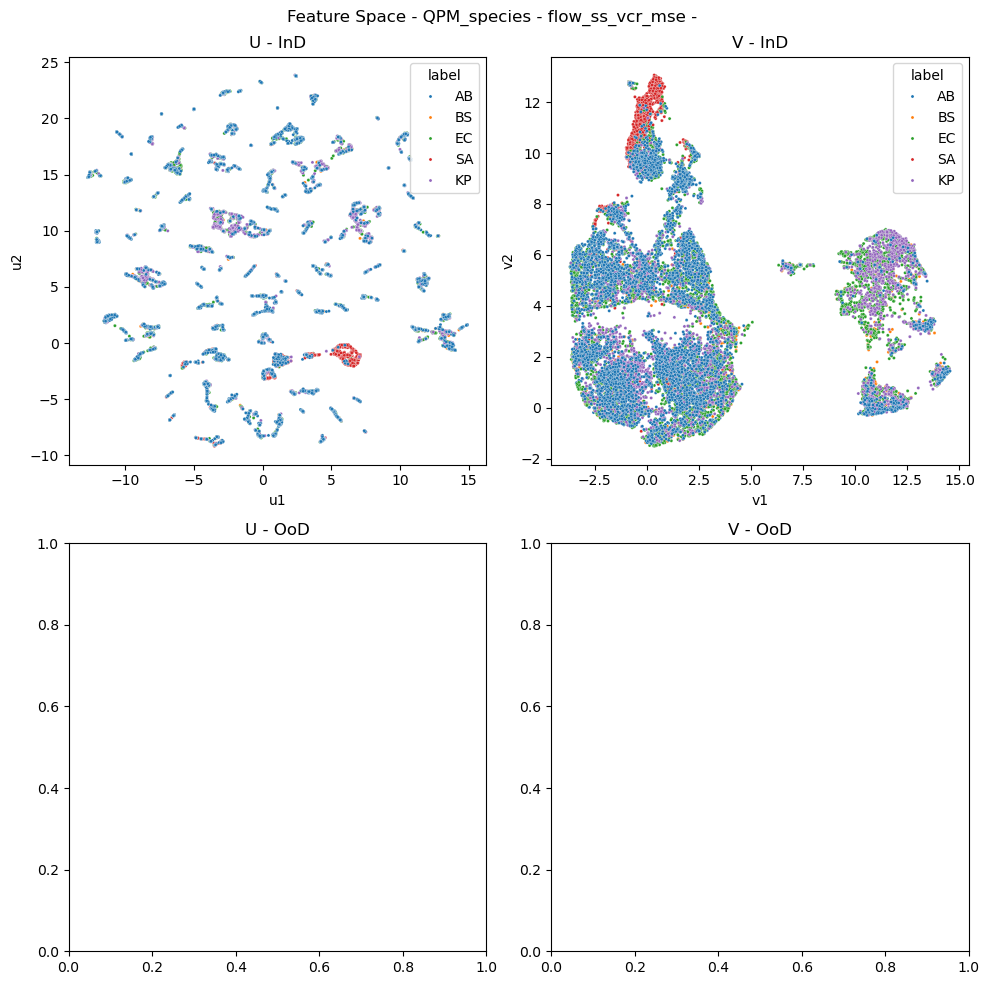

In [12]:
# plot feature space
ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

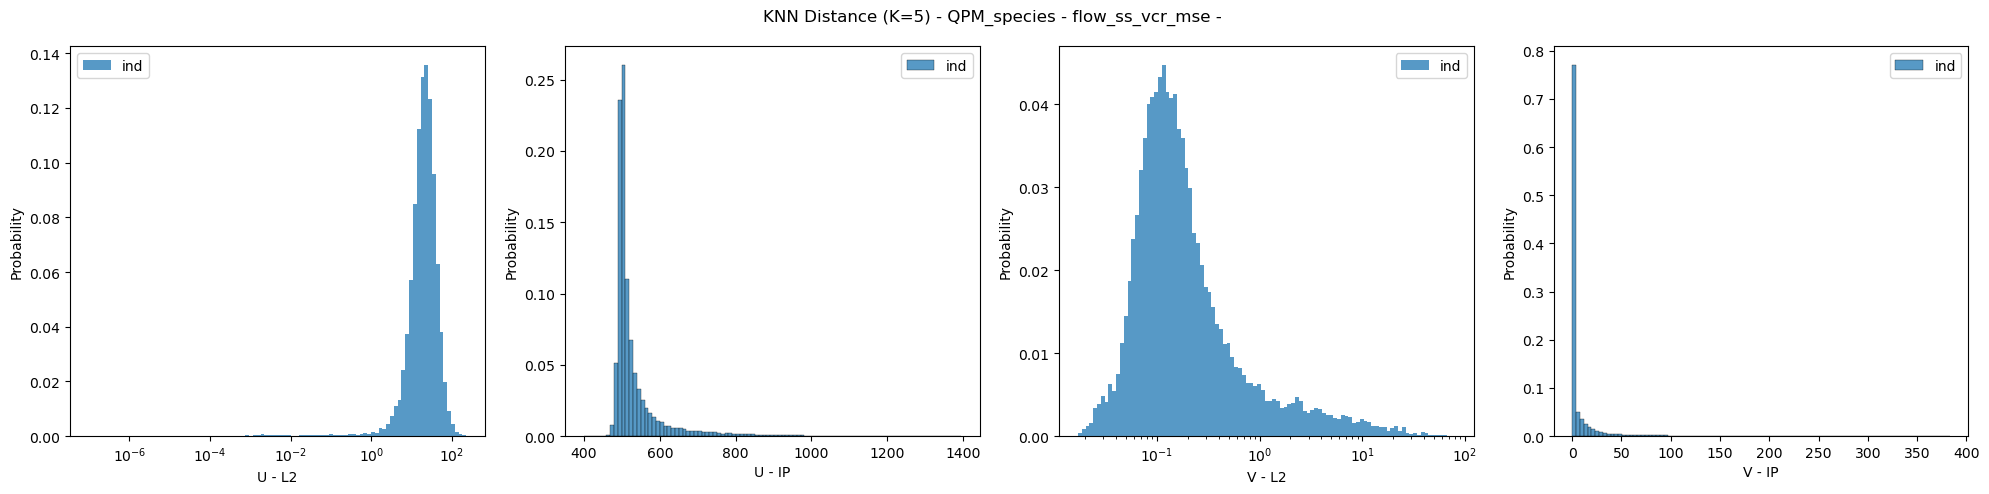

In [13]:
# plot knn distance from ind/ood to val data
def plot_knn_dists(index_fn, ax, trn_data, val_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(trn_data.shape[-1])
    index.add(trn_data)
    Dv = index.search(val_data, k)[0].mean(-1)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=Dv.tolist(), ind_data=Di.tolist(), ood_data=Do.tolist()))
        
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")
run_stats["knn_u_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], trn_e_u, val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="logspace")
axs[0].set_xlabel("U - L2")
run_stats["knn_u_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], trn_e_u, val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="linspace")
axs[1].set_xlabel("U - IP")
run_stats["knn_v_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], trn_e_v, val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="logspace")
axs[2].set_xlabel("V - L2")
run_stats["knn_v_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], trn_e_v, val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="linspace")
axs[3].set_xlabel("V - IP")
plt.tight_layout()
plt.show()

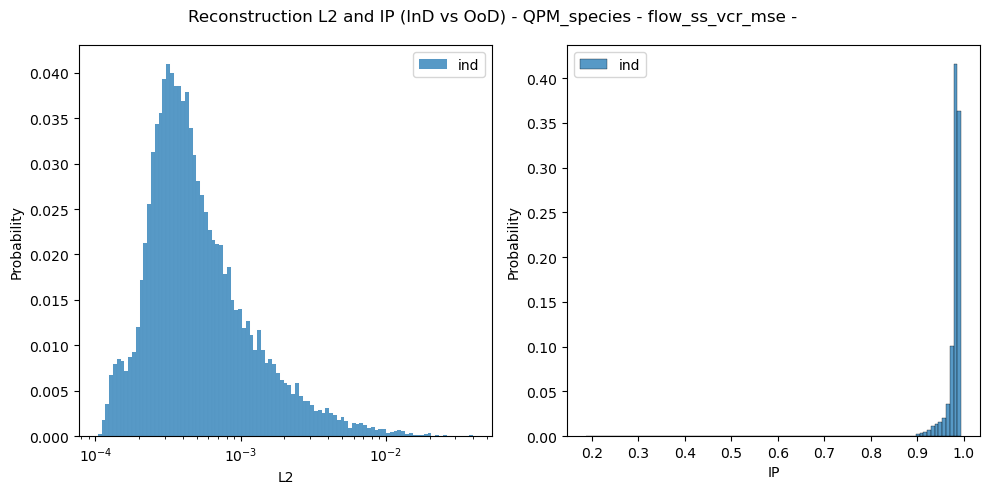

In [14]:
# plot reconstruction-based ood metrics
def plot_rcn(val_rcn, ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=val_rcn.tolist(), ind_data=ind_rcn.tolist(), ood_data=ood_rcn.tolist()))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)


# training data
_val_inp, _val_rcn = flatten(val_inp), flatten(val_rcn)
_val_inp_unit, _val_rcn_unit = unit(_val_inp), unit(_val_rcn)
# metrics
val_rcn_l2 = ((_val_inp - _val_rcn) ** 2).mean(-1)
val_rcn_ip = (_val_inp_unit * _val_rcn_unit).sum(-1)

# ind test data
_ind_inp, _ind_rcn = flatten(ind_inp), flatten(ind_rcn)
_ind_inp_unit, _ind_rcn_unit = unit(_ind_inp), unit(_ind_rcn)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # ood test data
    _ood_inp, _ood_rcn = flatten(ood_inp), flatten(ood_rcn)
    _ood_inp_unit, _ood_rcn_unit = unit(_ood_inp), unit(_ood_rcn)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
run_stats["rcn_l2"] = plot_rcn(val_rcn_l2, ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(val_rcn_ip, ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
# compute vector norms
trn_n_u = np.linalg.norm(trn_e_u, axis=-1)
trn_n_v = np.linalg.norm(trn_e_v, axis=-1)
val_n_u = np.linalg.norm(val_e_u, axis=-1)
val_n_v = np.linalg.norm(val_e_v, axis=-1)
ind_n_u = np.linalg.norm(ind_e_u, axis=-1)
ind_n_v = np.linalg.norm(ind_e_v, axis=-1)

if ood_str:
    ood_n_u = np.linalg.norm(ood_e_u, axis=-1)
    ood_n_v = np.linalg.norm(ood_e_v, axis=-1)

run_stats["norm_u"] = dict(val_data=val_n_u.tolist(), ind_data=ind_n_u.tolist(), ood_data=ood_n_u.tolist() if ood_str else None)
run_stats["norm_v"] = dict(val_data=val_n_v.tolist(), ind_data=ind_n_v.tolist(), ood_data=ood_n_v.tolist() if ood_str else None)

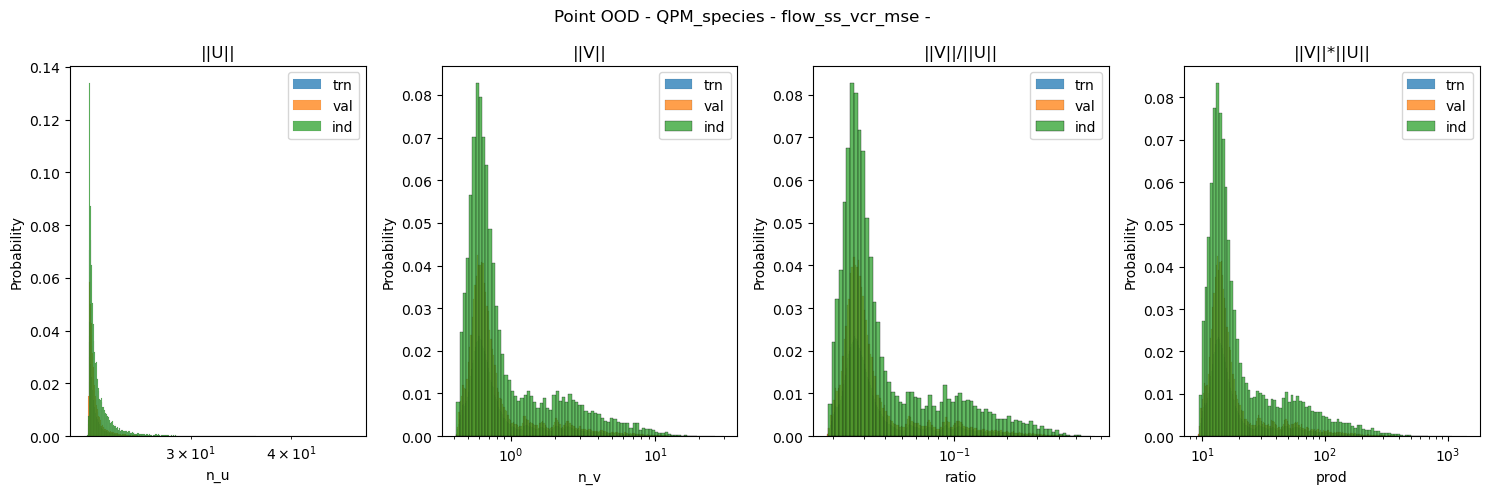

In [16]:
# plot pointwise ood metrics
df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [17]:
# organize data by class, aggregate groupwise
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


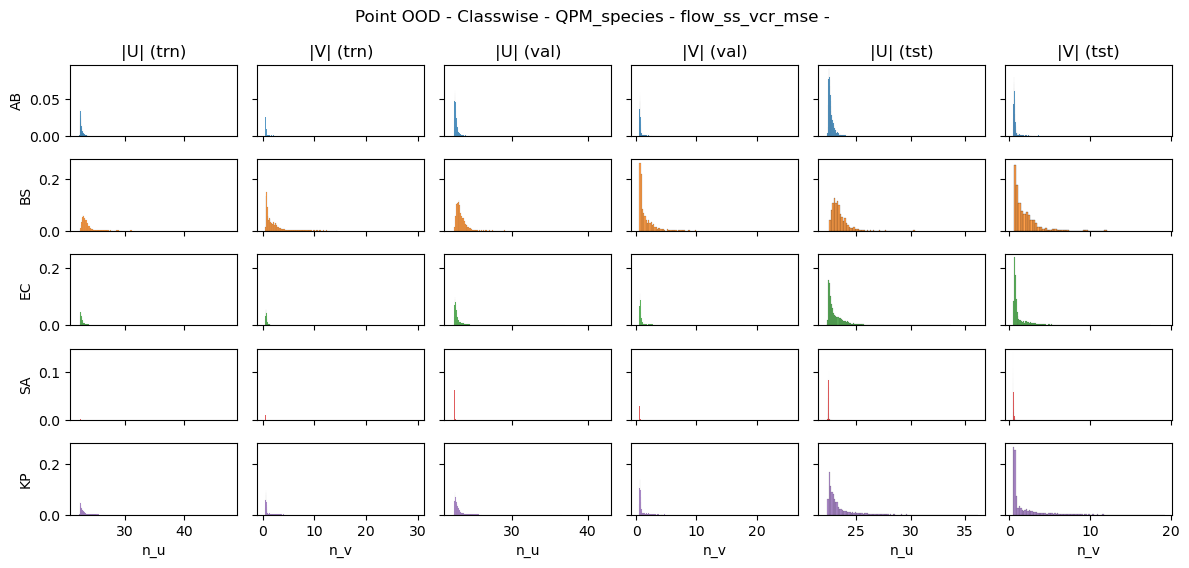

In [18]:
# plot per-class pointwise ood metrics
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

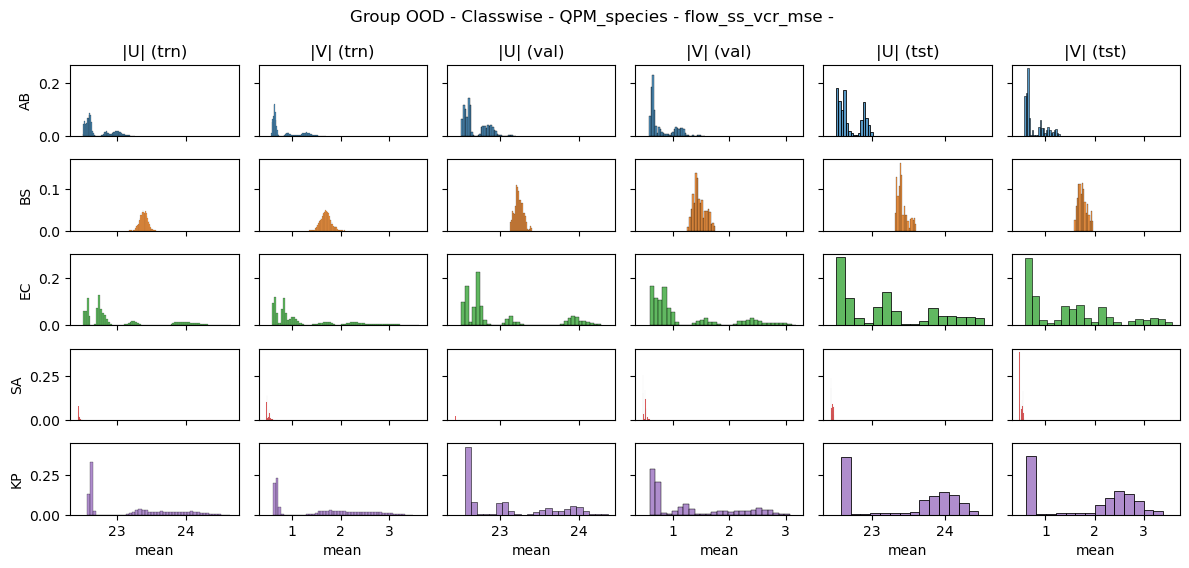

In [19]:
# plot per-class groupwise ood metrics
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

In [20]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))

import json
from datetime import datetime
with open(f"assets/results/{datetime.now()}.json", "w") as f:
    json.dump(run_stats, f)